In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.linalg as la
import matplotlib.pyplot as plt
import scipy.stats as stats

sys.path.append('/content/drive/MyDrive/grad_school/group_meeting_reports/')
import pyci.imsrg_ci.pyci_p3h as pyci

## The Dynamic Mode Decomposition

The DMD operator is a best fit linear operator that solves the problem,

$$x_{k+1} = Ax_k,$$

where $k$ represents the state vector $x$ evaluated at some point in time (dynamical range of the system). For equal width time series observations, for example, $k = t_k/\Delta t$. Note that the above equation can be extended to include an artribrary $n$ number of state vector observations, arranged into two data matrices $X$ and $X'$, where $X\rightarrow k$ and $X'\rightarrow k+1$, so that $X'\approx AX$. In general, the $m \times n$ matrix $X$ is tall and skinny, with $m>>n$.

In so-called exact DMD, the solution to this problem is given by the A that minimizes the Frobenius norm of the error (linear regression), 

$$\underset{A}{\mathrm{argmin}}||X' - AX|| = X'X^\dagger.$$

The eigendecomposition of $A$ ($A\Phi = \Phi\Lambda$) provide the DMD eigenvalues and modes, which linearize the dynamics of the system defined by $X$. 

The projected DMD reduces the problem size by truncating the singular values of the matrix $X$ at some threshold, and projecting $A$ into this smaller subspace. Since the projected DMD matrix is *similar* to the full DMD matrix, their eigenvalues will be the same (up to $r$).

$$X ≈ U_r\Sigma_r V_r^*$$
$$\tilde{A} = U_r^* A U_r$$

Gather time series information (time steps of non-linear dynamical system, for example). SVD the data, truncate up to important singular values (`r=3` default). Find the DMD matrix (or reduced DMD matrix, if truncating). Get the DMD eigenvectors/eigenvalues. Solve for the DMD mode amplitudes determined via the initial state vector. Solve for specific time step by DMD expansion of initial state vector (Koopman mode decomposition).

The DMD expansion at a given time step $k$ is written,

$$x_k = \sum_{j=1}^r \phi_j \lambda_j^{k-1}b_j= \Phi\Lambda^{k-1}b$$


where the $\Phi$ is the matrix of DMD eigenvectors that approximate the Koopman eigenvectors, $\Lambda$ is the diagonal matrix of DMD eigenvalues that approximate the Koopman eigenvalues, and $b$ is the DMD mode amplitudes which correspond to evaluation of the Koopman eigenfunctions at the intitial conditions. The mode amplitudes can be computed in several different ways with varying success, depending on the problem, and tradeoffs in performance. The simplest way is via

$$b = \Phi^\dagger x_1$$

If we replace $x_k \rightarrow H(s)$, then,

$$H(s) = \Phi\Lambda^{s/\Delta s-1}\Phi^\dagger H(0) = \mathcal{U}(s)H(0)$$

where we interpret the DMD expansion $\Phi\Lambda^{s/\Delta s-1}\Phi^\dagger$ as a unitary "super operator" $\mathcal{U}$ that generates the IMSRG flow. In this way, the DMD expansion can be viewed as method for explicitly constructing the operator that drives the IMSRG flow.

The DMD operator is data-driven, meaning that its explicit form is dependent on observations of the IMSRG solution at several time-steps. Consequently, the operator is dependent on the flow charactertistics of the IMSRG for the particular set of parameters used to collect the observation data. Constructing a DMD operator for one set of IMSRG parameters does not guarantee success from the same DMD operator on a different set of IMSRG parameters.


In [2]:
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD
def dmd(X, Xp, exact=True, r=3, k=10, as_matrix=False, randomize=False, n_components=10):
    H0 = X[:,0]

    # SVD on the X matrix (flow data)
    if not randomize:
        U,s,Vh = la.svd(X, full_matrices=False)
        s = s[0:r]
        U = U[:,0:r]
        Vh = Vh[0:r,:]
        sigma = np.diag(s)
    else:
        print("trying randomized SVD")
        U,s,Vh = randomized_svd(X, n_components, n_oversamples=2*X.shape[1]-n_components)
        print(U.shape)
    sigma = np.diag(s)

    # Construct DMD operator
    if exact:
        A = Xp@la.pinv(X)
    else:
        # A = U.conj().T@Xp@Vh.conj().T@la.inv(sigma)
        A = np.linalg.multi_dot([U.conj().T, Xp, Vh.conj().T])*np.reciprocal(s)
        print(A.shape)

    # DMD eigenvectors/eigenvalues
    if exact:
        w,phi = la.eig(A)
    else:
        w,v = la.eig(A)
        # Ud,sd,Vhd = la.svd(A)
        # print(A.shape, Xp.shape, Vhd.conj().T.shape, np.diag(sd).shape, v.shape)
        # phi = Xp@Vhd.conj().T@la.inv(np.diag(sd))@v
        # print(U.shape, v.shape)

        #phi = U@v

        phi = Xp@Vh.conj().T@la.inv(sigma)@v*np.reciprocal(w)
    print("phi, ", phi.shape)

    # DMD mode amplitudes
    # n_components = 50
    # U_phi,s_phi,Vh_phi = randomized_svd(phi, n_components, n_oversamples=2*X.shape[1]-n_components)
    # sigma_phi = np.diag(s_phi)
    # U_phi = U_phi[:,0:r]
    # sigma_phi = sigma_phi[0:r,0:r]
    # Vh_phi = Vh_phi[0:r,:]
    # phi_inv = Vh_phi.conj().T@la.pinv(sigma_phi)@U_phi.conj().T
    # b = phi_inv@H0

    # phi_R = la.qr(phi, mode='r')[0]
    # phi_Rt = phi_R.conj().T
    # phi_inv = la.inv(phi_Rt@phi_R)@phi_Rt
    # b = phi_inv@H0
    

    # b = la.pinv(phi)@H0
    b = np.linalg.lstsq(phi, H0, rcond=None)[0]

    print("b ", b.shape)
    Hs = phi@np.linalg.matrix_power(np.diag(w),k-1)@b

    print("Hs, ", Hs.shape)
    if as_matrix:
        # lambda_pw = np.linalg.matrix_power(np.diag(w),k-1)
        dmd_eig = np.diag(w)
        return (phi, dmd_eig, b)
    return Hs

## Eigenvector Continuation

Prepare training points matrix $X$, which are several ground state (or higher) eigenvectors varying Hamiltonian control parameter (eigenvectors are columns in $X$). Orthogonalize the training points. Solve the generalized eigenvalue problem $X^T H_{target} X \Phi = X^T X \Phi \Lambda$.

In [3]:
def eigenvector_continuation(H_target, training_arr):
  
    training_arr = la.orth(training_arr)
    H_ec = training_arr.T@H_target@training_arr
    N_ec = training_arr.T@training_arr
    #print(N_ec)
    w_ec, v_ec = la.eigh(H_ec, N_ec)
    
    return (w_ec[0], v_ec[:,0])


## Retrieving data

Load the time series training data. Columns are CI matrices computed from IMSRG coefficients.

In [4]:
import struct

def get_log_data(data_path, imsrg=False):
    numStates = int(data_path.split('-')[0].replace('flow/H',''))
    imsrg_vecs = []
    
    with open(data_path, 'r') as f:

        for count,line in enumerate(f):
            if count < 7:
                continue
            if line.split(',')[0] == 'elapsed':
                break

            line_arr = np.array(line.split(','))[0:-1]
            line_arr = line_arr.astype(np.float)
            #print(line_arr.shape)
            #imsrg_vecs.append(line_arr)

            if imsrg:
                imsrg_vecs.append(line_arr)
            else:
                h0b = float(line_arr[0])
                h1b = np.reshape(line_arr[1:numStates*numStates+1], (numStates, numStates))
                h2b = np.reshape(line_arr[numStates*numStates+1:numStates*numStates+1+numStates*numStates*numStates*numStates+1], (numStates,numStates,numStates,numStates))

                #print("STARTING CI")
                hme = pyci.matrix(int(numStates/2), int(numStates/2), h0b, h1b, h2b, h2b, imsrg=True)
                imsrg_vecs.append(np.ravel(hme))

    imsrg_vecs = np.array(imsrg_vecs, dtype=np.float32).T

    return imsrg_vecs

def get_ascii_log(data_path):
    imsrg_vecs = []

    with open(data_path, "r") as f:
        count = 0
        for line in f:
            line_arr = np.array(line.split(','))[0:-1]
            line_arr = line_arr.astype(dtype=np.float64)
            imsrg_vecs.append(line_arr)

            count += 1
    
            print("Line {:02d} | Loaded {:5.2f} MBs from file".format(count, count*line_arr.shape[0]*8/1024/1024))
    imsrg_vecs = np.array(imsrg_vecs, dtype=np.float64).T

    return imsrg_vecs
        

def get_binary_log(data_path):
    imsrg_vecs = []
    with open(data_path, "rb") as f:
        count = 0
        double = f.read(9)
        vec = []
        while double:
            #print(struct.unpack('@d',double))
            value = struct.unpack('@dc',double)[0]
            #throw = f.read(1)
            

            peek = f.peek(1)[:1]
            chck = struct.unpack('@c', peek)[0]
            #print(chck)
            if chck == b'w':
                vec = np.array(vec)
                imsrg_vecs.append(vec)
                vec = []
                throw = f.read(1)
                print('found newline (previous value={:0.4f})'.format(value))
            else:
                vec.append(value)

            double = f.read(9)

            count += 1

            if count % 500000 == 0:
                print ("read {:5.2f} MBs or {:d} numbers".format(count*8/1024/1024, count))
    imsrg_vecs = np.array(imsrg_vecs, dtype=np.float32).T
    return imsrg_vecs    
        

        
        #print(struct.unpack('@d',f.read(9)))
    # lines = []
    # with open(data_path, 'rb') as f:
    #     fileContent = f.read()
    
    #     print(f[0])
    #     for line in f:
            
    #         line_arr = np.array(line.split(','))
    #         line_arr = line_arr.astype(np.float)
    #         lines.append(line_arr)

    # imsrg_vecs = np.array(lines, dtype=np.float32).T

Generate the control parameter training data. Each column will be ground state eigenvector computed from CI matrix, varying pairing strength of pairing-plus-particle-hole model Hamiltonian.

In [5]:
def generate_cp_data(nholes, nparticles, grange, brange, keep_mat=False):
    ci_evecs = []
    for g in grange:
        for b in brange:
            hme = pyci.matrix(nholes, nparticles, 0.0, 1.0, g, b)
            w,V = np.linalg.eigh(hme)

            if keep_mat:
                ci_evecs.append(np.ravel(hme))
            else:
                ci_evecs.append(V[:,0])

    ci_evecs = np.array(ci_evecs).T

    return ci_evecs

Obtain the data for testing. The IMSRG flow log files are very large to be able to efficiently compute the CI matrix for every flow step. Need to optimize that somehow.

In [6]:
%cd /content/drive/MyDrive/grad_school/group_meeting_reports/12-16-2021/

# IMSRG flow data, 8 s.p. g=0.5 b=0.0
ts_data = get_log_data('flow/H08-1.00-0.50-0.10-0.00-5.00-0.10.log')
ts_imsrg_data = get_log_data('flow/H08-1.00-1.50-0.40-0.00-5.00-0.10.log', imsrg=True)
real_imsrg_data = get_ascii_log('flow/O16_chi2b_srg0625_eMax06_hwHO020.flow.log')
# real_imsrg_data = get_ascii_log('flow/O16_chi2b_srg0625_eMax08_hwHO020.flow.log')

# ts_imsrg_data = get_log_data('flow/H08-1.00-1.00-0.50-0.00-7.00-0.10.imsrg.log', imsrg=True)

# Control parameter data, 8 s.p. vary g from -2.0 to 2.0 for 51 data points. Fix b at zero.
grange = np.linspace(-2.0, 2.0, num=50)
brange = [0.0]
cp_data = generate_cp_data(4,4, grange, brange)

print('Time series data shape            = {};         Total size = {:6.4f} MB'.format(ts_data.shape, ts_data.shape[0]*ts_data.shape[1]*8/1024/1024))
print('Time series IMSRG data shape      = {};         Total size = {:6.4f} MB'.format(ts_imsrg_data.shape, ts_imsrg_data.shape[0]*ts_imsrg_data.shape[1]*8/1024/1024))
print('Control parameter data shape      = {};         Total size = {:6.4f} MB'.format(cp_data.shape, cp_data.shape[0]*cp_data.shape[1]*8/1024/1024))
print('Time series real IMSRG data shape = {};         Total size = {:6.4f} MB'.format(real_imsrg_data.shape, real_imsrg_data.shape[0]*real_imsrg_data.shape[1]*8/1024/1024))


/content/drive/MyDrive/grad_school/group_meeting_reports/12-16-2021
Line 01 | Loaded  3.56 MBs from file
Line 02 | Loaded  7.13 MBs from file
Line 03 | Loaded 10.69 MBs from file
Line 04 | Loaded 14.26 MBs from file
Line 05 | Loaded 17.82 MBs from file
Line 06 | Loaded 21.38 MBs from file
Line 07 | Loaded 24.95 MBs from file
Line 08 | Loaded 28.51 MBs from file
Line 09 | Loaded 32.08 MBs from file
Line 10 | Loaded 35.64 MBs from file
Line 11 | Loaded 39.20 MBs from file
Line 12 | Loaded 42.77 MBs from file
Line 13 | Loaded 46.33 MBs from file
Line 14 | Loaded 49.90 MBs from file
Line 15 | Loaded 53.46 MBs from file
Line 16 | Loaded 57.02 MBs from file
Line 17 | Loaded 60.59 MBs from file
Line 18 | Loaded 64.15 MBs from file
Line 19 | Loaded 67.71 MBs from file
Line 20 | Loaded 71.28 MBs from file
Line 21 | Loaded 74.84 MBs from file
Line 22 | Loaded 78.41 MBs from file
Line 23 | Loaded 81.97 MBs from file
Line 24 | Loaded 85.53 MBs from file
Line 25 | Loaded 89.10 MBs from file
Line 26

## DMD solution to IMSRG flow in Slater determinant basis

Demonstrate DMD solution. Here we give the DMD algorithm examples of the IMSRG flowing Hamiltonian, in order to build an operator that generates a "flow" characterized by the DMD expansion power $k$. We see that the DMD expansion emulates the IMSRG flow, in the way off diagonal components are suppressed, with "amount of flow" controlled via the expansion power $k$.

(5, 5)
phi,  (1296, 5)
b  (5,)
Hs,  (1296,)


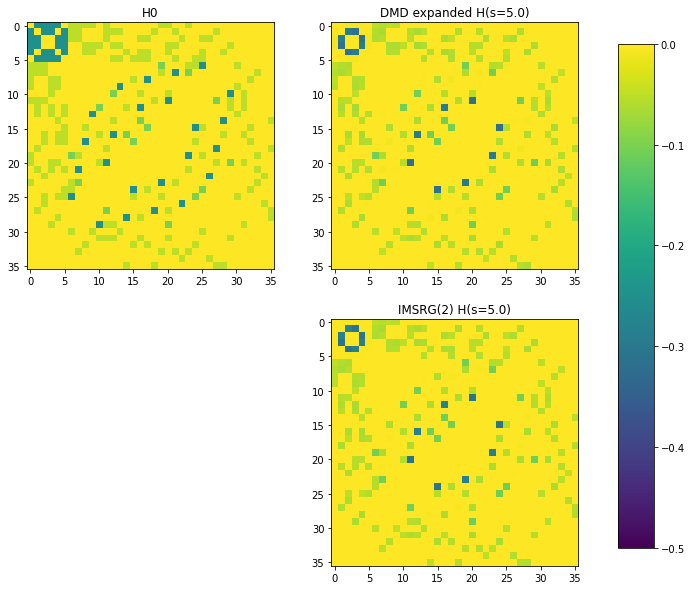

In [7]:
# Run DMD on time series data. Flow to k=50, which extrapolates to s=5.0
nobs = 5
X = ts_data[:, 0:nobs]
Xp = ts_data[:, 1:nobs+1]

H0 = np.reshape(ts_data[:,0], (36,36))
Hf = np.reshape(ts_data[:,-1], (36,36))
Hs = dmd(X, Xp, exact=False, r=5, k=50)
Hs = np.real(np.reshape(Hs, (36,36)))

fig,axes = plt.subplots(figsize=(10,10), ncols=2,nrows=2)
axes = np.ravel(axes)
Hod = H0 - np.diag(np.diag(H0))
Hsod = Hs - np.diag(np.diag(Hs))
Hfod = Hf - np.diag(np.diag(Hf))

g=axes[0].imshow(Hod,  vmin=-0.5, vmax=0.0)
g=axes[1].imshow(Hsod, vmin=-0.5, vmax=0.0)
axes[2].axis("off")
g=axes[3].imshow(Hfod, vmin=-0.5, vmax=0.0)

axes[0].set_title('H0')
axes[1].set_title('DMD expanded H(s=5.0)')
axes[3].set_title('IMSRG(2) H(s=5.0)')

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(g, cax=cbar_ax)

## Eigenvector continuation to solve FCI

Demonstrate EC solution. Eigenvector continuation essentially projects the target Hamiltonian into a "training basis", which contains information on how the eigenbasis of the Hamiltonian varies with the control parameter. Assuming that the eigenbasis varies smoothly in a low-dimensional subspace of the full parameter space, then the target Hamiltonian eigenbasis can be expanded in this small subspace of "training points" (e.g. ground state eigenvectors varying Hamiltonian control parameter), which amounts to solving an easier generalized eigenvalue problem. Of course, the easiness is relative to how hard it would be to fully diagonalize the target Hamiltonian. 

In [8]:
H_target = pyci.matrix(4,4,0.0,1.0,4.0,0.0)

w0, v0 = eigenvector_continuation(H_target, cp_data[:,0:4])
w_ci, V_ci = np.linalg.eigh(H_target)
print(w0, w_ci[0])
print("EC error = {:0.5f}".format((w0-w_ci[0])/w_ci[0]))

-6.6794339850510696 -6.808093992928855
EC error = -0.01890


## DMD to emulate FCI solution

Try DMD using control parameter data. In this case, the problem is slightly different. We give the DMD algorithm examples of a smoothly varied Hamiltonian dependent on a particular control parameter, and ask it to reproduce a Hamiltonian for a given control parameter, characterized by a particular power in the DMD expansion. 

Framing the problem in this way, the solution is similar to eigenvector continuation. However, the major is difference is that DMD decomposition explicitly constructs a continuous "generating" operator, whereas EC solves the problem for a single target. 

In [9]:
# Get new cp data that keeps full matrix.
grange = np.linspace(-2.0, 2.0, num=100)
# brange = np.linspace(-2.0, 2.0, num=30)
brange=[0.0]
cp_dmd_data = generate_cp_data(4,4, grange, brange, keep_mat=True)

In [10]:
import itertools
serial_params = list(itertools.product(grange,brange))
print(serial_params)

[(-2.0, 0.0), (-1.9595959595959596, 0.0), (-1.9191919191919191, 0.0), (-1.878787878787879, 0.0), (-1.8383838383838385, 0.0), (-1.797979797979798, 0.0), (-1.7575757575757576, 0.0), (-1.7171717171717171, 0.0), (-1.6767676767676767, 0.0), (-1.6363636363636362, 0.0), (-1.595959595959596, 0.0), (-1.5555555555555556, 0.0), (-1.5151515151515151, 0.0), (-1.4747474747474747, 0.0), (-1.4343434343434343, 0.0), (-1.393939393939394, 0.0), (-1.3535353535353534, 0.0), (-1.3131313131313131, 0.0), (-1.2727272727272727, 0.0), (-1.2323232323232323, 0.0), (-1.1919191919191918, 0.0), (-1.1515151515151514, 0.0), (-1.1111111111111112, 0.0), (-1.0707070707070705, 0.0), (-1.0303030303030303, 0.0), (-0.9898989898989898, 0.0), (-0.9494949494949494, 0.0), (-0.909090909090909, 0.0), (-0.8686868686868685, 0.0), (-0.8282828282828283, 0.0), (-0.7878787878787878, 0.0), (-0.7474747474747474, 0.0), (-0.707070707070707, 0.0), (-0.6666666666666665, 0.0), (-0.6262626262626261, 0.0), (-0.5858585858585856, 0.0), (-0.54545454

In [11]:
# Run DMD on time series data. Flow to k=50, which extrapolates to g=4.08
print("CONTROL PARAM DATA SHAPE = {}".format(cp_dmd_data.shape))

df_list = []
for nobs in [10,15,20,25,30,35,40,45,50]:#,70,100,150,200]:
    for r in [2,3,4,5,6,7,8]:#,10,15,20]:
        nobs = nobs
        X = cp_dmd_data[:, 0:nobs]
        Xp = cp_dmd_data[:, 1:nobs+1]

        i=75
        H0 = np.reshape(cp_dmd_data[:,0], (36,36))
        Hf = np.reshape(cp_dmd_data[:,i], (36,36))
        Hs = dmd(X, Xp, exact=False, r=r, k=i)
        Hs = np.real(np.reshape(Hs, (36,36)))

        # fig,axes = plt.subplots(figsize=(10,10), ncols=2,nrows=2)
        # axes = np.ravel(axes)
        # Hod = H0 - np.diag(np.diag(H0))
        # Hsod = Hs - np.diag(np.diag(Hs))
        # Hfod = Hf - np.diag(np.diag(Hf))

        # vmin,vmax = -0.25,8.0
        # # g=axes[0].imshow(H0,)
        # axes[0].axis("off")
        # g=axes[1].imshow(Hs,vmin=vmin,vmax=vmax)
        # axes[2].axis("off")
        # g=axes[3].imshow(Hf,vmin=vmin,vmax=vmax)

        g0,b0 = serial_params[0]
        gi,bi = serial_params[i]
        # axes[0].set_title('H(g={:0.3f}, b={:0.3f})'.format(g0,b0))
        # axes[1].set_title('DMD expanded H(g={:0.3f}, b={:0.3f})'.format(gi,bi))
        # axes[3].set_title('H(g={:0.3f}, b={:0.3f})'.format(gi,bi))

        # # axes[0].set_title('H(g={:0.3f})'.format(grange[0]))
        # # axes[1].set_title('DMD expanded H(g={:0.3f})'.format((grange[1]-grange[0])*i+grange[0]))
        # # axes[3].set_title('H(g={:0.3f})'.format((grange[1]-grange[0])*i+grange[0]))

        # cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
        # fig.colorbar(g, cax=cbar_ax)

        Hf_nz = Hf[np.nonzero(Hf)]
        Hs_nz = Hs[np.nonzero(Hf)]
        # error = np.average((Hs_nz-Hf_nz)/Hf_nz)
        error = np.average((Hs-Hf)**2)

        ws,vs = np.linalg.eigh(Hs)
        wf,vf = np.linalg.eigh(Hf)
        eig_error = (ws[0]-wf[0])/wf[0]

        print("# OBSERVATIONS = {}".format(nobs))
        print("Initial g = {:0.3f}, b = {:0.3f}".format(g0,b0))
        print("DMD expansion g = {:0.3f}, b = {:0.3f}".format(gi,bi))
        print("Hamiltonian reproduction error = {:0.5f}".format(error))
        print("Ground state relative error = {:0.5f}".format(eig_error))
        
        row = pd.DataFrame([[nobs,r, error, eig_error]], 
                           columns=["nobs", "r", "reproduction_error", "gs_rel_error"])
        df_list.append(row)
full_df = pd.concat(df_list, ignore_index=True)


CONTROL PARAM DATA SHAPE = (1296, 100)
(2, 2)
phi,  (1296, 2)
b  (2,)
Hs,  (1296,)
# OBSERVATIONS = 10
Initial g = -2.000, b = 0.000
DMD expansion g = 1.030, b = 0.000
Hamiltonian reproduction error = 0.00003
Ground state relative error = 0.12388
(3, 3)
phi,  (1296, 3)
b  (3,)
Hs,  (1296,)
# OBSERVATIONS = 10
Initial g = -2.000, b = 0.000
DMD expansion g = 1.030, b = 0.000
Hamiltonian reproduction error = 0.00003
Ground state relative error = 0.12388
(4, 4)
phi,  (1296, 4)
b  (4,)
Hs,  (1296,)
# OBSERVATIONS = 10
Initial g = -2.000, b = 0.000
DMD expansion g = 1.030, b = 0.000
Hamiltonian reproduction error = 0.00003
Ground state relative error = 0.12388
(5, 5)
phi,  (1296, 5)
b  (5,)
Hs,  (1296,)
# OBSERVATIONS = 10
Initial g = -2.000, b = 0.000
DMD expansion g = 1.030, b = 0.000
Hamiltonian reproduction error = 0.00003
Ground state relative error = 0.12388
(6, 6)
phi,  (1296, 6)
b  (6,)
Hs,  (1296,)
# OBSERVATIONS = 10
Initial g = -2.000, b = 0.000
DMD expansion g = 1.030, b = 0.000


(-2.0, 5.0)

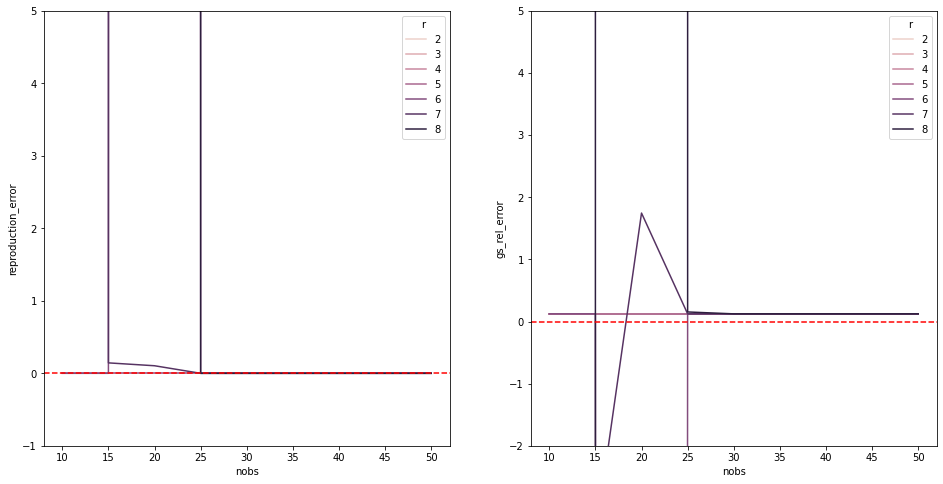

In [12]:
fig,axes = plt.subplots(figsize=(16,8),ncols=2)
sns.lineplot(x="nobs",y="reproduction_error",hue="r", data=full_df, ax=axes[0])
sns.lineplot(x="nobs",y="gs_rel_error",hue="r", data=full_df,ax=axes[1])
axes[0].axhline(0.0, color="red", linestyle="--")
axes[1].axhline(0.0, color="red", linestyle="--")
axes[0].set_ylim(ymin=-1,ymax=5)
axes[1].set_ylim(ymin=-2,ymax=5)

## DMD solution to IMSRG in operator basis

We build the DMD operator from IMSRG state vectors directly, rather than processing the coefficients to get the Slater determinant representation in previous sections. In this case, the state vectors will be larger, but the DMD will have access to the dynamics of the operator coefficients.

These data are collected from the `C++` implemenation of the IMSRG solution to the pairing-plus-particle-hole model Hamiltonian.

In [13]:
# Run DMD on time series data (IMSRG COEFFICIENT VECTORS). 
# Flow to k=50, which extrapolates to s=5.0
from IPython.display import display, clear_output
ts_imsrg_data = get_log_data('flow/H08-1.00-1.40-0.40-0.00-5.00-0.10.log', imsrg=True)
# ts_imsrg_data = get_log_data('flow/H08-1.00-0.50-0.10-0.00-5.00-0.10.imsrg.log', imsrg=True)

df_list = []
for nobs in [4,5,10,15,20,25,35]:
    nobs = nobs
    X = ts_imsrg_data[:, 0:nobs]
    Xp = ts_imsrg_data[:, 1:nobs+1]

    H0 = ts_imsrg_data[:,0]
    Hf = ts_imsrg_data[:,-1]

    phi,dmd_eig,b = dmd(X, Xp, exact=False, r=10, randomize=False,n_components=15, as_matrix=True)
    # phi = np.real(phi)
    # dmd_eig = np.real(dmd_eig)
    # b = np.real(b)
    print(np.diag(dmd_eig))
    kvals = range(0,50)
    for k in kvals:
        string = "# OBSERVATIONS={:02d}\nRUNNING ON K={:02d}".format(nobs,k)
        # clear_output(wait=True)
        display(string)

        Hs = phi@np.linalg.matrix_power(dmd_eig,k)@b
        Hs = np.real(Hs)
        row = pd.DataFrame([[nobs, k, H0[0], Hf[0], Hs[0]]], 
                           columns=["nobs", "k", "E0", "Ef", "Es"])
        df_list.append(row)
full_df = pd.concat(df_list, ignore_index=True)


# Hs = np.real(np.reshape(Hs, (36,36)))

# fig,axes = plt.subplots(figsize=(10,10), ncols=2,nrows=2)
# axes = np.ravel(axes)
# Hod = H0 - np.diag(np.diag(H0))
# Hsod = Hs - np.diag(np.diag(Hs))
# Hfod = Hf - np.diag(np.diag(Hf))

# g=axes[0].imshow(Hod,  vmin=-0.5, vmax=0.0)
# g=axes[1].imshow(Hsod, vmin=-0.5, vmax=0.0)
# axes[2].axis("off")
# g=axes[3].imshow(Hfod, vmin=-0.5, vmax=0.0)

# axes[0].set_title('H0')
# axes[1].set_title('DMD expanded H(s=5.0)')
# axes[3].set_title('IMSRG(2) H(s=5.0)')

# cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
# fig.colorbar(g, cax=cbar_ax)

(4, 4)
phi,  (4161, 4)
b  (4,)
Hs,  (4161,)
[1.0086647 +0.j 0.9784324 +0.j 0.8717586 +0.j 0.71563554+0.j]


'# OBSERVATIONS=04\nRUNNING ON K=00'

'# OBSERVATIONS=04\nRUNNING ON K=01'

'# OBSERVATIONS=04\nRUNNING ON K=02'

'# OBSERVATIONS=04\nRUNNING ON K=03'

'# OBSERVATIONS=04\nRUNNING ON K=04'

'# OBSERVATIONS=04\nRUNNING ON K=05'

'# OBSERVATIONS=04\nRUNNING ON K=06'

'# OBSERVATIONS=04\nRUNNING ON K=07'

'# OBSERVATIONS=04\nRUNNING ON K=08'

'# OBSERVATIONS=04\nRUNNING ON K=09'

'# OBSERVATIONS=04\nRUNNING ON K=10'

'# OBSERVATIONS=04\nRUNNING ON K=11'

'# OBSERVATIONS=04\nRUNNING ON K=12'

'# OBSERVATIONS=04\nRUNNING ON K=13'

'# OBSERVATIONS=04\nRUNNING ON K=14'

'# OBSERVATIONS=04\nRUNNING ON K=15'

'# OBSERVATIONS=04\nRUNNING ON K=16'

'# OBSERVATIONS=04\nRUNNING ON K=17'

'# OBSERVATIONS=04\nRUNNING ON K=18'

'# OBSERVATIONS=04\nRUNNING ON K=19'

'# OBSERVATIONS=04\nRUNNING ON K=20'

'# OBSERVATIONS=04\nRUNNING ON K=21'

'# OBSERVATIONS=04\nRUNNING ON K=22'

'# OBSERVATIONS=04\nRUNNING ON K=23'

'# OBSERVATIONS=04\nRUNNING ON K=24'

'# OBSERVATIONS=04\nRUNNING ON K=25'

'# OBSERVATIONS=04\nRUNNING ON K=26'

'# OBSERVATIONS=04\nRUNNING ON K=27'

'# OBSERVATIONS=04\nRUNNING ON K=28'

'# OBSERVATIONS=04\nRUNNING ON K=29'

'# OBSERVATIONS=04\nRUNNING ON K=30'

'# OBSERVATIONS=04\nRUNNING ON K=31'

'# OBSERVATIONS=04\nRUNNING ON K=32'

'# OBSERVATIONS=04\nRUNNING ON K=33'

'# OBSERVATIONS=04\nRUNNING ON K=34'

'# OBSERVATIONS=04\nRUNNING ON K=35'

'# OBSERVATIONS=04\nRUNNING ON K=36'

'# OBSERVATIONS=04\nRUNNING ON K=37'

'# OBSERVATIONS=04\nRUNNING ON K=38'

'# OBSERVATIONS=04\nRUNNING ON K=39'

'# OBSERVATIONS=04\nRUNNING ON K=40'

'# OBSERVATIONS=04\nRUNNING ON K=41'

'# OBSERVATIONS=04\nRUNNING ON K=42'

'# OBSERVATIONS=04\nRUNNING ON K=43'

'# OBSERVATIONS=04\nRUNNING ON K=44'

'# OBSERVATIONS=04\nRUNNING ON K=45'

'# OBSERVATIONS=04\nRUNNING ON K=46'

'# OBSERVATIONS=04\nRUNNING ON K=47'

'# OBSERVATIONS=04\nRUNNING ON K=48'

'# OBSERVATIONS=04\nRUNNING ON K=49'

(5, 5)
phi,  (4161, 5)
b  (5,)
Hs,  (4161,)
[1.0049584 +0.01185864j 1.0049584 -0.01185864j 0.89567673+0.j
 0.79333   +0.j         0.56281966+0.j        ]


'# OBSERVATIONS=05\nRUNNING ON K=00'

'# OBSERVATIONS=05\nRUNNING ON K=01'

'# OBSERVATIONS=05\nRUNNING ON K=02'

'# OBSERVATIONS=05\nRUNNING ON K=03'

'# OBSERVATIONS=05\nRUNNING ON K=04'

'# OBSERVATIONS=05\nRUNNING ON K=05'

'# OBSERVATIONS=05\nRUNNING ON K=06'

'# OBSERVATIONS=05\nRUNNING ON K=07'

'# OBSERVATIONS=05\nRUNNING ON K=08'

'# OBSERVATIONS=05\nRUNNING ON K=09'

'# OBSERVATIONS=05\nRUNNING ON K=10'

'# OBSERVATIONS=05\nRUNNING ON K=11'

'# OBSERVATIONS=05\nRUNNING ON K=12'

'# OBSERVATIONS=05\nRUNNING ON K=13'

'# OBSERVATIONS=05\nRUNNING ON K=14'

'# OBSERVATIONS=05\nRUNNING ON K=15'

'# OBSERVATIONS=05\nRUNNING ON K=16'

'# OBSERVATIONS=05\nRUNNING ON K=17'

'# OBSERVATIONS=05\nRUNNING ON K=18'

'# OBSERVATIONS=05\nRUNNING ON K=19'

'# OBSERVATIONS=05\nRUNNING ON K=20'

'# OBSERVATIONS=05\nRUNNING ON K=21'

'# OBSERVATIONS=05\nRUNNING ON K=22'

'# OBSERVATIONS=05\nRUNNING ON K=23'

'# OBSERVATIONS=05\nRUNNING ON K=24'

'# OBSERVATIONS=05\nRUNNING ON K=25'

'# OBSERVATIONS=05\nRUNNING ON K=26'

'# OBSERVATIONS=05\nRUNNING ON K=27'

'# OBSERVATIONS=05\nRUNNING ON K=28'

'# OBSERVATIONS=05\nRUNNING ON K=29'

'# OBSERVATIONS=05\nRUNNING ON K=30'

'# OBSERVATIONS=05\nRUNNING ON K=31'

'# OBSERVATIONS=05\nRUNNING ON K=32'

'# OBSERVATIONS=05\nRUNNING ON K=33'

'# OBSERVATIONS=05\nRUNNING ON K=34'

'# OBSERVATIONS=05\nRUNNING ON K=35'

'# OBSERVATIONS=05\nRUNNING ON K=36'

'# OBSERVATIONS=05\nRUNNING ON K=37'

'# OBSERVATIONS=05\nRUNNING ON K=38'

'# OBSERVATIONS=05\nRUNNING ON K=39'

'# OBSERVATIONS=05\nRUNNING ON K=40'

'# OBSERVATIONS=05\nRUNNING ON K=41'

'# OBSERVATIONS=05\nRUNNING ON K=42'

'# OBSERVATIONS=05\nRUNNING ON K=43'

'# OBSERVATIONS=05\nRUNNING ON K=44'

'# OBSERVATIONS=05\nRUNNING ON K=45'

'# OBSERVATIONS=05\nRUNNING ON K=46'

'# OBSERVATIONS=05\nRUNNING ON K=47'

'# OBSERVATIONS=05\nRUNNING ON K=48'

'# OBSERVATIONS=05\nRUNNING ON K=49'

(10, 10)
phi,  (4161, 10)
b  (10,)
Hs,  (4161,)
[ 1.0140812+0.j         1.0013846+0.j         0.9243122+0.j
  0.8468679+0.j         0.7623343+0.j         0.5239417+0.j
 -0.2978093+0.6806456j -0.2978093-0.6806456j -0.8302597+0.j
 -0.6747488+0.j       ]


'# OBSERVATIONS=10\nRUNNING ON K=00'

'# OBSERVATIONS=10\nRUNNING ON K=01'

'# OBSERVATIONS=10\nRUNNING ON K=02'

'# OBSERVATIONS=10\nRUNNING ON K=03'

'# OBSERVATIONS=10\nRUNNING ON K=04'

'# OBSERVATIONS=10\nRUNNING ON K=05'

'# OBSERVATIONS=10\nRUNNING ON K=06'

'# OBSERVATIONS=10\nRUNNING ON K=07'

'# OBSERVATIONS=10\nRUNNING ON K=08'

'# OBSERVATIONS=10\nRUNNING ON K=09'

'# OBSERVATIONS=10\nRUNNING ON K=10'

'# OBSERVATIONS=10\nRUNNING ON K=11'

'# OBSERVATIONS=10\nRUNNING ON K=12'

'# OBSERVATIONS=10\nRUNNING ON K=13'

'# OBSERVATIONS=10\nRUNNING ON K=14'

'# OBSERVATIONS=10\nRUNNING ON K=15'

'# OBSERVATIONS=10\nRUNNING ON K=16'

'# OBSERVATIONS=10\nRUNNING ON K=17'

'# OBSERVATIONS=10\nRUNNING ON K=18'

'# OBSERVATIONS=10\nRUNNING ON K=19'

'# OBSERVATIONS=10\nRUNNING ON K=20'

'# OBSERVATIONS=10\nRUNNING ON K=21'

'# OBSERVATIONS=10\nRUNNING ON K=22'

'# OBSERVATIONS=10\nRUNNING ON K=23'

'# OBSERVATIONS=10\nRUNNING ON K=24'

'# OBSERVATIONS=10\nRUNNING ON K=25'

'# OBSERVATIONS=10\nRUNNING ON K=26'

'# OBSERVATIONS=10\nRUNNING ON K=27'

'# OBSERVATIONS=10\nRUNNING ON K=28'

'# OBSERVATIONS=10\nRUNNING ON K=29'

'# OBSERVATIONS=10\nRUNNING ON K=30'

'# OBSERVATIONS=10\nRUNNING ON K=31'

'# OBSERVATIONS=10\nRUNNING ON K=32'

'# OBSERVATIONS=10\nRUNNING ON K=33'

'# OBSERVATIONS=10\nRUNNING ON K=34'

'# OBSERVATIONS=10\nRUNNING ON K=35'

'# OBSERVATIONS=10\nRUNNING ON K=36'

'# OBSERVATIONS=10\nRUNNING ON K=37'

'# OBSERVATIONS=10\nRUNNING ON K=38'

'# OBSERVATIONS=10\nRUNNING ON K=39'

'# OBSERVATIONS=10\nRUNNING ON K=40'

'# OBSERVATIONS=10\nRUNNING ON K=41'

'# OBSERVATIONS=10\nRUNNING ON K=42'

'# OBSERVATIONS=10\nRUNNING ON K=43'

'# OBSERVATIONS=10\nRUNNING ON K=44'

'# OBSERVATIONS=10\nRUNNING ON K=45'

'# OBSERVATIONS=10\nRUNNING ON K=46'

'# OBSERVATIONS=10\nRUNNING ON K=47'

'# OBSERVATIONS=10\nRUNNING ON K=48'

'# OBSERVATIONS=10\nRUNNING ON K=49'

(10, 10)
phi,  (4161, 10)
b  (10,)
Hs,  (4161,)
[ 1.0245179 +0.j          1.004264  +0.j          0.9536959 +0.j
  0.89264894+0.j          0.79310435+0.j          0.66545033+0.j
  0.45243087+0.j         -0.21910745+0.40649378j -0.21910745-0.40649378j
 -0.72911227+0.j        ]


'# OBSERVATIONS=15\nRUNNING ON K=00'

'# OBSERVATIONS=15\nRUNNING ON K=01'

'# OBSERVATIONS=15\nRUNNING ON K=02'

'# OBSERVATIONS=15\nRUNNING ON K=03'

'# OBSERVATIONS=15\nRUNNING ON K=04'

'# OBSERVATIONS=15\nRUNNING ON K=05'

'# OBSERVATIONS=15\nRUNNING ON K=06'

'# OBSERVATIONS=15\nRUNNING ON K=07'

'# OBSERVATIONS=15\nRUNNING ON K=08'

'# OBSERVATIONS=15\nRUNNING ON K=09'

'# OBSERVATIONS=15\nRUNNING ON K=10'

'# OBSERVATIONS=15\nRUNNING ON K=11'

'# OBSERVATIONS=15\nRUNNING ON K=12'

'# OBSERVATIONS=15\nRUNNING ON K=13'

'# OBSERVATIONS=15\nRUNNING ON K=14'

'# OBSERVATIONS=15\nRUNNING ON K=15'

'# OBSERVATIONS=15\nRUNNING ON K=16'

'# OBSERVATIONS=15\nRUNNING ON K=17'

'# OBSERVATIONS=15\nRUNNING ON K=18'

'# OBSERVATIONS=15\nRUNNING ON K=19'

'# OBSERVATIONS=15\nRUNNING ON K=20'

'# OBSERVATIONS=15\nRUNNING ON K=21'

'# OBSERVATIONS=15\nRUNNING ON K=22'

'# OBSERVATIONS=15\nRUNNING ON K=23'

'# OBSERVATIONS=15\nRUNNING ON K=24'

'# OBSERVATIONS=15\nRUNNING ON K=25'

'# OBSERVATIONS=15\nRUNNING ON K=26'

'# OBSERVATIONS=15\nRUNNING ON K=27'

'# OBSERVATIONS=15\nRUNNING ON K=28'

'# OBSERVATIONS=15\nRUNNING ON K=29'

'# OBSERVATIONS=15\nRUNNING ON K=30'

'# OBSERVATIONS=15\nRUNNING ON K=31'

'# OBSERVATIONS=15\nRUNNING ON K=32'

'# OBSERVATIONS=15\nRUNNING ON K=33'

'# OBSERVATIONS=15\nRUNNING ON K=34'

'# OBSERVATIONS=15\nRUNNING ON K=35'

'# OBSERVATIONS=15\nRUNNING ON K=36'

'# OBSERVATIONS=15\nRUNNING ON K=37'

'# OBSERVATIONS=15\nRUNNING ON K=38'

'# OBSERVATIONS=15\nRUNNING ON K=39'

'# OBSERVATIONS=15\nRUNNING ON K=40'

'# OBSERVATIONS=15\nRUNNING ON K=41'

'# OBSERVATIONS=15\nRUNNING ON K=42'

'# OBSERVATIONS=15\nRUNNING ON K=43'

'# OBSERVATIONS=15\nRUNNING ON K=44'

'# OBSERVATIONS=15\nRUNNING ON K=45'

'# OBSERVATIONS=15\nRUNNING ON K=46'

'# OBSERVATIONS=15\nRUNNING ON K=47'

'# OBSERVATIONS=15\nRUNNING ON K=48'

'# OBSERVATIONS=15\nRUNNING ON K=49'

(10, 10)
phi,  (4161, 10)
b  (10,)
Hs,  (4161,)
[-0.28451702+0.59914345j -0.28451702-0.59914345j  1.03485   +0.j
  1.0042871 +0.j          0.9753988 +0.j          0.91174126+0.j
  0.83256567+0.j          0.7474492 +0.j          0.5453907 +0.j
  0.18690495+0.j        ]


'# OBSERVATIONS=20\nRUNNING ON K=00'

'# OBSERVATIONS=20\nRUNNING ON K=01'

'# OBSERVATIONS=20\nRUNNING ON K=02'

'# OBSERVATIONS=20\nRUNNING ON K=03'

'# OBSERVATIONS=20\nRUNNING ON K=04'

'# OBSERVATIONS=20\nRUNNING ON K=05'

'# OBSERVATIONS=20\nRUNNING ON K=06'

'# OBSERVATIONS=20\nRUNNING ON K=07'

'# OBSERVATIONS=20\nRUNNING ON K=08'

'# OBSERVATIONS=20\nRUNNING ON K=09'

'# OBSERVATIONS=20\nRUNNING ON K=10'

'# OBSERVATIONS=20\nRUNNING ON K=11'

'# OBSERVATIONS=20\nRUNNING ON K=12'

'# OBSERVATIONS=20\nRUNNING ON K=13'

'# OBSERVATIONS=20\nRUNNING ON K=14'

'# OBSERVATIONS=20\nRUNNING ON K=15'

'# OBSERVATIONS=20\nRUNNING ON K=16'

'# OBSERVATIONS=20\nRUNNING ON K=17'

'# OBSERVATIONS=20\nRUNNING ON K=18'

'# OBSERVATIONS=20\nRUNNING ON K=19'

'# OBSERVATIONS=20\nRUNNING ON K=20'

'# OBSERVATIONS=20\nRUNNING ON K=21'

'# OBSERVATIONS=20\nRUNNING ON K=22'

'# OBSERVATIONS=20\nRUNNING ON K=23'

'# OBSERVATIONS=20\nRUNNING ON K=24'

'# OBSERVATIONS=20\nRUNNING ON K=25'

'# OBSERVATIONS=20\nRUNNING ON K=26'

'# OBSERVATIONS=20\nRUNNING ON K=27'

'# OBSERVATIONS=20\nRUNNING ON K=28'

'# OBSERVATIONS=20\nRUNNING ON K=29'

'# OBSERVATIONS=20\nRUNNING ON K=30'

'# OBSERVATIONS=20\nRUNNING ON K=31'

'# OBSERVATIONS=20\nRUNNING ON K=32'

'# OBSERVATIONS=20\nRUNNING ON K=33'

'# OBSERVATIONS=20\nRUNNING ON K=34'

'# OBSERVATIONS=20\nRUNNING ON K=35'

'# OBSERVATIONS=20\nRUNNING ON K=36'

'# OBSERVATIONS=20\nRUNNING ON K=37'

'# OBSERVATIONS=20\nRUNNING ON K=38'

'# OBSERVATIONS=20\nRUNNING ON K=39'

'# OBSERVATIONS=20\nRUNNING ON K=40'

'# OBSERVATIONS=20\nRUNNING ON K=41'

'# OBSERVATIONS=20\nRUNNING ON K=42'

'# OBSERVATIONS=20\nRUNNING ON K=43'

'# OBSERVATIONS=20\nRUNNING ON K=44'

'# OBSERVATIONS=20\nRUNNING ON K=45'

'# OBSERVATIONS=20\nRUNNING ON K=46'

'# OBSERVATIONS=20\nRUNNING ON K=47'

'# OBSERVATIONS=20\nRUNNING ON K=48'

'# OBSERVATIONS=20\nRUNNING ON K=49'

(10, 10)
phi,  (4161, 10)
b  (10,)
Hs,  (4161,)
[-0.15296042+0.5084572j  -0.15296042-0.5084572j   0.41723412+0.j
  0.677319  +0.j          1.0529805 +0.j          1.0026428 +0.j
  0.98836064+0.j          0.9288635 +0.j          0.83089876+0.01038049j
  0.83089876-0.01038049j]


'# OBSERVATIONS=25\nRUNNING ON K=00'

'# OBSERVATIONS=25\nRUNNING ON K=01'

'# OBSERVATIONS=25\nRUNNING ON K=02'

'# OBSERVATIONS=25\nRUNNING ON K=03'

'# OBSERVATIONS=25\nRUNNING ON K=04'

'# OBSERVATIONS=25\nRUNNING ON K=05'

'# OBSERVATIONS=25\nRUNNING ON K=06'

'# OBSERVATIONS=25\nRUNNING ON K=07'

'# OBSERVATIONS=25\nRUNNING ON K=08'

'# OBSERVATIONS=25\nRUNNING ON K=09'

'# OBSERVATIONS=25\nRUNNING ON K=10'

'# OBSERVATIONS=25\nRUNNING ON K=11'

'# OBSERVATIONS=25\nRUNNING ON K=12'

'# OBSERVATIONS=25\nRUNNING ON K=13'

'# OBSERVATIONS=25\nRUNNING ON K=14'

'# OBSERVATIONS=25\nRUNNING ON K=15'

'# OBSERVATIONS=25\nRUNNING ON K=16'

'# OBSERVATIONS=25\nRUNNING ON K=17'

'# OBSERVATIONS=25\nRUNNING ON K=18'

'# OBSERVATIONS=25\nRUNNING ON K=19'

'# OBSERVATIONS=25\nRUNNING ON K=20'

'# OBSERVATIONS=25\nRUNNING ON K=21'

'# OBSERVATIONS=25\nRUNNING ON K=22'

'# OBSERVATIONS=25\nRUNNING ON K=23'

'# OBSERVATIONS=25\nRUNNING ON K=24'

'# OBSERVATIONS=25\nRUNNING ON K=25'

'# OBSERVATIONS=25\nRUNNING ON K=26'

'# OBSERVATIONS=25\nRUNNING ON K=27'

'# OBSERVATIONS=25\nRUNNING ON K=28'

'# OBSERVATIONS=25\nRUNNING ON K=29'

'# OBSERVATIONS=25\nRUNNING ON K=30'

'# OBSERVATIONS=25\nRUNNING ON K=31'

'# OBSERVATIONS=25\nRUNNING ON K=32'

'# OBSERVATIONS=25\nRUNNING ON K=33'

'# OBSERVATIONS=25\nRUNNING ON K=34'

'# OBSERVATIONS=25\nRUNNING ON K=35'

'# OBSERVATIONS=25\nRUNNING ON K=36'

'# OBSERVATIONS=25\nRUNNING ON K=37'

'# OBSERVATIONS=25\nRUNNING ON K=38'

'# OBSERVATIONS=25\nRUNNING ON K=39'

'# OBSERVATIONS=25\nRUNNING ON K=40'

'# OBSERVATIONS=25\nRUNNING ON K=41'

'# OBSERVATIONS=25\nRUNNING ON K=42'

'# OBSERVATIONS=25\nRUNNING ON K=43'

'# OBSERVATIONS=25\nRUNNING ON K=44'

'# OBSERVATIONS=25\nRUNNING ON K=45'

'# OBSERVATIONS=25\nRUNNING ON K=46'

'# OBSERVATIONS=25\nRUNNING ON K=47'

'# OBSERVATIONS=25\nRUNNING ON K=48'

'# OBSERVATIONS=25\nRUNNING ON K=49'

(10, 10)
phi,  (4161, 10)
b  (10,)
Hs,  (4161,)
[-0.22677252+0.j          0.05069686+0.j          0.5594958 +0.j
  1.0817345 +0.j          0.75717026+0.j          1.0025946 +0.00161546j
  1.0025946 -0.00161546j  0.9503816 +0.j          0.85669416+0.j
  0.89652723+0.j        ]


'# OBSERVATIONS=35\nRUNNING ON K=00'

'# OBSERVATIONS=35\nRUNNING ON K=01'

'# OBSERVATIONS=35\nRUNNING ON K=02'

'# OBSERVATIONS=35\nRUNNING ON K=03'

'# OBSERVATIONS=35\nRUNNING ON K=04'

'# OBSERVATIONS=35\nRUNNING ON K=05'

'# OBSERVATIONS=35\nRUNNING ON K=06'

'# OBSERVATIONS=35\nRUNNING ON K=07'

'# OBSERVATIONS=35\nRUNNING ON K=08'

'# OBSERVATIONS=35\nRUNNING ON K=09'

'# OBSERVATIONS=35\nRUNNING ON K=10'

'# OBSERVATIONS=35\nRUNNING ON K=11'

'# OBSERVATIONS=35\nRUNNING ON K=12'

'# OBSERVATIONS=35\nRUNNING ON K=13'

'# OBSERVATIONS=35\nRUNNING ON K=14'

'# OBSERVATIONS=35\nRUNNING ON K=15'

'# OBSERVATIONS=35\nRUNNING ON K=16'

'# OBSERVATIONS=35\nRUNNING ON K=17'

'# OBSERVATIONS=35\nRUNNING ON K=18'

'# OBSERVATIONS=35\nRUNNING ON K=19'

'# OBSERVATIONS=35\nRUNNING ON K=20'

'# OBSERVATIONS=35\nRUNNING ON K=21'

'# OBSERVATIONS=35\nRUNNING ON K=22'

'# OBSERVATIONS=35\nRUNNING ON K=23'

'# OBSERVATIONS=35\nRUNNING ON K=24'

'# OBSERVATIONS=35\nRUNNING ON K=25'

'# OBSERVATIONS=35\nRUNNING ON K=26'

'# OBSERVATIONS=35\nRUNNING ON K=27'

'# OBSERVATIONS=35\nRUNNING ON K=28'

'# OBSERVATIONS=35\nRUNNING ON K=29'

'# OBSERVATIONS=35\nRUNNING ON K=30'

'# OBSERVATIONS=35\nRUNNING ON K=31'

'# OBSERVATIONS=35\nRUNNING ON K=32'

'# OBSERVATIONS=35\nRUNNING ON K=33'

'# OBSERVATIONS=35\nRUNNING ON K=34'

'# OBSERVATIONS=35\nRUNNING ON K=35'

'# OBSERVATIONS=35\nRUNNING ON K=36'

'# OBSERVATIONS=35\nRUNNING ON K=37'

'# OBSERVATIONS=35\nRUNNING ON K=38'

'# OBSERVATIONS=35\nRUNNING ON K=39'

'# OBSERVATIONS=35\nRUNNING ON K=40'

'# OBSERVATIONS=35\nRUNNING ON K=41'

'# OBSERVATIONS=35\nRUNNING ON K=42'

'# OBSERVATIONS=35\nRUNNING ON K=43'

'# OBSERVATIONS=35\nRUNNING ON K=44'

'# OBSERVATIONS=35\nRUNNING ON K=45'

'# OBSERVATIONS=35\nRUNNING ON K=46'

'# OBSERVATIONS=35\nRUNNING ON K=47'

'# OBSERVATIONS=35\nRUNNING ON K=48'

'# OBSERVATIONS=35\nRUNNING ON K=49'

     nobs   k   E0       Ef        Es
0       4   0  0.6 -1.36672  0.599994
1       4   1  0.6 -1.36672  0.455654
2       4   2  0.6 -1.36672  0.328762
3       4   3  0.6 -1.36672  0.216482
4       4   4  0.6 -1.36672  0.116520
..    ...  ..  ...      ...       ...
345    35  45  0.6 -1.36672 -1.251690
346    35  46  0.6 -1.36672 -1.273255
347    35  47  0.6 -1.36672 -1.295258
348    35  48  0.6 -1.36672 -1.317761
349    35  49  0.6 -1.36672 -1.340829

[350 rows x 5 columns]


(-2.0500799417495728, 0.9000000357627869)

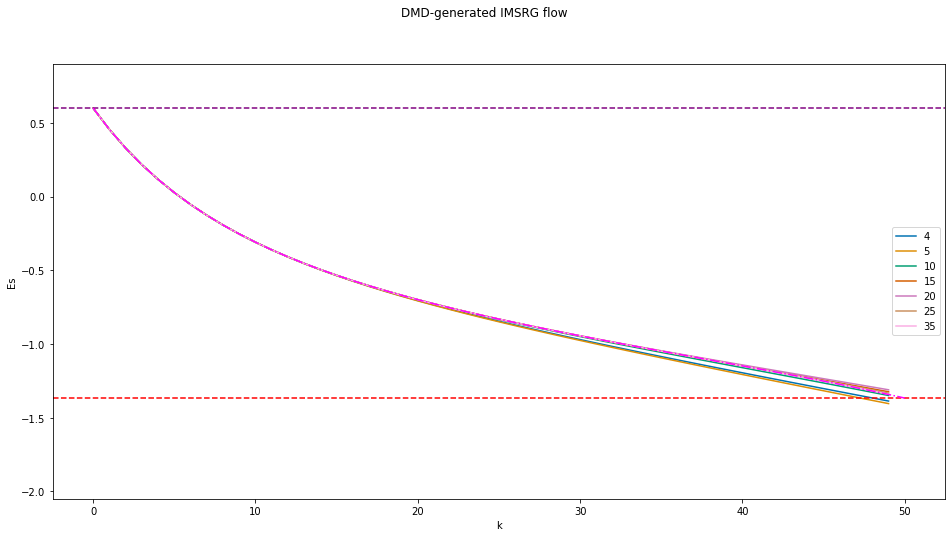

In [14]:
H0 = ts_imsrg_data[:,0]
Hf = ts_imsrg_data[:,-1]
print(full_df)

fig,ax = plt.subplots(figsize=(16,8))
sns.lineplot(x="k", y="Es", hue="nobs", data=full_df, ax=ax, palette=sns.color_palette('colorblind', 7))
ax.axhline(H0[0], color='purple', linestyle='--')
ax.axhline(Hf[0], color='red', linestyle='--')
fig.suptitle("DMD-generated IMSRG flow")
sns.lineplot(x=range(ts_imsrg_data.shape[1]), y=ts_imsrg_data[0,:],ax=ax, color='fuchsia', linestyle='-.')
ax.set_ylim([Hf[0]*1.5,H0[0]*1.50])

### Things to note:

- IMSRG coefficient vectors are very big (in the above case, >4000). The reduced DMD operator is very small in comparison (3x3 or 5x5). 
- The DMD eigenvalues are constructed from the data matrix $X'$. 
- Varying $k$ just demonstrates how repeated applications of DMD reproduces a "flow". Each $k$ takes approximately the same time to solve, and in practical applications we only need to take $k$ large to get a complete flow result.

In [15]:
def GVM(E,f,Gamma, rho1b, rho2b):
    H2B = Gamma
    H1B = f - np.einsum('piqj,ij->pq',H2B, rho1b) #0.5*(np.einsum('piqj,ij->pq', H2B, rho1b) - np.einsum('pijq,ij->pq', H2B, rho1b))

    contract_1b = np.einsum('ij,ij->', rho1b, H1B)

    contract_2b = np.einsum('ijkl,ijkl->', rho2b, H2B)

    H0B = E - contract_1b - 0.25*contract_2b

    return (H0B, H1B, H2B)

In [16]:
from pyci.density_matrix.density_matrix import density_1b, density_2b
ts_imsrg_data_test = get_log_data('flow/H08-1.00-1.40-0.40-0.00-5.00-0.10.log', imsrg=True)

rho1b = density_1b(4,4,weights=np.append([1.0], np.zeros(35)))
rho2b = density_2b(4,4,weights=np.append([1.0], np.zeros(35)))

nobs = 20
X = ts_imsrg_data[:, 0:nobs-1]
Xp = ts_imsrg_data[:, 1:nobs]

H0 = ts_imsrg_data[:,0]
Hf = ts_imsrg_data[:,-1]
phi, dmd_eig, b = dmd(X, Xp, exact=False, r=5, k=50, as_matrix=True)
# Hs = dmd(X, Xp, exact=False, r=5, k=k)
Hs = phi@np.linalg.matrix_power(dmd_eig,k)@b
Hs = np.real(Hs)

E0, f0, Gamma0 = H0[0], np.reshape(H0[1:8**2+1],(8,8)), np.reshape(H0[1+8**2:1+8**2+8**4],(8,8,8,8))
Ef, ff, Gammaf = Hf[0], np.reshape(Hf[1:8**2+1],(8,8)), np.reshape(Hf[1+8**2:1+8**2+8**4],(8,8,8,8))
Es, fs, Gammas = Hs[0], np.reshape(Hs[1:8**2+1],(8,8)), np.reshape(Hs[1+8**2:1+8**2+8**4],(8,8,8,8))
print(E0, f0.shape, Gamma0.shape, rho1b.shape, rho2b.shape)
h0b0,h1b0,h2b0 = GVM(E0,f0,Gamma0,rho1b,rho2b)
h0bf,h1bf,h2bf = GVM(Ef,ff,Gammaf,rho1b,rho2b)
h0bs,h1bs,h2bs = GVM(Es,fs,Gammas,rho1b,rho2b)

hme0 = pyci.matrix(4,4,h0b0,h1b0,h2b0,h2b0,imsrg=True)
hmef = pyci.matrix(4,4,h0bf,h1bf,h2bf,h2bf,imsrg=True)
hmes = pyci.matrix(4,4,h0bs,h1bs,h2bs,h2bs,imsrg=True)

w0,v0 = np.linalg.eigh(hme0)
wf,vf = np.linalg.eigh(hmef)
ws,vs = np.linalg.eigh(hmes)

print("H0 -- E0 = {:8.4f}, w0 = {:8.4f}".format(E0, w0[0]))
print("Hf -- Ef = {:8.4f}, wf = {:8.4f}".format(Ef, wf[0]))
print("Hs -- Es = {:8.4f}, ws = {:8.4f}".format(Es, ws[0]))

(5, 5)
phi,  (4161, 5)
b  (5,)
Hs,  (4161,)
0.6 (8, 8) (8, 8, 8, 8) (8, 8) (8, 8, 8, 8)
H0 -- E0 =   0.6000, w0 =  -0.3118
Hf -- Ef =  -1.3667, wf =  -3.6801
Hs -- Es =  -1.3098, ws =  -3.5063


The DMD operator contains the information relevant to divergence in the IMSRG. The DMD expansion emulates the divergence in the flow.

### Constructing DMD for a real system

#### IMSRG production code to compute O16, eMax=6. 

There are ~400,000 matrix elements per observation. We collect state vectors at timesteps $\Delta s$=0.1, 0.05. We can compute the DMD operator exactly for this size data, but the randomized SVD approach gives similar results. The DMD expansion is able to capture the flow in $E$ precisely, and the emulation is especially potent for smaller step widths. Interestingly, the DMD-driven IMSRG emulates the IMSRG solution more precisely for

#### Note on sequential, constant time steps

There is no *a priori* assumption in the Koopman operator formalism that timesteps are a constant width. However, when approximating the Koopman operator via DMD, it seems that uneven timesteps can sometimes give more weight to less relevant DMD modes within the DMD expansion, which ultimately causes the expansion to diverge for large $k$. Knowing this, try to keep the observation columns equally spaced in time.

In [17]:
# Run DMD on time series data (IMSRG COEFFICIENT VECTORS). 
# Flow to k=50, which extrapolates to s=5.0
from IPython.display import display, clear_output
# ts_imsrg_data = get_log_data('flow/H08-1.00-1.40-0.40-0.00-5.00-0.10.log', imsrg=True)
# ts_imsrg_data = get_log_data('flow/H08-1.00-0.50-0.10-0.00-5.00-0.10.imsrg.log', imsrg=True)

nobs_list = [10,15,20,25,30,40,50,60,70,80]
ds = 0.05
df_list = []
for nobs in nobs_list:
    nobs = nobs
    X = real_imsrg_data[:, :nobs]
    Xp = real_imsrg_data[:, 1:nobs+1]

    H0 = real_imsrg_data[:,0]
    Hf = real_imsrg_data[:,-1]

    phi,dmd_eig,b = dmd(X, Xp, exact=False, 
                               r=nobs, 
                               randomize=True,
                               n_components=min(nobs,10),
                               as_matrix=True)
    print(np.diag(dmd_eig))

    kvals = range(0,150,2)
    for k in kvals:
        string = "# OBSERVATIONS={:02d}\nRUNNING ON K={:02d}".format(nobs,k)
        # clear_output(wait=True)
        display(string)
        s = k*ds
        Hs = phi@np.linalg.matrix_power(dmd_eig,k)@b
        Hs = np.real(Hs)
        row = pd.DataFrame([
                            [nobs, k, s, H0[0], Hf[0], Hs[0]]
                           ], 
                           columns=["nobs", "k", "s", "E0", "Ef", "Es"])
        df_list.append(row)
full_df = pd.concat(df_list, ignore_index=True)



trying randomized SVD


/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


(467133, 10)
(10, 10)
phi,  (467133, 10)
b  (10,)
Hs,  (467133,)
[ 1.00000756+0.j          0.97704605+0.j          0.96295145+0.j
  0.91735999+0.j          0.08202276+0.86343554j  0.08202276-0.86343554j
 -0.79984932+0.26929306j -0.79984932-0.26929306j -0.47467795+0.70693484j
 -0.47467795-0.70693484j]


'# OBSERVATIONS=10\nRUNNING ON K=00'

'# OBSERVATIONS=10\nRUNNING ON K=02'

'# OBSERVATIONS=10\nRUNNING ON K=04'

'# OBSERVATIONS=10\nRUNNING ON K=06'

'# OBSERVATIONS=10\nRUNNING ON K=08'

'# OBSERVATIONS=10\nRUNNING ON K=10'

'# OBSERVATIONS=10\nRUNNING ON K=12'

'# OBSERVATIONS=10\nRUNNING ON K=14'

'# OBSERVATIONS=10\nRUNNING ON K=16'

'# OBSERVATIONS=10\nRUNNING ON K=18'

'# OBSERVATIONS=10\nRUNNING ON K=20'

'# OBSERVATIONS=10\nRUNNING ON K=22'

'# OBSERVATIONS=10\nRUNNING ON K=24'

'# OBSERVATIONS=10\nRUNNING ON K=26'

'# OBSERVATIONS=10\nRUNNING ON K=28'

'# OBSERVATIONS=10\nRUNNING ON K=30'

'# OBSERVATIONS=10\nRUNNING ON K=32'

'# OBSERVATIONS=10\nRUNNING ON K=34'

'# OBSERVATIONS=10\nRUNNING ON K=36'

'# OBSERVATIONS=10\nRUNNING ON K=38'

'# OBSERVATIONS=10\nRUNNING ON K=40'

'# OBSERVATIONS=10\nRUNNING ON K=42'

'# OBSERVATIONS=10\nRUNNING ON K=44'

'# OBSERVATIONS=10\nRUNNING ON K=46'

'# OBSERVATIONS=10\nRUNNING ON K=48'

'# OBSERVATIONS=10\nRUNNING ON K=50'

'# OBSERVATIONS=10\nRUNNING ON K=52'

'# OBSERVATIONS=10\nRUNNING ON K=54'

'# OBSERVATIONS=10\nRUNNING ON K=56'

'# OBSERVATIONS=10\nRUNNING ON K=58'

'# OBSERVATIONS=10\nRUNNING ON K=60'

'# OBSERVATIONS=10\nRUNNING ON K=62'

'# OBSERVATIONS=10\nRUNNING ON K=64'

'# OBSERVATIONS=10\nRUNNING ON K=66'

'# OBSERVATIONS=10\nRUNNING ON K=68'

'# OBSERVATIONS=10\nRUNNING ON K=70'

'# OBSERVATIONS=10\nRUNNING ON K=72'

'# OBSERVATIONS=10\nRUNNING ON K=74'

'# OBSERVATIONS=10\nRUNNING ON K=76'

'# OBSERVATIONS=10\nRUNNING ON K=78'

'# OBSERVATIONS=10\nRUNNING ON K=80'

'# OBSERVATIONS=10\nRUNNING ON K=82'

'# OBSERVATIONS=10\nRUNNING ON K=84'

'# OBSERVATIONS=10\nRUNNING ON K=86'

'# OBSERVATIONS=10\nRUNNING ON K=88'

'# OBSERVATIONS=10\nRUNNING ON K=90'

'# OBSERVATIONS=10\nRUNNING ON K=92'

'# OBSERVATIONS=10\nRUNNING ON K=94'

'# OBSERVATIONS=10\nRUNNING ON K=96'

'# OBSERVATIONS=10\nRUNNING ON K=98'

'# OBSERVATIONS=10\nRUNNING ON K=100'

'# OBSERVATIONS=10\nRUNNING ON K=102'

'# OBSERVATIONS=10\nRUNNING ON K=104'

'# OBSERVATIONS=10\nRUNNING ON K=106'

'# OBSERVATIONS=10\nRUNNING ON K=108'

'# OBSERVATIONS=10\nRUNNING ON K=110'

'# OBSERVATIONS=10\nRUNNING ON K=112'

'# OBSERVATIONS=10\nRUNNING ON K=114'

'# OBSERVATIONS=10\nRUNNING ON K=116'

'# OBSERVATIONS=10\nRUNNING ON K=118'

'# OBSERVATIONS=10\nRUNNING ON K=120'

'# OBSERVATIONS=10\nRUNNING ON K=122'

'# OBSERVATIONS=10\nRUNNING ON K=124'

'# OBSERVATIONS=10\nRUNNING ON K=126'

'# OBSERVATIONS=10\nRUNNING ON K=128'

'# OBSERVATIONS=10\nRUNNING ON K=130'

'# OBSERVATIONS=10\nRUNNING ON K=132'

'# OBSERVATIONS=10\nRUNNING ON K=134'

'# OBSERVATIONS=10\nRUNNING ON K=136'

'# OBSERVATIONS=10\nRUNNING ON K=138'

'# OBSERVATIONS=10\nRUNNING ON K=140'

'# OBSERVATIONS=10\nRUNNING ON K=142'

'# OBSERVATIONS=10\nRUNNING ON K=144'

'# OBSERVATIONS=10\nRUNNING ON K=146'

'# OBSERVATIONS=10\nRUNNING ON K=148'

trying randomized SVD
(467133, 10)
(10, 10)
phi,  (467133, 10)
b  (10,)
Hs,  (467133,)
[ 1.00001293+0.j          0.97823733+0.j          0.9734051 +0.j
  0.92605396+0.j          0.22221667+0.70023047j  0.22221667-0.70023047j
  0.46007033+0.j         -0.61329607+0.j         -0.45420414+0.19108757j
 -0.45420414-0.19108757j]


'# OBSERVATIONS=15\nRUNNING ON K=00'

'# OBSERVATIONS=15\nRUNNING ON K=02'

'# OBSERVATIONS=15\nRUNNING ON K=04'

'# OBSERVATIONS=15\nRUNNING ON K=06'

'# OBSERVATIONS=15\nRUNNING ON K=08'

'# OBSERVATIONS=15\nRUNNING ON K=10'

'# OBSERVATIONS=15\nRUNNING ON K=12'

'# OBSERVATIONS=15\nRUNNING ON K=14'

'# OBSERVATIONS=15\nRUNNING ON K=16'

'# OBSERVATIONS=15\nRUNNING ON K=18'

'# OBSERVATIONS=15\nRUNNING ON K=20'

'# OBSERVATIONS=15\nRUNNING ON K=22'

'# OBSERVATIONS=15\nRUNNING ON K=24'

'# OBSERVATIONS=15\nRUNNING ON K=26'

'# OBSERVATIONS=15\nRUNNING ON K=28'

'# OBSERVATIONS=15\nRUNNING ON K=30'

'# OBSERVATIONS=15\nRUNNING ON K=32'

'# OBSERVATIONS=15\nRUNNING ON K=34'

'# OBSERVATIONS=15\nRUNNING ON K=36'

'# OBSERVATIONS=15\nRUNNING ON K=38'

'# OBSERVATIONS=15\nRUNNING ON K=40'

'# OBSERVATIONS=15\nRUNNING ON K=42'

'# OBSERVATIONS=15\nRUNNING ON K=44'

'# OBSERVATIONS=15\nRUNNING ON K=46'

'# OBSERVATIONS=15\nRUNNING ON K=48'

'# OBSERVATIONS=15\nRUNNING ON K=50'

'# OBSERVATIONS=15\nRUNNING ON K=52'

'# OBSERVATIONS=15\nRUNNING ON K=54'

'# OBSERVATIONS=15\nRUNNING ON K=56'

'# OBSERVATIONS=15\nRUNNING ON K=58'

'# OBSERVATIONS=15\nRUNNING ON K=60'

'# OBSERVATIONS=15\nRUNNING ON K=62'

'# OBSERVATIONS=15\nRUNNING ON K=64'

'# OBSERVATIONS=15\nRUNNING ON K=66'

'# OBSERVATIONS=15\nRUNNING ON K=68'

'# OBSERVATIONS=15\nRUNNING ON K=70'

'# OBSERVATIONS=15\nRUNNING ON K=72'

'# OBSERVATIONS=15\nRUNNING ON K=74'

'# OBSERVATIONS=15\nRUNNING ON K=76'

'# OBSERVATIONS=15\nRUNNING ON K=78'

'# OBSERVATIONS=15\nRUNNING ON K=80'

'# OBSERVATIONS=15\nRUNNING ON K=82'

'# OBSERVATIONS=15\nRUNNING ON K=84'

'# OBSERVATIONS=15\nRUNNING ON K=86'

'# OBSERVATIONS=15\nRUNNING ON K=88'

'# OBSERVATIONS=15\nRUNNING ON K=90'

'# OBSERVATIONS=15\nRUNNING ON K=92'

'# OBSERVATIONS=15\nRUNNING ON K=94'

'# OBSERVATIONS=15\nRUNNING ON K=96'

'# OBSERVATIONS=15\nRUNNING ON K=98'

'# OBSERVATIONS=15\nRUNNING ON K=100'

'# OBSERVATIONS=15\nRUNNING ON K=102'

'# OBSERVATIONS=15\nRUNNING ON K=104'

'# OBSERVATIONS=15\nRUNNING ON K=106'

'# OBSERVATIONS=15\nRUNNING ON K=108'

'# OBSERVATIONS=15\nRUNNING ON K=110'

'# OBSERVATIONS=15\nRUNNING ON K=112'

'# OBSERVATIONS=15\nRUNNING ON K=114'

'# OBSERVATIONS=15\nRUNNING ON K=116'

'# OBSERVATIONS=15\nRUNNING ON K=118'

'# OBSERVATIONS=15\nRUNNING ON K=120'

'# OBSERVATIONS=15\nRUNNING ON K=122'

'# OBSERVATIONS=15\nRUNNING ON K=124'

'# OBSERVATIONS=15\nRUNNING ON K=126'

'# OBSERVATIONS=15\nRUNNING ON K=128'

'# OBSERVATIONS=15\nRUNNING ON K=130'

'# OBSERVATIONS=15\nRUNNING ON K=132'

'# OBSERVATIONS=15\nRUNNING ON K=134'

'# OBSERVATIONS=15\nRUNNING ON K=136'

'# OBSERVATIONS=15\nRUNNING ON K=138'

'# OBSERVATIONS=15\nRUNNING ON K=140'

'# OBSERVATIONS=15\nRUNNING ON K=142'

'# OBSERVATIONS=15\nRUNNING ON K=144'

'# OBSERVATIONS=15\nRUNNING ON K=146'

'# OBSERVATIONS=15\nRUNNING ON K=148'

trying randomized SVD
(467133, 10)
(10, 10)
phi,  (467133, 10)
b  (10,)
Hs,  (467133,)
[-0.53383677+0.j          0.0357955 +0.64820973j  0.0357955 -0.64820973j
  1.00000613+0.j          0.97982181+0.j          0.97471247+0.j
  0.9324799 +0.j          0.7773799 +0.j          0.33934549+0.2290609j
  0.33934549-0.2290609j ]


'# OBSERVATIONS=20\nRUNNING ON K=00'

'# OBSERVATIONS=20\nRUNNING ON K=02'

'# OBSERVATIONS=20\nRUNNING ON K=04'

'# OBSERVATIONS=20\nRUNNING ON K=06'

'# OBSERVATIONS=20\nRUNNING ON K=08'

'# OBSERVATIONS=20\nRUNNING ON K=10'

'# OBSERVATIONS=20\nRUNNING ON K=12'

'# OBSERVATIONS=20\nRUNNING ON K=14'

'# OBSERVATIONS=20\nRUNNING ON K=16'

'# OBSERVATIONS=20\nRUNNING ON K=18'

'# OBSERVATIONS=20\nRUNNING ON K=20'

'# OBSERVATIONS=20\nRUNNING ON K=22'

'# OBSERVATIONS=20\nRUNNING ON K=24'

'# OBSERVATIONS=20\nRUNNING ON K=26'

'# OBSERVATIONS=20\nRUNNING ON K=28'

'# OBSERVATIONS=20\nRUNNING ON K=30'

'# OBSERVATIONS=20\nRUNNING ON K=32'

'# OBSERVATIONS=20\nRUNNING ON K=34'

'# OBSERVATIONS=20\nRUNNING ON K=36'

'# OBSERVATIONS=20\nRUNNING ON K=38'

'# OBSERVATIONS=20\nRUNNING ON K=40'

'# OBSERVATIONS=20\nRUNNING ON K=42'

'# OBSERVATIONS=20\nRUNNING ON K=44'

'# OBSERVATIONS=20\nRUNNING ON K=46'

'# OBSERVATIONS=20\nRUNNING ON K=48'

'# OBSERVATIONS=20\nRUNNING ON K=50'

'# OBSERVATIONS=20\nRUNNING ON K=52'

'# OBSERVATIONS=20\nRUNNING ON K=54'

'# OBSERVATIONS=20\nRUNNING ON K=56'

'# OBSERVATIONS=20\nRUNNING ON K=58'

'# OBSERVATIONS=20\nRUNNING ON K=60'

'# OBSERVATIONS=20\nRUNNING ON K=62'

'# OBSERVATIONS=20\nRUNNING ON K=64'

'# OBSERVATIONS=20\nRUNNING ON K=66'

'# OBSERVATIONS=20\nRUNNING ON K=68'

'# OBSERVATIONS=20\nRUNNING ON K=70'

'# OBSERVATIONS=20\nRUNNING ON K=72'

'# OBSERVATIONS=20\nRUNNING ON K=74'

'# OBSERVATIONS=20\nRUNNING ON K=76'

'# OBSERVATIONS=20\nRUNNING ON K=78'

'# OBSERVATIONS=20\nRUNNING ON K=80'

'# OBSERVATIONS=20\nRUNNING ON K=82'

'# OBSERVATIONS=20\nRUNNING ON K=84'

'# OBSERVATIONS=20\nRUNNING ON K=86'

'# OBSERVATIONS=20\nRUNNING ON K=88'

'# OBSERVATIONS=20\nRUNNING ON K=90'

'# OBSERVATIONS=20\nRUNNING ON K=92'

'# OBSERVATIONS=20\nRUNNING ON K=94'

'# OBSERVATIONS=20\nRUNNING ON K=96'

'# OBSERVATIONS=20\nRUNNING ON K=98'

'# OBSERVATIONS=20\nRUNNING ON K=100'

'# OBSERVATIONS=20\nRUNNING ON K=102'

'# OBSERVATIONS=20\nRUNNING ON K=104'

'# OBSERVATIONS=20\nRUNNING ON K=106'

'# OBSERVATIONS=20\nRUNNING ON K=108'

'# OBSERVATIONS=20\nRUNNING ON K=110'

'# OBSERVATIONS=20\nRUNNING ON K=112'

'# OBSERVATIONS=20\nRUNNING ON K=114'

'# OBSERVATIONS=20\nRUNNING ON K=116'

'# OBSERVATIONS=20\nRUNNING ON K=118'

'# OBSERVATIONS=20\nRUNNING ON K=120'

'# OBSERVATIONS=20\nRUNNING ON K=122'

'# OBSERVATIONS=20\nRUNNING ON K=124'

'# OBSERVATIONS=20\nRUNNING ON K=126'

'# OBSERVATIONS=20\nRUNNING ON K=128'

'# OBSERVATIONS=20\nRUNNING ON K=130'

'# OBSERVATIONS=20\nRUNNING ON K=132'

'# OBSERVATIONS=20\nRUNNING ON K=134'

'# OBSERVATIONS=20\nRUNNING ON K=136'

'# OBSERVATIONS=20\nRUNNING ON K=138'

'# OBSERVATIONS=20\nRUNNING ON K=140'

'# OBSERVATIONS=20\nRUNNING ON K=142'

'# OBSERVATIONS=20\nRUNNING ON K=144'

'# OBSERVATIONS=20\nRUNNING ON K=146'

'# OBSERVATIONS=20\nRUNNING ON K=148'

trying randomized SVD
(467133, 10)
(10, 10)
phi,  (467133, 10)
b  (10,)
Hs,  (467133,)
[-0.13677613+0.360968j   -0.13677613-0.360968j    0.99999912+0.j
  0.98174026+0.j          0.9759729 +0.j          0.94219723+0.j
  0.8738827 +0.j          0.37312826+0.31594834j  0.37312826-0.31594834j
  0.46433828+0.j        ]


'# OBSERVATIONS=25\nRUNNING ON K=00'

'# OBSERVATIONS=25\nRUNNING ON K=02'

'# OBSERVATIONS=25\nRUNNING ON K=04'

'# OBSERVATIONS=25\nRUNNING ON K=06'

'# OBSERVATIONS=25\nRUNNING ON K=08'

'# OBSERVATIONS=25\nRUNNING ON K=10'

'# OBSERVATIONS=25\nRUNNING ON K=12'

'# OBSERVATIONS=25\nRUNNING ON K=14'

'# OBSERVATIONS=25\nRUNNING ON K=16'

'# OBSERVATIONS=25\nRUNNING ON K=18'

'# OBSERVATIONS=25\nRUNNING ON K=20'

'# OBSERVATIONS=25\nRUNNING ON K=22'

'# OBSERVATIONS=25\nRUNNING ON K=24'

'# OBSERVATIONS=25\nRUNNING ON K=26'

'# OBSERVATIONS=25\nRUNNING ON K=28'

'# OBSERVATIONS=25\nRUNNING ON K=30'

'# OBSERVATIONS=25\nRUNNING ON K=32'

'# OBSERVATIONS=25\nRUNNING ON K=34'

'# OBSERVATIONS=25\nRUNNING ON K=36'

'# OBSERVATIONS=25\nRUNNING ON K=38'

'# OBSERVATIONS=25\nRUNNING ON K=40'

'# OBSERVATIONS=25\nRUNNING ON K=42'

'# OBSERVATIONS=25\nRUNNING ON K=44'

'# OBSERVATIONS=25\nRUNNING ON K=46'

'# OBSERVATIONS=25\nRUNNING ON K=48'

'# OBSERVATIONS=25\nRUNNING ON K=50'

'# OBSERVATIONS=25\nRUNNING ON K=52'

'# OBSERVATIONS=25\nRUNNING ON K=54'

'# OBSERVATIONS=25\nRUNNING ON K=56'

'# OBSERVATIONS=25\nRUNNING ON K=58'

'# OBSERVATIONS=25\nRUNNING ON K=60'

'# OBSERVATIONS=25\nRUNNING ON K=62'

'# OBSERVATIONS=25\nRUNNING ON K=64'

'# OBSERVATIONS=25\nRUNNING ON K=66'

'# OBSERVATIONS=25\nRUNNING ON K=68'

'# OBSERVATIONS=25\nRUNNING ON K=70'

'# OBSERVATIONS=25\nRUNNING ON K=72'

'# OBSERVATIONS=25\nRUNNING ON K=74'

'# OBSERVATIONS=25\nRUNNING ON K=76'

'# OBSERVATIONS=25\nRUNNING ON K=78'

'# OBSERVATIONS=25\nRUNNING ON K=80'

'# OBSERVATIONS=25\nRUNNING ON K=82'

'# OBSERVATIONS=25\nRUNNING ON K=84'

'# OBSERVATIONS=25\nRUNNING ON K=86'

'# OBSERVATIONS=25\nRUNNING ON K=88'

'# OBSERVATIONS=25\nRUNNING ON K=90'

'# OBSERVATIONS=25\nRUNNING ON K=92'

'# OBSERVATIONS=25\nRUNNING ON K=94'

'# OBSERVATIONS=25\nRUNNING ON K=96'

'# OBSERVATIONS=25\nRUNNING ON K=98'

'# OBSERVATIONS=25\nRUNNING ON K=100'

'# OBSERVATIONS=25\nRUNNING ON K=102'

'# OBSERVATIONS=25\nRUNNING ON K=104'

'# OBSERVATIONS=25\nRUNNING ON K=106'

'# OBSERVATIONS=25\nRUNNING ON K=108'

'# OBSERVATIONS=25\nRUNNING ON K=110'

'# OBSERVATIONS=25\nRUNNING ON K=112'

'# OBSERVATIONS=25\nRUNNING ON K=114'

'# OBSERVATIONS=25\nRUNNING ON K=116'

'# OBSERVATIONS=25\nRUNNING ON K=118'

'# OBSERVATIONS=25\nRUNNING ON K=120'

'# OBSERVATIONS=25\nRUNNING ON K=122'

'# OBSERVATIONS=25\nRUNNING ON K=124'

'# OBSERVATIONS=25\nRUNNING ON K=126'

'# OBSERVATIONS=25\nRUNNING ON K=128'

'# OBSERVATIONS=25\nRUNNING ON K=130'

'# OBSERVATIONS=25\nRUNNING ON K=132'

'# OBSERVATIONS=25\nRUNNING ON K=134'

'# OBSERVATIONS=25\nRUNNING ON K=136'

'# OBSERVATIONS=25\nRUNNING ON K=138'

'# OBSERVATIONS=25\nRUNNING ON K=140'

'# OBSERVATIONS=25\nRUNNING ON K=142'

'# OBSERVATIONS=25\nRUNNING ON K=144'

'# OBSERVATIONS=25\nRUNNING ON K=146'

'# OBSERVATIONS=25\nRUNNING ON K=148'

trying randomized SVD
(467133, 10)
(10, 10)
phi,  (467133, 10)
b  (10,)
Hs,  (467133,)
[-0.35208503+0.j          0.99999369+0.j          0.98348878+0.j
  0.97373442+0.j          0.95401234+0.j          0.89739203+0.j
  0.65448887+0.j          0.17767617+0.35960331j  0.17767617-0.35960331j
  0.18467791+0.j        ]


'# OBSERVATIONS=30\nRUNNING ON K=00'

'# OBSERVATIONS=30\nRUNNING ON K=02'

'# OBSERVATIONS=30\nRUNNING ON K=04'

'# OBSERVATIONS=30\nRUNNING ON K=06'

'# OBSERVATIONS=30\nRUNNING ON K=08'

'# OBSERVATIONS=30\nRUNNING ON K=10'

'# OBSERVATIONS=30\nRUNNING ON K=12'

'# OBSERVATIONS=30\nRUNNING ON K=14'

'# OBSERVATIONS=30\nRUNNING ON K=16'

'# OBSERVATIONS=30\nRUNNING ON K=18'

'# OBSERVATIONS=30\nRUNNING ON K=20'

'# OBSERVATIONS=30\nRUNNING ON K=22'

'# OBSERVATIONS=30\nRUNNING ON K=24'

'# OBSERVATIONS=30\nRUNNING ON K=26'

'# OBSERVATIONS=30\nRUNNING ON K=28'

'# OBSERVATIONS=30\nRUNNING ON K=30'

'# OBSERVATIONS=30\nRUNNING ON K=32'

'# OBSERVATIONS=30\nRUNNING ON K=34'

'# OBSERVATIONS=30\nRUNNING ON K=36'

'# OBSERVATIONS=30\nRUNNING ON K=38'

'# OBSERVATIONS=30\nRUNNING ON K=40'

'# OBSERVATIONS=30\nRUNNING ON K=42'

'# OBSERVATIONS=30\nRUNNING ON K=44'

'# OBSERVATIONS=30\nRUNNING ON K=46'

'# OBSERVATIONS=30\nRUNNING ON K=48'

'# OBSERVATIONS=30\nRUNNING ON K=50'

'# OBSERVATIONS=30\nRUNNING ON K=52'

'# OBSERVATIONS=30\nRUNNING ON K=54'

'# OBSERVATIONS=30\nRUNNING ON K=56'

'# OBSERVATIONS=30\nRUNNING ON K=58'

'# OBSERVATIONS=30\nRUNNING ON K=60'

'# OBSERVATIONS=30\nRUNNING ON K=62'

'# OBSERVATIONS=30\nRUNNING ON K=64'

'# OBSERVATIONS=30\nRUNNING ON K=66'

'# OBSERVATIONS=30\nRUNNING ON K=68'

'# OBSERVATIONS=30\nRUNNING ON K=70'

'# OBSERVATIONS=30\nRUNNING ON K=72'

'# OBSERVATIONS=30\nRUNNING ON K=74'

'# OBSERVATIONS=30\nRUNNING ON K=76'

'# OBSERVATIONS=30\nRUNNING ON K=78'

'# OBSERVATIONS=30\nRUNNING ON K=80'

'# OBSERVATIONS=30\nRUNNING ON K=82'

'# OBSERVATIONS=30\nRUNNING ON K=84'

'# OBSERVATIONS=30\nRUNNING ON K=86'

'# OBSERVATIONS=30\nRUNNING ON K=88'

'# OBSERVATIONS=30\nRUNNING ON K=90'

'# OBSERVATIONS=30\nRUNNING ON K=92'

'# OBSERVATIONS=30\nRUNNING ON K=94'

'# OBSERVATIONS=30\nRUNNING ON K=96'

'# OBSERVATIONS=30\nRUNNING ON K=98'

'# OBSERVATIONS=30\nRUNNING ON K=100'

'# OBSERVATIONS=30\nRUNNING ON K=102'

'# OBSERVATIONS=30\nRUNNING ON K=104'

'# OBSERVATIONS=30\nRUNNING ON K=106'

'# OBSERVATIONS=30\nRUNNING ON K=108'

'# OBSERVATIONS=30\nRUNNING ON K=110'

'# OBSERVATIONS=30\nRUNNING ON K=112'

'# OBSERVATIONS=30\nRUNNING ON K=114'

'# OBSERVATIONS=30\nRUNNING ON K=116'

'# OBSERVATIONS=30\nRUNNING ON K=118'

'# OBSERVATIONS=30\nRUNNING ON K=120'

'# OBSERVATIONS=30\nRUNNING ON K=122'

'# OBSERVATIONS=30\nRUNNING ON K=124'

'# OBSERVATIONS=30\nRUNNING ON K=126'

'# OBSERVATIONS=30\nRUNNING ON K=128'

'# OBSERVATIONS=30\nRUNNING ON K=130'

'# OBSERVATIONS=30\nRUNNING ON K=132'

'# OBSERVATIONS=30\nRUNNING ON K=134'

'# OBSERVATIONS=30\nRUNNING ON K=136'

'# OBSERVATIONS=30\nRUNNING ON K=138'

'# OBSERVATIONS=30\nRUNNING ON K=140'

'# OBSERVATIONS=30\nRUNNING ON K=142'

'# OBSERVATIONS=30\nRUNNING ON K=144'

'# OBSERVATIONS=30\nRUNNING ON K=146'

'# OBSERVATIONS=30\nRUNNING ON K=148'

trying randomized SVD
(467133, 10)
(10, 10)
phi,  (467133, 10)
b  (10,)
Hs,  (467133,)
[ 0.99999213+0.j          0.98468697+0.j          0.97135072+0.00864895j
  0.97135072-0.00864895j  0.92852655+0.j          0.84238357+0.j
 -0.11176167+0.j          0.51683712+0.j          0.32119846+0.j
  0.20468317+0.j        ]


'# OBSERVATIONS=40\nRUNNING ON K=00'

'# OBSERVATIONS=40\nRUNNING ON K=02'

'# OBSERVATIONS=40\nRUNNING ON K=04'

'# OBSERVATIONS=40\nRUNNING ON K=06'

'# OBSERVATIONS=40\nRUNNING ON K=08'

'# OBSERVATIONS=40\nRUNNING ON K=10'

'# OBSERVATIONS=40\nRUNNING ON K=12'

'# OBSERVATIONS=40\nRUNNING ON K=14'

'# OBSERVATIONS=40\nRUNNING ON K=16'

'# OBSERVATIONS=40\nRUNNING ON K=18'

'# OBSERVATIONS=40\nRUNNING ON K=20'

'# OBSERVATIONS=40\nRUNNING ON K=22'

'# OBSERVATIONS=40\nRUNNING ON K=24'

'# OBSERVATIONS=40\nRUNNING ON K=26'

'# OBSERVATIONS=40\nRUNNING ON K=28'

'# OBSERVATIONS=40\nRUNNING ON K=30'

'# OBSERVATIONS=40\nRUNNING ON K=32'

'# OBSERVATIONS=40\nRUNNING ON K=34'

'# OBSERVATIONS=40\nRUNNING ON K=36'

'# OBSERVATIONS=40\nRUNNING ON K=38'

'# OBSERVATIONS=40\nRUNNING ON K=40'

'# OBSERVATIONS=40\nRUNNING ON K=42'

'# OBSERVATIONS=40\nRUNNING ON K=44'

'# OBSERVATIONS=40\nRUNNING ON K=46'

'# OBSERVATIONS=40\nRUNNING ON K=48'

'# OBSERVATIONS=40\nRUNNING ON K=50'

'# OBSERVATIONS=40\nRUNNING ON K=52'

'# OBSERVATIONS=40\nRUNNING ON K=54'

'# OBSERVATIONS=40\nRUNNING ON K=56'

'# OBSERVATIONS=40\nRUNNING ON K=58'

'# OBSERVATIONS=40\nRUNNING ON K=60'

'# OBSERVATIONS=40\nRUNNING ON K=62'

'# OBSERVATIONS=40\nRUNNING ON K=64'

'# OBSERVATIONS=40\nRUNNING ON K=66'

'# OBSERVATIONS=40\nRUNNING ON K=68'

'# OBSERVATIONS=40\nRUNNING ON K=70'

'# OBSERVATIONS=40\nRUNNING ON K=72'

'# OBSERVATIONS=40\nRUNNING ON K=74'

'# OBSERVATIONS=40\nRUNNING ON K=76'

'# OBSERVATIONS=40\nRUNNING ON K=78'

'# OBSERVATIONS=40\nRUNNING ON K=80'

'# OBSERVATIONS=40\nRUNNING ON K=82'

'# OBSERVATIONS=40\nRUNNING ON K=84'

'# OBSERVATIONS=40\nRUNNING ON K=86'

'# OBSERVATIONS=40\nRUNNING ON K=88'

'# OBSERVATIONS=40\nRUNNING ON K=90'

'# OBSERVATIONS=40\nRUNNING ON K=92'

'# OBSERVATIONS=40\nRUNNING ON K=94'

'# OBSERVATIONS=40\nRUNNING ON K=96'

'# OBSERVATIONS=40\nRUNNING ON K=98'

'# OBSERVATIONS=40\nRUNNING ON K=100'

'# OBSERVATIONS=40\nRUNNING ON K=102'

'# OBSERVATIONS=40\nRUNNING ON K=104'

'# OBSERVATIONS=40\nRUNNING ON K=106'

'# OBSERVATIONS=40\nRUNNING ON K=108'

'# OBSERVATIONS=40\nRUNNING ON K=110'

'# OBSERVATIONS=40\nRUNNING ON K=112'

'# OBSERVATIONS=40\nRUNNING ON K=114'

'# OBSERVATIONS=40\nRUNNING ON K=116'

'# OBSERVATIONS=40\nRUNNING ON K=118'

'# OBSERVATIONS=40\nRUNNING ON K=120'

'# OBSERVATIONS=40\nRUNNING ON K=122'

'# OBSERVATIONS=40\nRUNNING ON K=124'

'# OBSERVATIONS=40\nRUNNING ON K=126'

'# OBSERVATIONS=40\nRUNNING ON K=128'

'# OBSERVATIONS=40\nRUNNING ON K=130'

'# OBSERVATIONS=40\nRUNNING ON K=132'

'# OBSERVATIONS=40\nRUNNING ON K=134'

'# OBSERVATIONS=40\nRUNNING ON K=136'

'# OBSERVATIONS=40\nRUNNING ON K=138'

'# OBSERVATIONS=40\nRUNNING ON K=140'

'# OBSERVATIONS=40\nRUNNING ON K=142'

'# OBSERVATIONS=40\nRUNNING ON K=144'

'# OBSERVATIONS=40\nRUNNING ON K=146'

'# OBSERVATIONS=40\nRUNNING ON K=148'

trying randomized SVD
(467133, 10)
(10, 10)
phi,  (467133, 10)
b  (10,)
Hs,  (467133,)
[0.06608451+0.j         0.24887724+0.j         0.74258036+0.23290706j
 0.74258036-0.23290706j 0.99999739+0.j         0.98774939+0.j
 0.97764056+0.j         0.960457  +0.j         0.93382922+0.j
 0.85440095+0.j        ]


'# OBSERVATIONS=50\nRUNNING ON K=00'

'# OBSERVATIONS=50\nRUNNING ON K=02'

'# OBSERVATIONS=50\nRUNNING ON K=04'

'# OBSERVATIONS=50\nRUNNING ON K=06'

'# OBSERVATIONS=50\nRUNNING ON K=08'

'# OBSERVATIONS=50\nRUNNING ON K=10'

'# OBSERVATIONS=50\nRUNNING ON K=12'

'# OBSERVATIONS=50\nRUNNING ON K=14'

'# OBSERVATIONS=50\nRUNNING ON K=16'

'# OBSERVATIONS=50\nRUNNING ON K=18'

'# OBSERVATIONS=50\nRUNNING ON K=20'

'# OBSERVATIONS=50\nRUNNING ON K=22'

'# OBSERVATIONS=50\nRUNNING ON K=24'

'# OBSERVATIONS=50\nRUNNING ON K=26'

'# OBSERVATIONS=50\nRUNNING ON K=28'

'# OBSERVATIONS=50\nRUNNING ON K=30'

'# OBSERVATIONS=50\nRUNNING ON K=32'

'# OBSERVATIONS=50\nRUNNING ON K=34'

'# OBSERVATIONS=50\nRUNNING ON K=36'

'# OBSERVATIONS=50\nRUNNING ON K=38'

'# OBSERVATIONS=50\nRUNNING ON K=40'

'# OBSERVATIONS=50\nRUNNING ON K=42'

'# OBSERVATIONS=50\nRUNNING ON K=44'

'# OBSERVATIONS=50\nRUNNING ON K=46'

'# OBSERVATIONS=50\nRUNNING ON K=48'

'# OBSERVATIONS=50\nRUNNING ON K=50'

'# OBSERVATIONS=50\nRUNNING ON K=52'

'# OBSERVATIONS=50\nRUNNING ON K=54'

'# OBSERVATIONS=50\nRUNNING ON K=56'

'# OBSERVATIONS=50\nRUNNING ON K=58'

'# OBSERVATIONS=50\nRUNNING ON K=60'

'# OBSERVATIONS=50\nRUNNING ON K=62'

'# OBSERVATIONS=50\nRUNNING ON K=64'

'# OBSERVATIONS=50\nRUNNING ON K=66'

'# OBSERVATIONS=50\nRUNNING ON K=68'

'# OBSERVATIONS=50\nRUNNING ON K=70'

'# OBSERVATIONS=50\nRUNNING ON K=72'

'# OBSERVATIONS=50\nRUNNING ON K=74'

'# OBSERVATIONS=50\nRUNNING ON K=76'

'# OBSERVATIONS=50\nRUNNING ON K=78'

'# OBSERVATIONS=50\nRUNNING ON K=80'

'# OBSERVATIONS=50\nRUNNING ON K=82'

'# OBSERVATIONS=50\nRUNNING ON K=84'

'# OBSERVATIONS=50\nRUNNING ON K=86'

'# OBSERVATIONS=50\nRUNNING ON K=88'

'# OBSERVATIONS=50\nRUNNING ON K=90'

'# OBSERVATIONS=50\nRUNNING ON K=92'

'# OBSERVATIONS=50\nRUNNING ON K=94'

'# OBSERVATIONS=50\nRUNNING ON K=96'

'# OBSERVATIONS=50\nRUNNING ON K=98'

'# OBSERVATIONS=50\nRUNNING ON K=100'

'# OBSERVATIONS=50\nRUNNING ON K=102'

'# OBSERVATIONS=50\nRUNNING ON K=104'

'# OBSERVATIONS=50\nRUNNING ON K=106'

'# OBSERVATIONS=50\nRUNNING ON K=108'

'# OBSERVATIONS=50\nRUNNING ON K=110'

'# OBSERVATIONS=50\nRUNNING ON K=112'

'# OBSERVATIONS=50\nRUNNING ON K=114'

'# OBSERVATIONS=50\nRUNNING ON K=116'

'# OBSERVATIONS=50\nRUNNING ON K=118'

'# OBSERVATIONS=50\nRUNNING ON K=120'

'# OBSERVATIONS=50\nRUNNING ON K=122'

'# OBSERVATIONS=50\nRUNNING ON K=124'

'# OBSERVATIONS=50\nRUNNING ON K=126'

'# OBSERVATIONS=50\nRUNNING ON K=128'

'# OBSERVATIONS=50\nRUNNING ON K=130'

'# OBSERVATIONS=50\nRUNNING ON K=132'

'# OBSERVATIONS=50\nRUNNING ON K=134'

'# OBSERVATIONS=50\nRUNNING ON K=136'

'# OBSERVATIONS=50\nRUNNING ON K=138'

'# OBSERVATIONS=50\nRUNNING ON K=140'

'# OBSERVATIONS=50\nRUNNING ON K=142'

'# OBSERVATIONS=50\nRUNNING ON K=144'

'# OBSERVATIONS=50\nRUNNING ON K=146'

'# OBSERVATIONS=50\nRUNNING ON K=148'

trying randomized SVD
(467133, 10)
(10, 10)
phi,  (467133, 10)
b  (10,)
Hs,  (467133,)
[0.526013  +0.j         0.69275788+0.j         0.9999983 +0.j
 0.98649094+0.j         0.97943856+0.00510365j 0.97943856-0.00510365j
 0.94920842+0.j         0.88826511+0.j         0.81140526+0.2059319j
 0.81140526-0.2059319j ]


'# OBSERVATIONS=60\nRUNNING ON K=00'

'# OBSERVATIONS=60\nRUNNING ON K=02'

'# OBSERVATIONS=60\nRUNNING ON K=04'

'# OBSERVATIONS=60\nRUNNING ON K=06'

'# OBSERVATIONS=60\nRUNNING ON K=08'

'# OBSERVATIONS=60\nRUNNING ON K=10'

'# OBSERVATIONS=60\nRUNNING ON K=12'

'# OBSERVATIONS=60\nRUNNING ON K=14'

'# OBSERVATIONS=60\nRUNNING ON K=16'

'# OBSERVATIONS=60\nRUNNING ON K=18'

'# OBSERVATIONS=60\nRUNNING ON K=20'

'# OBSERVATIONS=60\nRUNNING ON K=22'

'# OBSERVATIONS=60\nRUNNING ON K=24'

'# OBSERVATIONS=60\nRUNNING ON K=26'

'# OBSERVATIONS=60\nRUNNING ON K=28'

'# OBSERVATIONS=60\nRUNNING ON K=30'

'# OBSERVATIONS=60\nRUNNING ON K=32'

'# OBSERVATIONS=60\nRUNNING ON K=34'

'# OBSERVATIONS=60\nRUNNING ON K=36'

'# OBSERVATIONS=60\nRUNNING ON K=38'

'# OBSERVATIONS=60\nRUNNING ON K=40'

'# OBSERVATIONS=60\nRUNNING ON K=42'

'# OBSERVATIONS=60\nRUNNING ON K=44'

'# OBSERVATIONS=60\nRUNNING ON K=46'

'# OBSERVATIONS=60\nRUNNING ON K=48'

'# OBSERVATIONS=60\nRUNNING ON K=50'

'# OBSERVATIONS=60\nRUNNING ON K=52'

'# OBSERVATIONS=60\nRUNNING ON K=54'

'# OBSERVATIONS=60\nRUNNING ON K=56'

'# OBSERVATIONS=60\nRUNNING ON K=58'

'# OBSERVATIONS=60\nRUNNING ON K=60'

'# OBSERVATIONS=60\nRUNNING ON K=62'

'# OBSERVATIONS=60\nRUNNING ON K=64'

'# OBSERVATIONS=60\nRUNNING ON K=66'

'# OBSERVATIONS=60\nRUNNING ON K=68'

'# OBSERVATIONS=60\nRUNNING ON K=70'

'# OBSERVATIONS=60\nRUNNING ON K=72'

'# OBSERVATIONS=60\nRUNNING ON K=74'

'# OBSERVATIONS=60\nRUNNING ON K=76'

'# OBSERVATIONS=60\nRUNNING ON K=78'

'# OBSERVATIONS=60\nRUNNING ON K=80'

'# OBSERVATIONS=60\nRUNNING ON K=82'

'# OBSERVATIONS=60\nRUNNING ON K=84'

'# OBSERVATIONS=60\nRUNNING ON K=86'

'# OBSERVATIONS=60\nRUNNING ON K=88'

'# OBSERVATIONS=60\nRUNNING ON K=90'

'# OBSERVATIONS=60\nRUNNING ON K=92'

'# OBSERVATIONS=60\nRUNNING ON K=94'

'# OBSERVATIONS=60\nRUNNING ON K=96'

'# OBSERVATIONS=60\nRUNNING ON K=98'

'# OBSERVATIONS=60\nRUNNING ON K=100'

'# OBSERVATIONS=60\nRUNNING ON K=102'

'# OBSERVATIONS=60\nRUNNING ON K=104'

'# OBSERVATIONS=60\nRUNNING ON K=106'

'# OBSERVATIONS=60\nRUNNING ON K=108'

'# OBSERVATIONS=60\nRUNNING ON K=110'

'# OBSERVATIONS=60\nRUNNING ON K=112'

'# OBSERVATIONS=60\nRUNNING ON K=114'

'# OBSERVATIONS=60\nRUNNING ON K=116'

'# OBSERVATIONS=60\nRUNNING ON K=118'

'# OBSERVATIONS=60\nRUNNING ON K=120'

'# OBSERVATIONS=60\nRUNNING ON K=122'

'# OBSERVATIONS=60\nRUNNING ON K=124'

'# OBSERVATIONS=60\nRUNNING ON K=126'

'# OBSERVATIONS=60\nRUNNING ON K=128'

'# OBSERVATIONS=60\nRUNNING ON K=130'

'# OBSERVATIONS=60\nRUNNING ON K=132'

'# OBSERVATIONS=60\nRUNNING ON K=134'

'# OBSERVATIONS=60\nRUNNING ON K=136'

'# OBSERVATIONS=60\nRUNNING ON K=138'

'# OBSERVATIONS=60\nRUNNING ON K=140'

'# OBSERVATIONS=60\nRUNNING ON K=142'

'# OBSERVATIONS=60\nRUNNING ON K=144'

'# OBSERVATIONS=60\nRUNNING ON K=146'

'# OBSERVATIONS=60\nRUNNING ON K=148'

trying randomized SVD
(467133, 10)
(10, 10)
phi,  (467133, 10)
b  (10,)
Hs,  (467133,)
[0.55031669+0.j         0.99999958+0.j         0.98863294+0.j
 0.97812322+0.j         0.96883126+0.j         0.95455655+0.j
 0.90389905+0.j         0.83225158+0.j         0.83708871+0.16371363j
 0.83708871-0.16371363j]


'# OBSERVATIONS=70\nRUNNING ON K=00'

'# OBSERVATIONS=70\nRUNNING ON K=02'

'# OBSERVATIONS=70\nRUNNING ON K=04'

'# OBSERVATIONS=70\nRUNNING ON K=06'

'# OBSERVATIONS=70\nRUNNING ON K=08'

'# OBSERVATIONS=70\nRUNNING ON K=10'

'# OBSERVATIONS=70\nRUNNING ON K=12'

'# OBSERVATIONS=70\nRUNNING ON K=14'

'# OBSERVATIONS=70\nRUNNING ON K=16'

'# OBSERVATIONS=70\nRUNNING ON K=18'

'# OBSERVATIONS=70\nRUNNING ON K=20'

'# OBSERVATIONS=70\nRUNNING ON K=22'

'# OBSERVATIONS=70\nRUNNING ON K=24'

'# OBSERVATIONS=70\nRUNNING ON K=26'

'# OBSERVATIONS=70\nRUNNING ON K=28'

'# OBSERVATIONS=70\nRUNNING ON K=30'

'# OBSERVATIONS=70\nRUNNING ON K=32'

'# OBSERVATIONS=70\nRUNNING ON K=34'

'# OBSERVATIONS=70\nRUNNING ON K=36'

'# OBSERVATIONS=70\nRUNNING ON K=38'

'# OBSERVATIONS=70\nRUNNING ON K=40'

'# OBSERVATIONS=70\nRUNNING ON K=42'

'# OBSERVATIONS=70\nRUNNING ON K=44'

'# OBSERVATIONS=70\nRUNNING ON K=46'

'# OBSERVATIONS=70\nRUNNING ON K=48'

'# OBSERVATIONS=70\nRUNNING ON K=50'

'# OBSERVATIONS=70\nRUNNING ON K=52'

'# OBSERVATIONS=70\nRUNNING ON K=54'

'# OBSERVATIONS=70\nRUNNING ON K=56'

'# OBSERVATIONS=70\nRUNNING ON K=58'

'# OBSERVATIONS=70\nRUNNING ON K=60'

'# OBSERVATIONS=70\nRUNNING ON K=62'

'# OBSERVATIONS=70\nRUNNING ON K=64'

'# OBSERVATIONS=70\nRUNNING ON K=66'

'# OBSERVATIONS=70\nRUNNING ON K=68'

'# OBSERVATIONS=70\nRUNNING ON K=70'

'# OBSERVATIONS=70\nRUNNING ON K=72'

'# OBSERVATIONS=70\nRUNNING ON K=74'

'# OBSERVATIONS=70\nRUNNING ON K=76'

'# OBSERVATIONS=70\nRUNNING ON K=78'

'# OBSERVATIONS=70\nRUNNING ON K=80'

'# OBSERVATIONS=70\nRUNNING ON K=82'

'# OBSERVATIONS=70\nRUNNING ON K=84'

'# OBSERVATIONS=70\nRUNNING ON K=86'

'# OBSERVATIONS=70\nRUNNING ON K=88'

'# OBSERVATIONS=70\nRUNNING ON K=90'

'# OBSERVATIONS=70\nRUNNING ON K=92'

'# OBSERVATIONS=70\nRUNNING ON K=94'

'# OBSERVATIONS=70\nRUNNING ON K=96'

'# OBSERVATIONS=70\nRUNNING ON K=98'

'# OBSERVATIONS=70\nRUNNING ON K=100'

'# OBSERVATIONS=70\nRUNNING ON K=102'

'# OBSERVATIONS=70\nRUNNING ON K=104'

'# OBSERVATIONS=70\nRUNNING ON K=106'

'# OBSERVATIONS=70\nRUNNING ON K=108'

'# OBSERVATIONS=70\nRUNNING ON K=110'

'# OBSERVATIONS=70\nRUNNING ON K=112'

'# OBSERVATIONS=70\nRUNNING ON K=114'

'# OBSERVATIONS=70\nRUNNING ON K=116'

'# OBSERVATIONS=70\nRUNNING ON K=118'

'# OBSERVATIONS=70\nRUNNING ON K=120'

'# OBSERVATIONS=70\nRUNNING ON K=122'

'# OBSERVATIONS=70\nRUNNING ON K=124'

'# OBSERVATIONS=70\nRUNNING ON K=126'

'# OBSERVATIONS=70\nRUNNING ON K=128'

'# OBSERVATIONS=70\nRUNNING ON K=130'

'# OBSERVATIONS=70\nRUNNING ON K=132'

'# OBSERVATIONS=70\nRUNNING ON K=134'

'# OBSERVATIONS=70\nRUNNING ON K=136'

'# OBSERVATIONS=70\nRUNNING ON K=138'

'# OBSERVATIONS=70\nRUNNING ON K=140'

'# OBSERVATIONS=70\nRUNNING ON K=142'

'# OBSERVATIONS=70\nRUNNING ON K=144'

'# OBSERVATIONS=70\nRUNNING ON K=146'

'# OBSERVATIONS=70\nRUNNING ON K=148'

trying randomized SVD
(467133, 10)
(10, 10)
phi,  (467133, 10)
b  (10,)
Hs,  (467133,)
[0.83006213+0.30164547j 0.83006213-0.30164547j 0.85644756+0.j
 0.91364431+0.j         0.95296381+0.j         0.98365069+0.03177264j
 0.98365069-0.03177264j 1.00000085+0.j         0.97782169+0.j
 0.98778889+0.j        ]


'# OBSERVATIONS=80\nRUNNING ON K=00'

'# OBSERVATIONS=80\nRUNNING ON K=02'

'# OBSERVATIONS=80\nRUNNING ON K=04'

'# OBSERVATIONS=80\nRUNNING ON K=06'

'# OBSERVATIONS=80\nRUNNING ON K=08'

'# OBSERVATIONS=80\nRUNNING ON K=10'

'# OBSERVATIONS=80\nRUNNING ON K=12'

'# OBSERVATIONS=80\nRUNNING ON K=14'

'# OBSERVATIONS=80\nRUNNING ON K=16'

'# OBSERVATIONS=80\nRUNNING ON K=18'

'# OBSERVATIONS=80\nRUNNING ON K=20'

'# OBSERVATIONS=80\nRUNNING ON K=22'

'# OBSERVATIONS=80\nRUNNING ON K=24'

'# OBSERVATIONS=80\nRUNNING ON K=26'

'# OBSERVATIONS=80\nRUNNING ON K=28'

'# OBSERVATIONS=80\nRUNNING ON K=30'

'# OBSERVATIONS=80\nRUNNING ON K=32'

'# OBSERVATIONS=80\nRUNNING ON K=34'

'# OBSERVATIONS=80\nRUNNING ON K=36'

'# OBSERVATIONS=80\nRUNNING ON K=38'

'# OBSERVATIONS=80\nRUNNING ON K=40'

'# OBSERVATIONS=80\nRUNNING ON K=42'

'# OBSERVATIONS=80\nRUNNING ON K=44'

'# OBSERVATIONS=80\nRUNNING ON K=46'

'# OBSERVATIONS=80\nRUNNING ON K=48'

'# OBSERVATIONS=80\nRUNNING ON K=50'

'# OBSERVATIONS=80\nRUNNING ON K=52'

'# OBSERVATIONS=80\nRUNNING ON K=54'

'# OBSERVATIONS=80\nRUNNING ON K=56'

'# OBSERVATIONS=80\nRUNNING ON K=58'

'# OBSERVATIONS=80\nRUNNING ON K=60'

'# OBSERVATIONS=80\nRUNNING ON K=62'

'# OBSERVATIONS=80\nRUNNING ON K=64'

'# OBSERVATIONS=80\nRUNNING ON K=66'

'# OBSERVATIONS=80\nRUNNING ON K=68'

'# OBSERVATIONS=80\nRUNNING ON K=70'

'# OBSERVATIONS=80\nRUNNING ON K=72'

'# OBSERVATIONS=80\nRUNNING ON K=74'

'# OBSERVATIONS=80\nRUNNING ON K=76'

'# OBSERVATIONS=80\nRUNNING ON K=78'

'# OBSERVATIONS=80\nRUNNING ON K=80'

'# OBSERVATIONS=80\nRUNNING ON K=82'

'# OBSERVATIONS=80\nRUNNING ON K=84'

'# OBSERVATIONS=80\nRUNNING ON K=86'

'# OBSERVATIONS=80\nRUNNING ON K=88'

'# OBSERVATIONS=80\nRUNNING ON K=90'

'# OBSERVATIONS=80\nRUNNING ON K=92'

'# OBSERVATIONS=80\nRUNNING ON K=94'

'# OBSERVATIONS=80\nRUNNING ON K=96'

'# OBSERVATIONS=80\nRUNNING ON K=98'

'# OBSERVATIONS=80\nRUNNING ON K=100'

'# OBSERVATIONS=80\nRUNNING ON K=102'

'# OBSERVATIONS=80\nRUNNING ON K=104'

'# OBSERVATIONS=80\nRUNNING ON K=106'

'# OBSERVATIONS=80\nRUNNING ON K=108'

'# OBSERVATIONS=80\nRUNNING ON K=110'

'# OBSERVATIONS=80\nRUNNING ON K=112'

'# OBSERVATIONS=80\nRUNNING ON K=114'

'# OBSERVATIONS=80\nRUNNING ON K=116'

'# OBSERVATIONS=80\nRUNNING ON K=118'

'# OBSERVATIONS=80\nRUNNING ON K=120'

'# OBSERVATIONS=80\nRUNNING ON K=122'

'# OBSERVATIONS=80\nRUNNING ON K=124'

'# OBSERVATIONS=80\nRUNNING ON K=126'

'# OBSERVATIONS=80\nRUNNING ON K=128'

'# OBSERVATIONS=80\nRUNNING ON K=130'

'# OBSERVATIONS=80\nRUNNING ON K=132'

'# OBSERVATIONS=80\nRUNNING ON K=134'

'# OBSERVATIONS=80\nRUNNING ON K=136'

'# OBSERVATIONS=80\nRUNNING ON K=138'

'# OBSERVATIONS=80\nRUNNING ON K=140'

'# OBSERVATIONS=80\nRUNNING ON K=142'

'# OBSERVATIONS=80\nRUNNING ON K=144'

'# OBSERVATIONS=80\nRUNNING ON K=146'

'# OBSERVATIONS=80\nRUNNING ON K=148'

(210,)


(-171.66370305, -128.48519055)

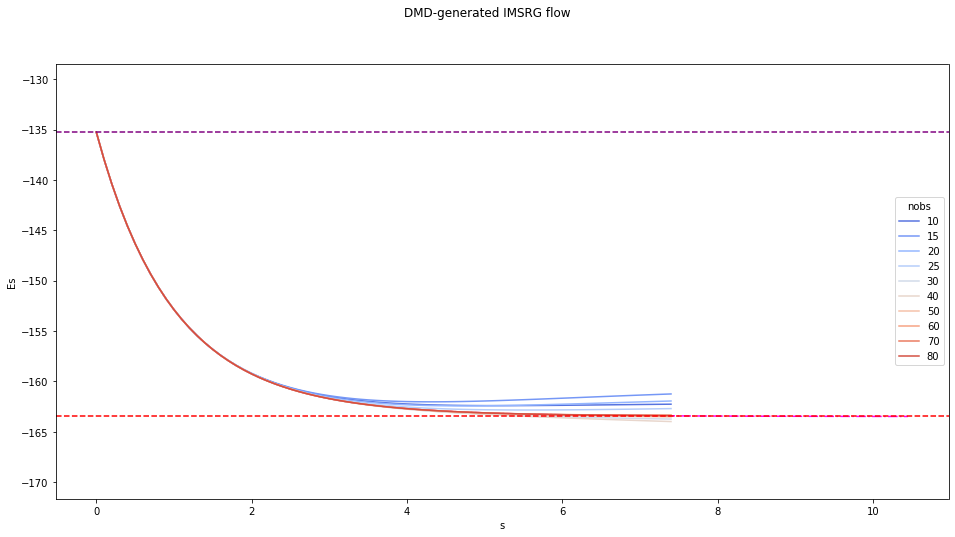

In [18]:
H0 = real_imsrg_data[:,0]
Hf = real_imsrg_data[:,-1]
print(real_imsrg_data[0,:].shape)

fig,ax = plt.subplots(figsize=(16,8))
sns.lineplot(x=np.asarray(range(0,real_imsrg_data.shape[1]))*ds, y=real_imsrg_data[0,:],ax=ax, color='fuchsia', linestyle='-.')
sns.lineplot(x="s", y="Es", hue="nobs", data=full_df, ax=ax, palette=sns.color_palette('coolwarm',len(nobs_list)))
ax.axhline(H0[0], color='purple', linestyle='--')
ax.axhline(Hf[0], color='red', linestyle='--')
fig.suptitle("DMD-generated IMSRG flow")
ax.set_ylim([Hf[0]*1.05,H0[0]*0.95])

#### IMSRG production code to compute Ne20, eMax=6

In [19]:
# Run DMD on time series data (IMSRG COEFFICIENT VECTORS). 
# Flow to k=50, which extrapolates to s=5.0
from IPython.display import display, clear_output
# ts_imsrg_data = get_log_data('flow/H08-1.00-1.40-0.40-0.00-5.00-0.10.log', imsrg=True)
# ts_imsrg_data = get_log_data('flow/H08-1.00-0.50-0.10-0.00-5.00-0.10.imsrg.log', imsrg=True)
real_imsrg_data = get_ascii_log('flow/Ne20_chi2b_srg0625_eMax06_hwHO020.flow.log')

nobs_list = [10,15,20,25,30,40,50,60,70,80]
ds = 0.05
df_list = []
for nobs in nobs_list:
    nobs = nobs
    X = real_imsrg_data[:, :nobs]
    Xp = real_imsrg_data[:, 1:nobs+1]

    H0 = real_imsrg_data[:,0]
    Hf = real_imsrg_data[:,-1]

    phi,dmd_eig,b = dmd(X, Xp, exact=False, 
                               r=nobs, 
                               randomize=True,
                               n_components=min(nobs,10),
                               as_matrix=True)
    print(np.diag(dmd_eig))

    kvals = range(0,150,2)
    for k in kvals:
        string = "# OBSERVATIONS={:02d}\nRUNNING ON K={:02d}".format(nobs,k)
        # clear_output(wait=True)
        display(string)
        s = k*ds
        Hs = phi@np.linalg.matrix_power(dmd_eig,k)@b
        Hs = np.real(Hs)
        row = pd.DataFrame([
                            [nobs, k, s, H0[0], Hf[0], Hs[0]]
                           ], 
                           columns=["nobs", "k", "s", "E0", "Ef", "Es"])
        df_list.append(row)
full_df = pd.concat(df_list, ignore_index=True)

Line 01 | Loaded  3.56 MBs from file
Line 02 | Loaded  7.13 MBs from file
Line 03 | Loaded 10.69 MBs from file
Line 04 | Loaded 14.26 MBs from file
Line 05 | Loaded 17.82 MBs from file
Line 06 | Loaded 21.38 MBs from file
Line 07 | Loaded 24.95 MBs from file
Line 08 | Loaded 28.51 MBs from file
Line 09 | Loaded 32.08 MBs from file
Line 10 | Loaded 35.64 MBs from file
Line 11 | Loaded 39.20 MBs from file
Line 12 | Loaded 42.77 MBs from file
Line 13 | Loaded 46.33 MBs from file
Line 14 | Loaded 49.90 MBs from file
Line 15 | Loaded 53.46 MBs from file
Line 16 | Loaded 57.02 MBs from file
Line 17 | Loaded 60.59 MBs from file
Line 18 | Loaded 64.15 MBs from file
Line 19 | Loaded 67.71 MBs from file
Line 20 | Loaded 71.28 MBs from file
Line 21 | Loaded 74.84 MBs from file
Line 22 | Loaded 78.41 MBs from file
Line 23 | Loaded 81.97 MBs from file
Line 24 | Loaded 85.53 MBs from file
Line 25 | Loaded 89.10 MBs from file
Line 26 | Loaded 92.66 MBs from file
Line 27 | Loaded 96.23 MBs from file
L

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


(467133, 10)
(10, 10)
phi,  (467133, 10)
b  (10,)
Hs,  (467133,)
[ 0.99976548+0.j         0.95981913+0.j         0.85735289+0.j
  0.69513564+0.j         0.48515557+0.j         0.40600241+0.j
  0.15709114+0.j         0.01700225+0.j        -0.68236444+0.3970597j
 -0.68236444-0.3970597j]


'# OBSERVATIONS=10\nRUNNING ON K=00'

'# OBSERVATIONS=10\nRUNNING ON K=02'

'# OBSERVATIONS=10\nRUNNING ON K=04'

'# OBSERVATIONS=10\nRUNNING ON K=06'

'# OBSERVATIONS=10\nRUNNING ON K=08'

'# OBSERVATIONS=10\nRUNNING ON K=10'

'# OBSERVATIONS=10\nRUNNING ON K=12'

'# OBSERVATIONS=10\nRUNNING ON K=14'

'# OBSERVATIONS=10\nRUNNING ON K=16'

'# OBSERVATIONS=10\nRUNNING ON K=18'

'# OBSERVATIONS=10\nRUNNING ON K=20'

'# OBSERVATIONS=10\nRUNNING ON K=22'

'# OBSERVATIONS=10\nRUNNING ON K=24'

'# OBSERVATIONS=10\nRUNNING ON K=26'

'# OBSERVATIONS=10\nRUNNING ON K=28'

'# OBSERVATIONS=10\nRUNNING ON K=30'

'# OBSERVATIONS=10\nRUNNING ON K=32'

'# OBSERVATIONS=10\nRUNNING ON K=34'

'# OBSERVATIONS=10\nRUNNING ON K=36'

'# OBSERVATIONS=10\nRUNNING ON K=38'

'# OBSERVATIONS=10\nRUNNING ON K=40'

'# OBSERVATIONS=10\nRUNNING ON K=42'

'# OBSERVATIONS=10\nRUNNING ON K=44'

'# OBSERVATIONS=10\nRUNNING ON K=46'

'# OBSERVATIONS=10\nRUNNING ON K=48'

'# OBSERVATIONS=10\nRUNNING ON K=50'

'# OBSERVATIONS=10\nRUNNING ON K=52'

'# OBSERVATIONS=10\nRUNNING ON K=54'

'# OBSERVATIONS=10\nRUNNING ON K=56'

'# OBSERVATIONS=10\nRUNNING ON K=58'

'# OBSERVATIONS=10\nRUNNING ON K=60'

'# OBSERVATIONS=10\nRUNNING ON K=62'

'# OBSERVATIONS=10\nRUNNING ON K=64'

'# OBSERVATIONS=10\nRUNNING ON K=66'

'# OBSERVATIONS=10\nRUNNING ON K=68'

'# OBSERVATIONS=10\nRUNNING ON K=70'

'# OBSERVATIONS=10\nRUNNING ON K=72'

'# OBSERVATIONS=10\nRUNNING ON K=74'

'# OBSERVATIONS=10\nRUNNING ON K=76'

'# OBSERVATIONS=10\nRUNNING ON K=78'

'# OBSERVATIONS=10\nRUNNING ON K=80'

'# OBSERVATIONS=10\nRUNNING ON K=82'

'# OBSERVATIONS=10\nRUNNING ON K=84'

'# OBSERVATIONS=10\nRUNNING ON K=86'

'# OBSERVATIONS=10\nRUNNING ON K=88'

'# OBSERVATIONS=10\nRUNNING ON K=90'

'# OBSERVATIONS=10\nRUNNING ON K=92'

'# OBSERVATIONS=10\nRUNNING ON K=94'

'# OBSERVATIONS=10\nRUNNING ON K=96'

'# OBSERVATIONS=10\nRUNNING ON K=98'

'# OBSERVATIONS=10\nRUNNING ON K=100'

'# OBSERVATIONS=10\nRUNNING ON K=102'

'# OBSERVATIONS=10\nRUNNING ON K=104'

'# OBSERVATIONS=10\nRUNNING ON K=106'

'# OBSERVATIONS=10\nRUNNING ON K=108'

'# OBSERVATIONS=10\nRUNNING ON K=110'

'# OBSERVATIONS=10\nRUNNING ON K=112'

'# OBSERVATIONS=10\nRUNNING ON K=114'

'# OBSERVATIONS=10\nRUNNING ON K=116'

'# OBSERVATIONS=10\nRUNNING ON K=118'

'# OBSERVATIONS=10\nRUNNING ON K=120'

'# OBSERVATIONS=10\nRUNNING ON K=122'

'# OBSERVATIONS=10\nRUNNING ON K=124'

'# OBSERVATIONS=10\nRUNNING ON K=126'

'# OBSERVATIONS=10\nRUNNING ON K=128'

'# OBSERVATIONS=10\nRUNNING ON K=130'

'# OBSERVATIONS=10\nRUNNING ON K=132'

'# OBSERVATIONS=10\nRUNNING ON K=134'

'# OBSERVATIONS=10\nRUNNING ON K=136'

'# OBSERVATIONS=10\nRUNNING ON K=138'

'# OBSERVATIONS=10\nRUNNING ON K=140'

'# OBSERVATIONS=10\nRUNNING ON K=142'

'# OBSERVATIONS=10\nRUNNING ON K=144'

'# OBSERVATIONS=10\nRUNNING ON K=146'

'# OBSERVATIONS=10\nRUNNING ON K=148'

trying randomized SVD
(467133, 10)
(10, 10)
phi,  (467133, 10)
b  (10,)
Hs,  (467133,)
[0.0329683 +0.10788465j 0.0329683 -0.10788465j 0.11381267+0.j
 0.99995965+0.j         0.97054957+0.j         0.88840906+0.j
 0.78960596+0.j         0.69637206+0.j         0.44368817+0.09379584j
 0.44368817-0.09379584j]


'# OBSERVATIONS=15\nRUNNING ON K=00'

'# OBSERVATIONS=15\nRUNNING ON K=02'

'# OBSERVATIONS=15\nRUNNING ON K=04'

'# OBSERVATIONS=15\nRUNNING ON K=06'

'# OBSERVATIONS=15\nRUNNING ON K=08'

'# OBSERVATIONS=15\nRUNNING ON K=10'

'# OBSERVATIONS=15\nRUNNING ON K=12'

'# OBSERVATIONS=15\nRUNNING ON K=14'

'# OBSERVATIONS=15\nRUNNING ON K=16'

'# OBSERVATIONS=15\nRUNNING ON K=18'

'# OBSERVATIONS=15\nRUNNING ON K=20'

'# OBSERVATIONS=15\nRUNNING ON K=22'

'# OBSERVATIONS=15\nRUNNING ON K=24'

'# OBSERVATIONS=15\nRUNNING ON K=26'

'# OBSERVATIONS=15\nRUNNING ON K=28'

'# OBSERVATIONS=15\nRUNNING ON K=30'

'# OBSERVATIONS=15\nRUNNING ON K=32'

'# OBSERVATIONS=15\nRUNNING ON K=34'

'# OBSERVATIONS=15\nRUNNING ON K=36'

'# OBSERVATIONS=15\nRUNNING ON K=38'

'# OBSERVATIONS=15\nRUNNING ON K=40'

'# OBSERVATIONS=15\nRUNNING ON K=42'

'# OBSERVATIONS=15\nRUNNING ON K=44'

'# OBSERVATIONS=15\nRUNNING ON K=46'

'# OBSERVATIONS=15\nRUNNING ON K=48'

'# OBSERVATIONS=15\nRUNNING ON K=50'

'# OBSERVATIONS=15\nRUNNING ON K=52'

'# OBSERVATIONS=15\nRUNNING ON K=54'

'# OBSERVATIONS=15\nRUNNING ON K=56'

'# OBSERVATIONS=15\nRUNNING ON K=58'

'# OBSERVATIONS=15\nRUNNING ON K=60'

'# OBSERVATIONS=15\nRUNNING ON K=62'

'# OBSERVATIONS=15\nRUNNING ON K=64'

'# OBSERVATIONS=15\nRUNNING ON K=66'

'# OBSERVATIONS=15\nRUNNING ON K=68'

'# OBSERVATIONS=15\nRUNNING ON K=70'

'# OBSERVATIONS=15\nRUNNING ON K=72'

'# OBSERVATIONS=15\nRUNNING ON K=74'

'# OBSERVATIONS=15\nRUNNING ON K=76'

'# OBSERVATIONS=15\nRUNNING ON K=78'

'# OBSERVATIONS=15\nRUNNING ON K=80'

'# OBSERVATIONS=15\nRUNNING ON K=82'

'# OBSERVATIONS=15\nRUNNING ON K=84'

'# OBSERVATIONS=15\nRUNNING ON K=86'

'# OBSERVATIONS=15\nRUNNING ON K=88'

'# OBSERVATIONS=15\nRUNNING ON K=90'

'# OBSERVATIONS=15\nRUNNING ON K=92'

'# OBSERVATIONS=15\nRUNNING ON K=94'

'# OBSERVATIONS=15\nRUNNING ON K=96'

'# OBSERVATIONS=15\nRUNNING ON K=98'

'# OBSERVATIONS=15\nRUNNING ON K=100'

'# OBSERVATIONS=15\nRUNNING ON K=102'

'# OBSERVATIONS=15\nRUNNING ON K=104'

'# OBSERVATIONS=15\nRUNNING ON K=106'

'# OBSERVATIONS=15\nRUNNING ON K=108'

'# OBSERVATIONS=15\nRUNNING ON K=110'

'# OBSERVATIONS=15\nRUNNING ON K=112'

'# OBSERVATIONS=15\nRUNNING ON K=114'

'# OBSERVATIONS=15\nRUNNING ON K=116'

'# OBSERVATIONS=15\nRUNNING ON K=118'

'# OBSERVATIONS=15\nRUNNING ON K=120'

'# OBSERVATIONS=15\nRUNNING ON K=122'

'# OBSERVATIONS=15\nRUNNING ON K=124'

'# OBSERVATIONS=15\nRUNNING ON K=126'

'# OBSERVATIONS=15\nRUNNING ON K=128'

'# OBSERVATIONS=15\nRUNNING ON K=130'

'# OBSERVATIONS=15\nRUNNING ON K=132'

'# OBSERVATIONS=15\nRUNNING ON K=134'

'# OBSERVATIONS=15\nRUNNING ON K=136'

'# OBSERVATIONS=15\nRUNNING ON K=138'

'# OBSERVATIONS=15\nRUNNING ON K=140'

'# OBSERVATIONS=15\nRUNNING ON K=142'

'# OBSERVATIONS=15\nRUNNING ON K=144'

'# OBSERVATIONS=15\nRUNNING ON K=146'

'# OBSERVATIONS=15\nRUNNING ON K=148'

trying randomized SVD
(467133, 10)
(10, 10)
phi,  (467133, 10)
b  (10,)
Hs,  (467133,)
[0.03935529+0.j 0.15884697+0.j 0.29144183+0.j 0.47724153+0.j
 0.65012362+0.j 0.68415587+0.j 0.9999491 +0.j 0.97496262+0.j
 0.92320897+0.j 0.85413133+0.j]


'# OBSERVATIONS=20\nRUNNING ON K=00'

'# OBSERVATIONS=20\nRUNNING ON K=02'

'# OBSERVATIONS=20\nRUNNING ON K=04'

'# OBSERVATIONS=20\nRUNNING ON K=06'

'# OBSERVATIONS=20\nRUNNING ON K=08'

'# OBSERVATIONS=20\nRUNNING ON K=10'

'# OBSERVATIONS=20\nRUNNING ON K=12'

'# OBSERVATIONS=20\nRUNNING ON K=14'

'# OBSERVATIONS=20\nRUNNING ON K=16'

'# OBSERVATIONS=20\nRUNNING ON K=18'

'# OBSERVATIONS=20\nRUNNING ON K=20'

'# OBSERVATIONS=20\nRUNNING ON K=22'

'# OBSERVATIONS=20\nRUNNING ON K=24'

'# OBSERVATIONS=20\nRUNNING ON K=26'

'# OBSERVATIONS=20\nRUNNING ON K=28'

'# OBSERVATIONS=20\nRUNNING ON K=30'

'# OBSERVATIONS=20\nRUNNING ON K=32'

'# OBSERVATIONS=20\nRUNNING ON K=34'

'# OBSERVATIONS=20\nRUNNING ON K=36'

'# OBSERVATIONS=20\nRUNNING ON K=38'

'# OBSERVATIONS=20\nRUNNING ON K=40'

'# OBSERVATIONS=20\nRUNNING ON K=42'

'# OBSERVATIONS=20\nRUNNING ON K=44'

'# OBSERVATIONS=20\nRUNNING ON K=46'

'# OBSERVATIONS=20\nRUNNING ON K=48'

'# OBSERVATIONS=20\nRUNNING ON K=50'

'# OBSERVATIONS=20\nRUNNING ON K=52'

'# OBSERVATIONS=20\nRUNNING ON K=54'

'# OBSERVATIONS=20\nRUNNING ON K=56'

'# OBSERVATIONS=20\nRUNNING ON K=58'

'# OBSERVATIONS=20\nRUNNING ON K=60'

'# OBSERVATIONS=20\nRUNNING ON K=62'

'# OBSERVATIONS=20\nRUNNING ON K=64'

'# OBSERVATIONS=20\nRUNNING ON K=66'

'# OBSERVATIONS=20\nRUNNING ON K=68'

'# OBSERVATIONS=20\nRUNNING ON K=70'

'# OBSERVATIONS=20\nRUNNING ON K=72'

'# OBSERVATIONS=20\nRUNNING ON K=74'

'# OBSERVATIONS=20\nRUNNING ON K=76'

'# OBSERVATIONS=20\nRUNNING ON K=78'

'# OBSERVATIONS=20\nRUNNING ON K=80'

'# OBSERVATIONS=20\nRUNNING ON K=82'

'# OBSERVATIONS=20\nRUNNING ON K=84'

'# OBSERVATIONS=20\nRUNNING ON K=86'

'# OBSERVATIONS=20\nRUNNING ON K=88'

'# OBSERVATIONS=20\nRUNNING ON K=90'

'# OBSERVATIONS=20\nRUNNING ON K=92'

'# OBSERVATIONS=20\nRUNNING ON K=94'

'# OBSERVATIONS=20\nRUNNING ON K=96'

'# OBSERVATIONS=20\nRUNNING ON K=98'

'# OBSERVATIONS=20\nRUNNING ON K=100'

'# OBSERVATIONS=20\nRUNNING ON K=102'

'# OBSERVATIONS=20\nRUNNING ON K=104'

'# OBSERVATIONS=20\nRUNNING ON K=106'

'# OBSERVATIONS=20\nRUNNING ON K=108'

'# OBSERVATIONS=20\nRUNNING ON K=110'

'# OBSERVATIONS=20\nRUNNING ON K=112'

'# OBSERVATIONS=20\nRUNNING ON K=114'

'# OBSERVATIONS=20\nRUNNING ON K=116'

'# OBSERVATIONS=20\nRUNNING ON K=118'

'# OBSERVATIONS=20\nRUNNING ON K=120'

'# OBSERVATIONS=20\nRUNNING ON K=122'

'# OBSERVATIONS=20\nRUNNING ON K=124'

'# OBSERVATIONS=20\nRUNNING ON K=126'

'# OBSERVATIONS=20\nRUNNING ON K=128'

'# OBSERVATIONS=20\nRUNNING ON K=130'

'# OBSERVATIONS=20\nRUNNING ON K=132'

'# OBSERVATIONS=20\nRUNNING ON K=134'

'# OBSERVATIONS=20\nRUNNING ON K=136'

'# OBSERVATIONS=20\nRUNNING ON K=138'

'# OBSERVATIONS=20\nRUNNING ON K=140'

'# OBSERVATIONS=20\nRUNNING ON K=142'

'# OBSERVATIONS=20\nRUNNING ON K=144'

'# OBSERVATIONS=20\nRUNNING ON K=146'

'# OBSERVATIONS=20\nRUNNING ON K=148'

trying randomized SVD
(467133, 10)
(10, 10)
phi,  (467133, 10)
b  (10,)
Hs,  (467133,)
[0.04589403+0.j 0.18281285+0.j 0.3730978 +0.j 0.48779675+0.j
 0.62581979+0.j 0.99993292+0.j 0.97891549+0.j 0.9411487 +0.j
 0.79450752+0.j 0.85828823+0.j]


'# OBSERVATIONS=25\nRUNNING ON K=00'

'# OBSERVATIONS=25\nRUNNING ON K=02'

'# OBSERVATIONS=25\nRUNNING ON K=04'

'# OBSERVATIONS=25\nRUNNING ON K=06'

'# OBSERVATIONS=25\nRUNNING ON K=08'

'# OBSERVATIONS=25\nRUNNING ON K=10'

'# OBSERVATIONS=25\nRUNNING ON K=12'

'# OBSERVATIONS=25\nRUNNING ON K=14'

'# OBSERVATIONS=25\nRUNNING ON K=16'

'# OBSERVATIONS=25\nRUNNING ON K=18'

'# OBSERVATIONS=25\nRUNNING ON K=20'

'# OBSERVATIONS=25\nRUNNING ON K=22'

'# OBSERVATIONS=25\nRUNNING ON K=24'

'# OBSERVATIONS=25\nRUNNING ON K=26'

'# OBSERVATIONS=25\nRUNNING ON K=28'

'# OBSERVATIONS=25\nRUNNING ON K=30'

'# OBSERVATIONS=25\nRUNNING ON K=32'

'# OBSERVATIONS=25\nRUNNING ON K=34'

'# OBSERVATIONS=25\nRUNNING ON K=36'

'# OBSERVATIONS=25\nRUNNING ON K=38'

'# OBSERVATIONS=25\nRUNNING ON K=40'

'# OBSERVATIONS=25\nRUNNING ON K=42'

'# OBSERVATIONS=25\nRUNNING ON K=44'

'# OBSERVATIONS=25\nRUNNING ON K=46'

'# OBSERVATIONS=25\nRUNNING ON K=48'

'# OBSERVATIONS=25\nRUNNING ON K=50'

'# OBSERVATIONS=25\nRUNNING ON K=52'

'# OBSERVATIONS=25\nRUNNING ON K=54'

'# OBSERVATIONS=25\nRUNNING ON K=56'

'# OBSERVATIONS=25\nRUNNING ON K=58'

'# OBSERVATIONS=25\nRUNNING ON K=60'

'# OBSERVATIONS=25\nRUNNING ON K=62'

'# OBSERVATIONS=25\nRUNNING ON K=64'

'# OBSERVATIONS=25\nRUNNING ON K=66'

'# OBSERVATIONS=25\nRUNNING ON K=68'

'# OBSERVATIONS=25\nRUNNING ON K=70'

'# OBSERVATIONS=25\nRUNNING ON K=72'

'# OBSERVATIONS=25\nRUNNING ON K=74'

'# OBSERVATIONS=25\nRUNNING ON K=76'

'# OBSERVATIONS=25\nRUNNING ON K=78'

'# OBSERVATIONS=25\nRUNNING ON K=80'

'# OBSERVATIONS=25\nRUNNING ON K=82'

'# OBSERVATIONS=25\nRUNNING ON K=84'

'# OBSERVATIONS=25\nRUNNING ON K=86'

'# OBSERVATIONS=25\nRUNNING ON K=88'

'# OBSERVATIONS=25\nRUNNING ON K=90'

'# OBSERVATIONS=25\nRUNNING ON K=92'

'# OBSERVATIONS=25\nRUNNING ON K=94'

'# OBSERVATIONS=25\nRUNNING ON K=96'

'# OBSERVATIONS=25\nRUNNING ON K=98'

'# OBSERVATIONS=25\nRUNNING ON K=100'

'# OBSERVATIONS=25\nRUNNING ON K=102'

'# OBSERVATIONS=25\nRUNNING ON K=104'

'# OBSERVATIONS=25\nRUNNING ON K=106'

'# OBSERVATIONS=25\nRUNNING ON K=108'

'# OBSERVATIONS=25\nRUNNING ON K=110'

'# OBSERVATIONS=25\nRUNNING ON K=112'

'# OBSERVATIONS=25\nRUNNING ON K=114'

'# OBSERVATIONS=25\nRUNNING ON K=116'

'# OBSERVATIONS=25\nRUNNING ON K=118'

'# OBSERVATIONS=25\nRUNNING ON K=120'

'# OBSERVATIONS=25\nRUNNING ON K=122'

'# OBSERVATIONS=25\nRUNNING ON K=124'

'# OBSERVATIONS=25\nRUNNING ON K=126'

'# OBSERVATIONS=25\nRUNNING ON K=128'

'# OBSERVATIONS=25\nRUNNING ON K=130'

'# OBSERVATIONS=25\nRUNNING ON K=132'

'# OBSERVATIONS=25\nRUNNING ON K=134'

'# OBSERVATIONS=25\nRUNNING ON K=136'

'# OBSERVATIONS=25\nRUNNING ON K=138'

'# OBSERVATIONS=25\nRUNNING ON K=140'

'# OBSERVATIONS=25\nRUNNING ON K=142'

'# OBSERVATIONS=25\nRUNNING ON K=144'

'# OBSERVATIONS=25\nRUNNING ON K=146'

'# OBSERVATIONS=25\nRUNNING ON K=148'

trying randomized SVD
(467133, 10)
(10, 10)
phi,  (467133, 10)
b  (10,)
Hs,  (467133,)
[0.05475735+0.j 0.19995997+0.j 0.41027699+0.j 0.49646318+0.j
 0.71743994+0.j 0.77235017+0.j 0.99996785+0.j 0.98163083+0.j
 0.94812376+0.j 0.87674584+0.j]


'# OBSERVATIONS=30\nRUNNING ON K=00'

'# OBSERVATIONS=30\nRUNNING ON K=02'

'# OBSERVATIONS=30\nRUNNING ON K=04'

'# OBSERVATIONS=30\nRUNNING ON K=06'

'# OBSERVATIONS=30\nRUNNING ON K=08'

'# OBSERVATIONS=30\nRUNNING ON K=10'

'# OBSERVATIONS=30\nRUNNING ON K=12'

'# OBSERVATIONS=30\nRUNNING ON K=14'

'# OBSERVATIONS=30\nRUNNING ON K=16'

'# OBSERVATIONS=30\nRUNNING ON K=18'

'# OBSERVATIONS=30\nRUNNING ON K=20'

'# OBSERVATIONS=30\nRUNNING ON K=22'

'# OBSERVATIONS=30\nRUNNING ON K=24'

'# OBSERVATIONS=30\nRUNNING ON K=26'

'# OBSERVATIONS=30\nRUNNING ON K=28'

'# OBSERVATIONS=30\nRUNNING ON K=30'

'# OBSERVATIONS=30\nRUNNING ON K=32'

'# OBSERVATIONS=30\nRUNNING ON K=34'

'# OBSERVATIONS=30\nRUNNING ON K=36'

'# OBSERVATIONS=30\nRUNNING ON K=38'

'# OBSERVATIONS=30\nRUNNING ON K=40'

'# OBSERVATIONS=30\nRUNNING ON K=42'

'# OBSERVATIONS=30\nRUNNING ON K=44'

'# OBSERVATIONS=30\nRUNNING ON K=46'

'# OBSERVATIONS=30\nRUNNING ON K=48'

'# OBSERVATIONS=30\nRUNNING ON K=50'

'# OBSERVATIONS=30\nRUNNING ON K=52'

'# OBSERVATIONS=30\nRUNNING ON K=54'

'# OBSERVATIONS=30\nRUNNING ON K=56'

'# OBSERVATIONS=30\nRUNNING ON K=58'

'# OBSERVATIONS=30\nRUNNING ON K=60'

'# OBSERVATIONS=30\nRUNNING ON K=62'

'# OBSERVATIONS=30\nRUNNING ON K=64'

'# OBSERVATIONS=30\nRUNNING ON K=66'

'# OBSERVATIONS=30\nRUNNING ON K=68'

'# OBSERVATIONS=30\nRUNNING ON K=70'

'# OBSERVATIONS=30\nRUNNING ON K=72'

'# OBSERVATIONS=30\nRUNNING ON K=74'

'# OBSERVATIONS=30\nRUNNING ON K=76'

'# OBSERVATIONS=30\nRUNNING ON K=78'

'# OBSERVATIONS=30\nRUNNING ON K=80'

'# OBSERVATIONS=30\nRUNNING ON K=82'

'# OBSERVATIONS=30\nRUNNING ON K=84'

'# OBSERVATIONS=30\nRUNNING ON K=86'

'# OBSERVATIONS=30\nRUNNING ON K=88'

'# OBSERVATIONS=30\nRUNNING ON K=90'

'# OBSERVATIONS=30\nRUNNING ON K=92'

'# OBSERVATIONS=30\nRUNNING ON K=94'

'# OBSERVATIONS=30\nRUNNING ON K=96'

'# OBSERVATIONS=30\nRUNNING ON K=98'

'# OBSERVATIONS=30\nRUNNING ON K=100'

'# OBSERVATIONS=30\nRUNNING ON K=102'

'# OBSERVATIONS=30\nRUNNING ON K=104'

'# OBSERVATIONS=30\nRUNNING ON K=106'

'# OBSERVATIONS=30\nRUNNING ON K=108'

'# OBSERVATIONS=30\nRUNNING ON K=110'

'# OBSERVATIONS=30\nRUNNING ON K=112'

'# OBSERVATIONS=30\nRUNNING ON K=114'

'# OBSERVATIONS=30\nRUNNING ON K=116'

'# OBSERVATIONS=30\nRUNNING ON K=118'

'# OBSERVATIONS=30\nRUNNING ON K=120'

'# OBSERVATIONS=30\nRUNNING ON K=122'

'# OBSERVATIONS=30\nRUNNING ON K=124'

'# OBSERVATIONS=30\nRUNNING ON K=126'

'# OBSERVATIONS=30\nRUNNING ON K=128'

'# OBSERVATIONS=30\nRUNNING ON K=130'

'# OBSERVATIONS=30\nRUNNING ON K=132'

'# OBSERVATIONS=30\nRUNNING ON K=134'

'# OBSERVATIONS=30\nRUNNING ON K=136'

'# OBSERVATIONS=30\nRUNNING ON K=138'

'# OBSERVATIONS=30\nRUNNING ON K=140'

'# OBSERVATIONS=30\nRUNNING ON K=142'

'# OBSERVATIONS=30\nRUNNING ON K=144'

'# OBSERVATIONS=30\nRUNNING ON K=146'

'# OBSERVATIONS=30\nRUNNING ON K=148'

trying randomized SVD
(467133, 10)
(10, 10)
phi,  (467133, 10)
b  (10,)
Hs,  (467133,)
[0.06901742+0.j 0.24120111+0.j 0.42494764+0.j 0.5734894 +0.j
 0.71231647+0.j 0.83904247+0.j 0.9999917 +0.j 0.98442936+0.j
 0.95749726+0.j 0.89316883+0.j]


'# OBSERVATIONS=40\nRUNNING ON K=00'

'# OBSERVATIONS=40\nRUNNING ON K=02'

'# OBSERVATIONS=40\nRUNNING ON K=04'

'# OBSERVATIONS=40\nRUNNING ON K=06'

'# OBSERVATIONS=40\nRUNNING ON K=08'

'# OBSERVATIONS=40\nRUNNING ON K=10'

'# OBSERVATIONS=40\nRUNNING ON K=12'

'# OBSERVATIONS=40\nRUNNING ON K=14'

'# OBSERVATIONS=40\nRUNNING ON K=16'

'# OBSERVATIONS=40\nRUNNING ON K=18'

'# OBSERVATIONS=40\nRUNNING ON K=20'

'# OBSERVATIONS=40\nRUNNING ON K=22'

'# OBSERVATIONS=40\nRUNNING ON K=24'

'# OBSERVATIONS=40\nRUNNING ON K=26'

'# OBSERVATIONS=40\nRUNNING ON K=28'

'# OBSERVATIONS=40\nRUNNING ON K=30'

'# OBSERVATIONS=40\nRUNNING ON K=32'

'# OBSERVATIONS=40\nRUNNING ON K=34'

'# OBSERVATIONS=40\nRUNNING ON K=36'

'# OBSERVATIONS=40\nRUNNING ON K=38'

'# OBSERVATIONS=40\nRUNNING ON K=40'

'# OBSERVATIONS=40\nRUNNING ON K=42'

'# OBSERVATIONS=40\nRUNNING ON K=44'

'# OBSERVATIONS=40\nRUNNING ON K=46'

'# OBSERVATIONS=40\nRUNNING ON K=48'

'# OBSERVATIONS=40\nRUNNING ON K=50'

'# OBSERVATIONS=40\nRUNNING ON K=52'

'# OBSERVATIONS=40\nRUNNING ON K=54'

'# OBSERVATIONS=40\nRUNNING ON K=56'

'# OBSERVATIONS=40\nRUNNING ON K=58'

'# OBSERVATIONS=40\nRUNNING ON K=60'

'# OBSERVATIONS=40\nRUNNING ON K=62'

'# OBSERVATIONS=40\nRUNNING ON K=64'

'# OBSERVATIONS=40\nRUNNING ON K=66'

'# OBSERVATIONS=40\nRUNNING ON K=68'

'# OBSERVATIONS=40\nRUNNING ON K=70'

'# OBSERVATIONS=40\nRUNNING ON K=72'

'# OBSERVATIONS=40\nRUNNING ON K=74'

'# OBSERVATIONS=40\nRUNNING ON K=76'

'# OBSERVATIONS=40\nRUNNING ON K=78'

'# OBSERVATIONS=40\nRUNNING ON K=80'

'# OBSERVATIONS=40\nRUNNING ON K=82'

'# OBSERVATIONS=40\nRUNNING ON K=84'

'# OBSERVATIONS=40\nRUNNING ON K=86'

'# OBSERVATIONS=40\nRUNNING ON K=88'

'# OBSERVATIONS=40\nRUNNING ON K=90'

'# OBSERVATIONS=40\nRUNNING ON K=92'

'# OBSERVATIONS=40\nRUNNING ON K=94'

'# OBSERVATIONS=40\nRUNNING ON K=96'

'# OBSERVATIONS=40\nRUNNING ON K=98'

'# OBSERVATIONS=40\nRUNNING ON K=100'

'# OBSERVATIONS=40\nRUNNING ON K=102'

'# OBSERVATIONS=40\nRUNNING ON K=104'

'# OBSERVATIONS=40\nRUNNING ON K=106'

'# OBSERVATIONS=40\nRUNNING ON K=108'

'# OBSERVATIONS=40\nRUNNING ON K=110'

'# OBSERVATIONS=40\nRUNNING ON K=112'

'# OBSERVATIONS=40\nRUNNING ON K=114'

'# OBSERVATIONS=40\nRUNNING ON K=116'

'# OBSERVATIONS=40\nRUNNING ON K=118'

'# OBSERVATIONS=40\nRUNNING ON K=120'

'# OBSERVATIONS=40\nRUNNING ON K=122'

'# OBSERVATIONS=40\nRUNNING ON K=124'

'# OBSERVATIONS=40\nRUNNING ON K=126'

'# OBSERVATIONS=40\nRUNNING ON K=128'

'# OBSERVATIONS=40\nRUNNING ON K=130'

'# OBSERVATIONS=40\nRUNNING ON K=132'

'# OBSERVATIONS=40\nRUNNING ON K=134'

'# OBSERVATIONS=40\nRUNNING ON K=136'

'# OBSERVATIONS=40\nRUNNING ON K=138'

'# OBSERVATIONS=40\nRUNNING ON K=140'

'# OBSERVATIONS=40\nRUNNING ON K=142'

'# OBSERVATIONS=40\nRUNNING ON K=144'

'# OBSERVATIONS=40\nRUNNING ON K=146'

'# OBSERVATIONS=40\nRUNNING ON K=148'

trying randomized SVD
(467133, 10)
(10, 10)
phi,  (467133, 10)
b  (10,)
Hs,  (467133,)
[0.07859424+0.j 0.27408537+0.j 0.44649258+0.j 0.61742403+0.j
 0.74465307+0.j 0.8523439 +0.j 0.99999186+0.j 0.98646405+0.j
 0.96537799+0.j 0.91585735+0.j]


'# OBSERVATIONS=50\nRUNNING ON K=00'

'# OBSERVATIONS=50\nRUNNING ON K=02'

'# OBSERVATIONS=50\nRUNNING ON K=04'

'# OBSERVATIONS=50\nRUNNING ON K=06'

'# OBSERVATIONS=50\nRUNNING ON K=08'

'# OBSERVATIONS=50\nRUNNING ON K=10'

'# OBSERVATIONS=50\nRUNNING ON K=12'

'# OBSERVATIONS=50\nRUNNING ON K=14'

'# OBSERVATIONS=50\nRUNNING ON K=16'

'# OBSERVATIONS=50\nRUNNING ON K=18'

'# OBSERVATIONS=50\nRUNNING ON K=20'

'# OBSERVATIONS=50\nRUNNING ON K=22'

'# OBSERVATIONS=50\nRUNNING ON K=24'

'# OBSERVATIONS=50\nRUNNING ON K=26'

'# OBSERVATIONS=50\nRUNNING ON K=28'

'# OBSERVATIONS=50\nRUNNING ON K=30'

'# OBSERVATIONS=50\nRUNNING ON K=32'

'# OBSERVATIONS=50\nRUNNING ON K=34'

'# OBSERVATIONS=50\nRUNNING ON K=36'

'# OBSERVATIONS=50\nRUNNING ON K=38'

'# OBSERVATIONS=50\nRUNNING ON K=40'

'# OBSERVATIONS=50\nRUNNING ON K=42'

'# OBSERVATIONS=50\nRUNNING ON K=44'

'# OBSERVATIONS=50\nRUNNING ON K=46'

'# OBSERVATIONS=50\nRUNNING ON K=48'

'# OBSERVATIONS=50\nRUNNING ON K=50'

'# OBSERVATIONS=50\nRUNNING ON K=52'

'# OBSERVATIONS=50\nRUNNING ON K=54'

'# OBSERVATIONS=50\nRUNNING ON K=56'

'# OBSERVATIONS=50\nRUNNING ON K=58'

'# OBSERVATIONS=50\nRUNNING ON K=60'

'# OBSERVATIONS=50\nRUNNING ON K=62'

'# OBSERVATIONS=50\nRUNNING ON K=64'

'# OBSERVATIONS=50\nRUNNING ON K=66'

'# OBSERVATIONS=50\nRUNNING ON K=68'

'# OBSERVATIONS=50\nRUNNING ON K=70'

'# OBSERVATIONS=50\nRUNNING ON K=72'

'# OBSERVATIONS=50\nRUNNING ON K=74'

'# OBSERVATIONS=50\nRUNNING ON K=76'

'# OBSERVATIONS=50\nRUNNING ON K=78'

'# OBSERVATIONS=50\nRUNNING ON K=80'

'# OBSERVATIONS=50\nRUNNING ON K=82'

'# OBSERVATIONS=50\nRUNNING ON K=84'

'# OBSERVATIONS=50\nRUNNING ON K=86'

'# OBSERVATIONS=50\nRUNNING ON K=88'

'# OBSERVATIONS=50\nRUNNING ON K=90'

'# OBSERVATIONS=50\nRUNNING ON K=92'

'# OBSERVATIONS=50\nRUNNING ON K=94'

'# OBSERVATIONS=50\nRUNNING ON K=96'

'# OBSERVATIONS=50\nRUNNING ON K=98'

'# OBSERVATIONS=50\nRUNNING ON K=100'

'# OBSERVATIONS=50\nRUNNING ON K=102'

'# OBSERVATIONS=50\nRUNNING ON K=104'

'# OBSERVATIONS=50\nRUNNING ON K=106'

'# OBSERVATIONS=50\nRUNNING ON K=108'

'# OBSERVATIONS=50\nRUNNING ON K=110'

'# OBSERVATIONS=50\nRUNNING ON K=112'

'# OBSERVATIONS=50\nRUNNING ON K=114'

'# OBSERVATIONS=50\nRUNNING ON K=116'

'# OBSERVATIONS=50\nRUNNING ON K=118'

'# OBSERVATIONS=50\nRUNNING ON K=120'

'# OBSERVATIONS=50\nRUNNING ON K=122'

'# OBSERVATIONS=50\nRUNNING ON K=124'

'# OBSERVATIONS=50\nRUNNING ON K=126'

'# OBSERVATIONS=50\nRUNNING ON K=128'

'# OBSERVATIONS=50\nRUNNING ON K=130'

'# OBSERVATIONS=50\nRUNNING ON K=132'

'# OBSERVATIONS=50\nRUNNING ON K=134'

'# OBSERVATIONS=50\nRUNNING ON K=136'

'# OBSERVATIONS=50\nRUNNING ON K=138'

'# OBSERVATIONS=50\nRUNNING ON K=140'

'# OBSERVATIONS=50\nRUNNING ON K=142'

'# OBSERVATIONS=50\nRUNNING ON K=144'

'# OBSERVATIONS=50\nRUNNING ON K=146'

'# OBSERVATIONS=50\nRUNNING ON K=148'

trying randomized SVD
(467133, 10)
(10, 10)
phi,  (467133, 10)
b  (10,)
Hs,  (467133,)
[0.08658681+0.j 0.29671883+0.j 0.46873984+0.j 0.64914036+0.j
 0.77368028+0.j 0.85987998+0.j 0.93028194+0.j 0.99998719+0.j
 0.98862427+0.j 0.97100898+0.j]


'# OBSERVATIONS=60\nRUNNING ON K=00'

'# OBSERVATIONS=60\nRUNNING ON K=02'

'# OBSERVATIONS=60\nRUNNING ON K=04'

'# OBSERVATIONS=60\nRUNNING ON K=06'

'# OBSERVATIONS=60\nRUNNING ON K=08'

'# OBSERVATIONS=60\nRUNNING ON K=10'

'# OBSERVATIONS=60\nRUNNING ON K=12'

'# OBSERVATIONS=60\nRUNNING ON K=14'

'# OBSERVATIONS=60\nRUNNING ON K=16'

'# OBSERVATIONS=60\nRUNNING ON K=18'

'# OBSERVATIONS=60\nRUNNING ON K=20'

'# OBSERVATIONS=60\nRUNNING ON K=22'

'# OBSERVATIONS=60\nRUNNING ON K=24'

'# OBSERVATIONS=60\nRUNNING ON K=26'

'# OBSERVATIONS=60\nRUNNING ON K=28'

'# OBSERVATIONS=60\nRUNNING ON K=30'

'# OBSERVATIONS=60\nRUNNING ON K=32'

'# OBSERVATIONS=60\nRUNNING ON K=34'

'# OBSERVATIONS=60\nRUNNING ON K=36'

'# OBSERVATIONS=60\nRUNNING ON K=38'

'# OBSERVATIONS=60\nRUNNING ON K=40'

'# OBSERVATIONS=60\nRUNNING ON K=42'

'# OBSERVATIONS=60\nRUNNING ON K=44'

'# OBSERVATIONS=60\nRUNNING ON K=46'

'# OBSERVATIONS=60\nRUNNING ON K=48'

'# OBSERVATIONS=60\nRUNNING ON K=50'

'# OBSERVATIONS=60\nRUNNING ON K=52'

'# OBSERVATIONS=60\nRUNNING ON K=54'

'# OBSERVATIONS=60\nRUNNING ON K=56'

'# OBSERVATIONS=60\nRUNNING ON K=58'

'# OBSERVATIONS=60\nRUNNING ON K=60'

'# OBSERVATIONS=60\nRUNNING ON K=62'

'# OBSERVATIONS=60\nRUNNING ON K=64'

'# OBSERVATIONS=60\nRUNNING ON K=66'

'# OBSERVATIONS=60\nRUNNING ON K=68'

'# OBSERVATIONS=60\nRUNNING ON K=70'

'# OBSERVATIONS=60\nRUNNING ON K=72'

'# OBSERVATIONS=60\nRUNNING ON K=74'

'# OBSERVATIONS=60\nRUNNING ON K=76'

'# OBSERVATIONS=60\nRUNNING ON K=78'

'# OBSERVATIONS=60\nRUNNING ON K=80'

'# OBSERVATIONS=60\nRUNNING ON K=82'

'# OBSERVATIONS=60\nRUNNING ON K=84'

'# OBSERVATIONS=60\nRUNNING ON K=86'

'# OBSERVATIONS=60\nRUNNING ON K=88'

'# OBSERVATIONS=60\nRUNNING ON K=90'

'# OBSERVATIONS=60\nRUNNING ON K=92'

'# OBSERVATIONS=60\nRUNNING ON K=94'

'# OBSERVATIONS=60\nRUNNING ON K=96'

'# OBSERVATIONS=60\nRUNNING ON K=98'

'# OBSERVATIONS=60\nRUNNING ON K=100'

'# OBSERVATIONS=60\nRUNNING ON K=102'

'# OBSERVATIONS=60\nRUNNING ON K=104'

'# OBSERVATIONS=60\nRUNNING ON K=106'

'# OBSERVATIONS=60\nRUNNING ON K=108'

'# OBSERVATIONS=60\nRUNNING ON K=110'

'# OBSERVATIONS=60\nRUNNING ON K=112'

'# OBSERVATIONS=60\nRUNNING ON K=114'

'# OBSERVATIONS=60\nRUNNING ON K=116'

'# OBSERVATIONS=60\nRUNNING ON K=118'

'# OBSERVATIONS=60\nRUNNING ON K=120'

'# OBSERVATIONS=60\nRUNNING ON K=122'

'# OBSERVATIONS=60\nRUNNING ON K=124'

'# OBSERVATIONS=60\nRUNNING ON K=126'

'# OBSERVATIONS=60\nRUNNING ON K=128'

'# OBSERVATIONS=60\nRUNNING ON K=130'

'# OBSERVATIONS=60\nRUNNING ON K=132'

'# OBSERVATIONS=60\nRUNNING ON K=134'

'# OBSERVATIONS=60\nRUNNING ON K=136'

'# OBSERVATIONS=60\nRUNNING ON K=138'

'# OBSERVATIONS=60\nRUNNING ON K=140'

'# OBSERVATIONS=60\nRUNNING ON K=142'

'# OBSERVATIONS=60\nRUNNING ON K=144'

'# OBSERVATIONS=60\nRUNNING ON K=146'

'# OBSERVATIONS=60\nRUNNING ON K=148'

trying randomized SVD
(467133, 10)
(10, 10)
phi,  (467133, 10)
b  (10,)
Hs,  (467133,)
[0.09410768+0.j 0.31355514+0.j 0.48987575+0.j 0.67536039+0.j
 0.79832885+0.j 0.86826102+0.j 0.93912674+0.j 0.99998652+0.j
 0.99074415+0.j 0.97423471+0.j]


'# OBSERVATIONS=70\nRUNNING ON K=00'

'# OBSERVATIONS=70\nRUNNING ON K=02'

'# OBSERVATIONS=70\nRUNNING ON K=04'

'# OBSERVATIONS=70\nRUNNING ON K=06'

'# OBSERVATIONS=70\nRUNNING ON K=08'

'# OBSERVATIONS=70\nRUNNING ON K=10'

'# OBSERVATIONS=70\nRUNNING ON K=12'

'# OBSERVATIONS=70\nRUNNING ON K=14'

'# OBSERVATIONS=70\nRUNNING ON K=16'

'# OBSERVATIONS=70\nRUNNING ON K=18'

'# OBSERVATIONS=70\nRUNNING ON K=20'

'# OBSERVATIONS=70\nRUNNING ON K=22'

'# OBSERVATIONS=70\nRUNNING ON K=24'

'# OBSERVATIONS=70\nRUNNING ON K=26'

'# OBSERVATIONS=70\nRUNNING ON K=28'

'# OBSERVATIONS=70\nRUNNING ON K=30'

'# OBSERVATIONS=70\nRUNNING ON K=32'

'# OBSERVATIONS=70\nRUNNING ON K=34'

'# OBSERVATIONS=70\nRUNNING ON K=36'

'# OBSERVATIONS=70\nRUNNING ON K=38'

'# OBSERVATIONS=70\nRUNNING ON K=40'

'# OBSERVATIONS=70\nRUNNING ON K=42'

'# OBSERVATIONS=70\nRUNNING ON K=44'

'# OBSERVATIONS=70\nRUNNING ON K=46'

'# OBSERVATIONS=70\nRUNNING ON K=48'

'# OBSERVATIONS=70\nRUNNING ON K=50'

'# OBSERVATIONS=70\nRUNNING ON K=52'

'# OBSERVATIONS=70\nRUNNING ON K=54'

'# OBSERVATIONS=70\nRUNNING ON K=56'

'# OBSERVATIONS=70\nRUNNING ON K=58'

'# OBSERVATIONS=70\nRUNNING ON K=60'

'# OBSERVATIONS=70\nRUNNING ON K=62'

'# OBSERVATIONS=70\nRUNNING ON K=64'

'# OBSERVATIONS=70\nRUNNING ON K=66'

'# OBSERVATIONS=70\nRUNNING ON K=68'

'# OBSERVATIONS=70\nRUNNING ON K=70'

'# OBSERVATIONS=70\nRUNNING ON K=72'

'# OBSERVATIONS=70\nRUNNING ON K=74'

'# OBSERVATIONS=70\nRUNNING ON K=76'

'# OBSERVATIONS=70\nRUNNING ON K=78'

'# OBSERVATIONS=70\nRUNNING ON K=80'

'# OBSERVATIONS=70\nRUNNING ON K=82'

'# OBSERVATIONS=70\nRUNNING ON K=84'

'# OBSERVATIONS=70\nRUNNING ON K=86'

'# OBSERVATIONS=70\nRUNNING ON K=88'

'# OBSERVATIONS=70\nRUNNING ON K=90'

'# OBSERVATIONS=70\nRUNNING ON K=92'

'# OBSERVATIONS=70\nRUNNING ON K=94'

'# OBSERVATIONS=70\nRUNNING ON K=96'

'# OBSERVATIONS=70\nRUNNING ON K=98'

'# OBSERVATIONS=70\nRUNNING ON K=100'

'# OBSERVATIONS=70\nRUNNING ON K=102'

'# OBSERVATIONS=70\nRUNNING ON K=104'

'# OBSERVATIONS=70\nRUNNING ON K=106'

'# OBSERVATIONS=70\nRUNNING ON K=108'

'# OBSERVATIONS=70\nRUNNING ON K=110'

'# OBSERVATIONS=70\nRUNNING ON K=112'

'# OBSERVATIONS=70\nRUNNING ON K=114'

'# OBSERVATIONS=70\nRUNNING ON K=116'

'# OBSERVATIONS=70\nRUNNING ON K=118'

'# OBSERVATIONS=70\nRUNNING ON K=120'

'# OBSERVATIONS=70\nRUNNING ON K=122'

'# OBSERVATIONS=70\nRUNNING ON K=124'

'# OBSERVATIONS=70\nRUNNING ON K=126'

'# OBSERVATIONS=70\nRUNNING ON K=128'

'# OBSERVATIONS=70\nRUNNING ON K=130'

'# OBSERVATIONS=70\nRUNNING ON K=132'

'# OBSERVATIONS=70\nRUNNING ON K=134'

'# OBSERVATIONS=70\nRUNNING ON K=136'

'# OBSERVATIONS=70\nRUNNING ON K=138'

'# OBSERVATIONS=70\nRUNNING ON K=140'

'# OBSERVATIONS=70\nRUNNING ON K=142'

'# OBSERVATIONS=70\nRUNNING ON K=144'

'# OBSERVATIONS=70\nRUNNING ON K=146'

'# OBSERVATIONS=70\nRUNNING ON K=148'

trying randomized SVD
(467133, 10)
(10, 10)
phi,  (467133, 10)
b  (10,)
Hs,  (467133,)
[0.10107264+0.j 0.32581107+0.j 0.5076849 +0.j 0.69331524+0.j
 0.8175882 +0.j 0.87668522+0.j 0.94549926+0.j 0.99998652+0.j
 0.99225513+0.j 0.97570518+0.j]


'# OBSERVATIONS=80\nRUNNING ON K=00'

'# OBSERVATIONS=80\nRUNNING ON K=02'

'# OBSERVATIONS=80\nRUNNING ON K=04'

'# OBSERVATIONS=80\nRUNNING ON K=06'

'# OBSERVATIONS=80\nRUNNING ON K=08'

'# OBSERVATIONS=80\nRUNNING ON K=10'

'# OBSERVATIONS=80\nRUNNING ON K=12'

'# OBSERVATIONS=80\nRUNNING ON K=14'

'# OBSERVATIONS=80\nRUNNING ON K=16'

'# OBSERVATIONS=80\nRUNNING ON K=18'

'# OBSERVATIONS=80\nRUNNING ON K=20'

'# OBSERVATIONS=80\nRUNNING ON K=22'

'# OBSERVATIONS=80\nRUNNING ON K=24'

'# OBSERVATIONS=80\nRUNNING ON K=26'

'# OBSERVATIONS=80\nRUNNING ON K=28'

'# OBSERVATIONS=80\nRUNNING ON K=30'

'# OBSERVATIONS=80\nRUNNING ON K=32'

'# OBSERVATIONS=80\nRUNNING ON K=34'

'# OBSERVATIONS=80\nRUNNING ON K=36'

'# OBSERVATIONS=80\nRUNNING ON K=38'

'# OBSERVATIONS=80\nRUNNING ON K=40'

'# OBSERVATIONS=80\nRUNNING ON K=42'

'# OBSERVATIONS=80\nRUNNING ON K=44'

'# OBSERVATIONS=80\nRUNNING ON K=46'

'# OBSERVATIONS=80\nRUNNING ON K=48'

'# OBSERVATIONS=80\nRUNNING ON K=50'

'# OBSERVATIONS=80\nRUNNING ON K=52'

'# OBSERVATIONS=80\nRUNNING ON K=54'

'# OBSERVATIONS=80\nRUNNING ON K=56'

'# OBSERVATIONS=80\nRUNNING ON K=58'

'# OBSERVATIONS=80\nRUNNING ON K=60'

'# OBSERVATIONS=80\nRUNNING ON K=62'

'# OBSERVATIONS=80\nRUNNING ON K=64'

'# OBSERVATIONS=80\nRUNNING ON K=66'

'# OBSERVATIONS=80\nRUNNING ON K=68'

'# OBSERVATIONS=80\nRUNNING ON K=70'

'# OBSERVATIONS=80\nRUNNING ON K=72'

'# OBSERVATIONS=80\nRUNNING ON K=74'

'# OBSERVATIONS=80\nRUNNING ON K=76'

'# OBSERVATIONS=80\nRUNNING ON K=78'

'# OBSERVATIONS=80\nRUNNING ON K=80'

'# OBSERVATIONS=80\nRUNNING ON K=82'

'# OBSERVATIONS=80\nRUNNING ON K=84'

'# OBSERVATIONS=80\nRUNNING ON K=86'

'# OBSERVATIONS=80\nRUNNING ON K=88'

'# OBSERVATIONS=80\nRUNNING ON K=90'

'# OBSERVATIONS=80\nRUNNING ON K=92'

'# OBSERVATIONS=80\nRUNNING ON K=94'

'# OBSERVATIONS=80\nRUNNING ON K=96'

'# OBSERVATIONS=80\nRUNNING ON K=98'

'# OBSERVATIONS=80\nRUNNING ON K=100'

'# OBSERVATIONS=80\nRUNNING ON K=102'

'# OBSERVATIONS=80\nRUNNING ON K=104'

'# OBSERVATIONS=80\nRUNNING ON K=106'

'# OBSERVATIONS=80\nRUNNING ON K=108'

'# OBSERVATIONS=80\nRUNNING ON K=110'

'# OBSERVATIONS=80\nRUNNING ON K=112'

'# OBSERVATIONS=80\nRUNNING ON K=114'

'# OBSERVATIONS=80\nRUNNING ON K=116'

'# OBSERVATIONS=80\nRUNNING ON K=118'

'# OBSERVATIONS=80\nRUNNING ON K=120'

'# OBSERVATIONS=80\nRUNNING ON K=122'

'# OBSERVATIONS=80\nRUNNING ON K=124'

'# OBSERVATIONS=80\nRUNNING ON K=126'

'# OBSERVATIONS=80\nRUNNING ON K=128'

'# OBSERVATIONS=80\nRUNNING ON K=130'

'# OBSERVATIONS=80\nRUNNING ON K=132'

'# OBSERVATIONS=80\nRUNNING ON K=134'

'# OBSERVATIONS=80\nRUNNING ON K=136'

'# OBSERVATIONS=80\nRUNNING ON K=138'

'# OBSERVATIONS=80\nRUNNING ON K=140'

'# OBSERVATIONS=80\nRUNNING ON K=142'

'# OBSERVATIONS=80\nRUNNING ON K=144'

'# OBSERVATIONS=80\nRUNNING ON K=146'

'# OBSERVATIONS=80\nRUNNING ON K=148'

(301,)


(-210.29149365, -178.74129539999998)

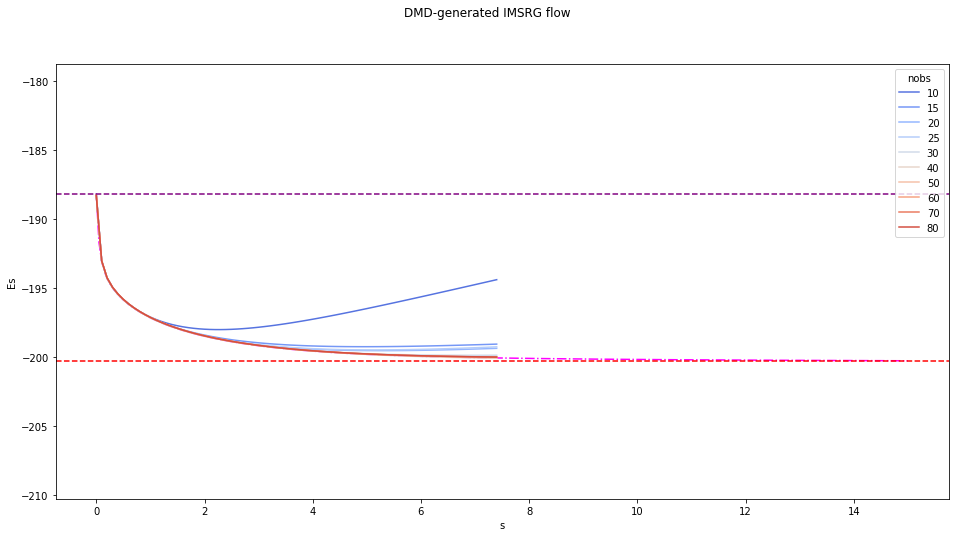

In [20]:
H0 = real_imsrg_data[:,0]
Hf = real_imsrg_data[:,-1]
print(real_imsrg_data[0,:].shape)

fig,ax = plt.subplots(figsize=(16,8))
sns.lineplot(x=np.asarray(range(0,real_imsrg_data.shape[1]))*ds, y=real_imsrg_data[0,:],ax=ax, color='fuchsia', linestyle='-.')
sns.lineplot(x="s", y="Es", hue="nobs", data=full_df, ax=ax, palette=sns.color_palette('coolwarm',len(nobs_list)))
ax.axhline(H0[0], color='purple', linestyle='--')
ax.axhline(Hf[0], color='red', linestyle='--')
fig.suptitle("DMD-generated IMSRG flow")
ax.set_ylim([Hf[0]*1.05,H0[0]*0.95])

### Comparison to open source library PyDMD

PyDMD library (https://github.com/mathLab/PyDMD)

Demo et al., (2018). PyDMD: Python Dynamic Mode Decomposition. Journal of Open Source Software, 3(22), 530, https://doi.org/10.21105/joss.00530

    @article{demo18pydmd,
        Author = {Demo, Nicola and Tezzele, Marco and Rozza, Gianluigi},
        Title = {{PyDMD: Python Dynamic Mode Decomposition}},
        Journal = {The Journal of Open Source Software},
        Volume = {3},
        Number = {22},
        Pages = {530},
        Year = {2018},
        Doi = {https://doi.org/10.21105/joss.00530}
    }

Results from library are consistent with results from my implementation, which includes the randomized SVD.

In [21]:
!pip install pydmd

     |████████████████████████████████| 40 kB 3.0 MB/s 


In [ ]:
from pydmd import DMD
from pydmd import MrDMD

# dense_idx = np.nonzero(real_imsrg_data[:,-1])
# print(dense_idx)
# RID_dense = np.zeros((len(dense_idx[0]),real_imsrg_data.shape[1]))
# print(RID_dense.shape)
# print(real_imsrg_data.shape)
# for i in range(RID_dense.shape[1]):
#     RID_dense[:,i] = real_imsrg_data[dense_idx,i]

# RID_dense_center = RID_dense - np.mean(RID_dense)
nobs = 25
dmd_lib = DMD(svd_rank=10, exact=False)#,forward_backward=True, opt=True)
dmd_lib.fit(real_imsrg_data[:,:nobs])

real_flow_comp = real_imsrg_data[0,:nobs]
# dmd = MrDMD(dmd,max_level=7,max_cycles=1)


Plot the DMD eigenvalues on the unit circle. Eigenvalues that fall outside the circle correspond to DMD modes that will diverge, since, in that case, the expansion would include powers of numbers greater than 1.

In [ ]:
%matplotlib inline
print(dmd_lib.eigs)
dmd_lib.plot_eigs(show_axes=True, show_unit_circle=True)

In [ ]:
print(dmd_lib.reconstructed_data.shape)
dmd_lib.dmd_time['tend'] *= 6
# dmd_lib.dmd_time['dt'] *=0.05

E_vals = dmd_lib.reconstructed_data[0,:]
k_vals = ds*np.asarray(range(dmd_lib.reconstructed_data.shape[1]))



In [ ]:
fig,ax = plt.subplots(figsize=(16,8))
sns.lineplot(x=k_vals, y=np.real(E_vals),ax=ax,markers=True)
sns.lineplot(x=ds*np.asarray(range(nobs)), y=real_flow_comp,ax=ax)
ax.axhline(real_imsrg_data[:,-1][0], color='red', linestyle='--')
plt.legend(['DMD constructed', 'Real flow'])

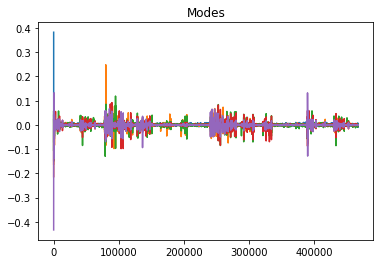

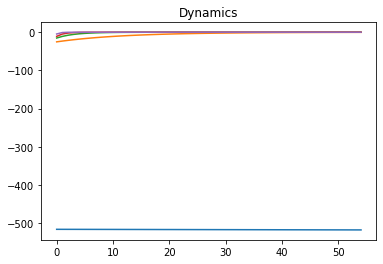

In [26]:
for i,mode in enumerate(dmd_lib.modes.T):
    plt.plot(range(len(mode.real)), mode.real)
    plt.title('Modes')
plt.show()

for i,dynamic in enumerate(dmd_lib.dynamics):
    plt.plot(range(len(dynamic.real)), dynamic.real)
    plt.title('Dynamics')
plt.show()

### Correlation between DMD-evolved Hamiltonian and IMSRG-evolved Hamiltonian

We want to make sure that all DMD-evolved matrix elements are consistent with the IMSRG-evolved matrix elements. Compute the Pearson correlation between results and plot vs $s$, and make several plots of DMD MEs and IMSRG MEs on perpendicular axes.

In [27]:
%cd /content/drive/MyDrive/grad_school/group_meeting_reports/12-16-2021/

/content/drive/MyDrive/grad_school/group_meeting_reports/12-16-2021


In [28]:
# Get the DMD evolved matrix elements
real_imsrg_data = get_ascii_log('flow/O16_chi2b_srg0625_eMax06_hwHO020.flow.log.ds0.05.log')

ds = 0.05
nobs = 25
X = real_imsrg_data[:, :nobs]
Xp = real_imsrg_data[:, 1:nobs+1]

H0 = real_imsrg_data[:,0]
Hf = real_imsrg_data[:,-1]

phi,dmd_eig,b = dmd(X, Xp, exact=False, 
                            r=nobs, 
                            randomize=True,
                            n_components=min(nobs,25),
                            as_matrix=True)

k_vals = range(0,420)
df_list = []
for k in k_vals:
    s = k*ds
    Hs = phi@np.linalg.matrix_power(dmd_eig,k)@b
    Hs = np.real(Hs)
    Hs_imsrg = real_imsrg_data[:,k]

    corr, _ = stats.pearsonr(Hs, Hs_imsrg) 
    s = k*ds
    
    row = pd.DataFrame([[s, corr]], columns=["s", "correlation"])
    df_list.append(row)

    print("s = {:0.2f}".format(s))
full_df = pd.concat(df_list, ignore_index=True)

Line 01 | Loaded  3.56 MBs from file
Line 02 | Loaded  7.13 MBs from file
Line 03 | Loaded 10.69 MBs from file
Line 04 | Loaded 14.26 MBs from file
Line 05 | Loaded 17.82 MBs from file
Line 06 | Loaded 21.38 MBs from file
Line 07 | Loaded 24.95 MBs from file
Line 08 | Loaded 28.51 MBs from file
Line 09 | Loaded 32.08 MBs from file
Line 10 | Loaded 35.64 MBs from file
Line 11 | Loaded 39.20 MBs from file
Line 12 | Loaded 42.77 MBs from file
Line 13 | Loaded 46.33 MBs from file
Line 14 | Loaded 49.90 MBs from file
Line 15 | Loaded 53.46 MBs from file
Line 16 | Loaded 57.02 MBs from file
Line 17 | Loaded 60.59 MBs from file
Line 18 | Loaded 64.15 MBs from file
Line 19 | Loaded 67.71 MBs from file
Line 20 | Loaded 71.28 MBs from file
Line 21 | Loaded 74.84 MBs from file
Line 22 | Loaded 78.41 MBs from file
Line 23 | Loaded 81.97 MBs from file
Line 24 | Loaded 85.53 MBs from file
Line 25 | Loaded 89.10 MBs from file
Line 26 | Loaded 92.66 MBs from file
Line 27 | Loaded 96.23 MBs from file
L

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


(467133, 25)
(25, 25)
phi,  (467133, 25)
b  (25,)
Hs,  (467133,)
s = 0.00
s = 0.05
s = 0.10
s = 0.15
s = 0.20
s = 0.25
s = 0.30
s = 0.35
s = 0.40
s = 0.45
s = 0.50
s = 0.55
s = 0.60
s = 0.65
s = 0.70
s = 0.75
s = 0.80
s = 0.85
s = 0.90
s = 0.95
s = 1.00
s = 1.05
s = 1.10
s = 1.15
s = 1.20
s = 1.25
s = 1.30
s = 1.35
s = 1.40
s = 1.45
s = 1.50
s = 1.55
s = 1.60
s = 1.65
s = 1.70
s = 1.75
s = 1.80
s = 1.85
s = 1.90
s = 1.95
s = 2.00
s = 2.05
s = 2.10
s = 2.15
s = 2.20
s = 2.25
s = 2.30
s = 2.35
s = 2.40
s = 2.45
s = 2.50
s = 2.55
s = 2.60
s = 2.65
s = 2.70
s = 2.75
s = 2.80
s = 2.85
s = 2.90
s = 2.95
s = 3.00
s = 3.05
s = 3.10
s = 3.15
s = 3.20
s = 3.25
s = 3.30
s = 3.35
s = 3.40
s = 3.45
s = 3.50
s = 3.55
s = 3.60
s = 3.65
s = 3.70
s = 3.75
s = 3.80
s = 3.85
s = 3.90
s = 3.95
s = 4.00
s = 4.05
s = 4.10
s = 4.15
s = 4.20
s = 4.25
s = 4.30
s = 4.35
s = 4.40
s = 4.45
s = 4.50
s = 4.55
s = 4.60
s = 4.65
s = 4.70
s = 4.75
s = 4.80
s = 4.85
s = 4.90
s = 4.95
s = 5.00
s = 5.05
s = 5.10
s = 5.15

Text(0.5, 1.0, 's = 21.00')

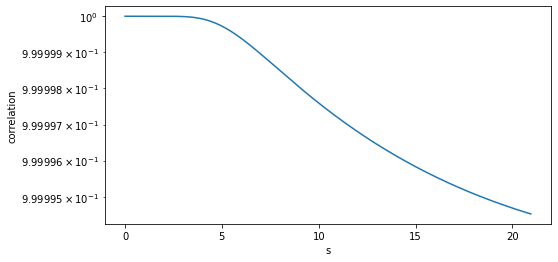

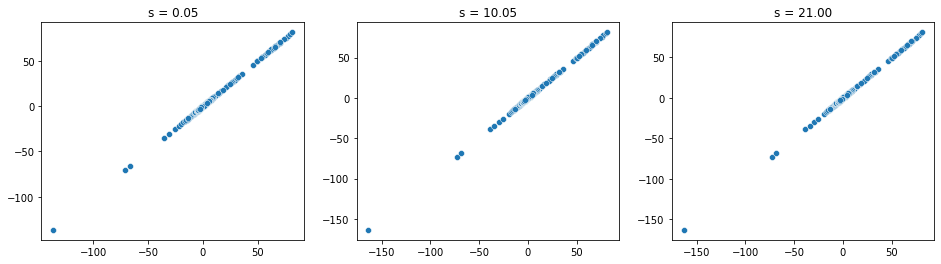

In [29]:
fig,ax = plt.subplots(figsize=(8,4))
sns.lineplot(x='s', y='correlation', data=full_df, ax=ax)
ax.set_yscale('log')

fig,axes = plt.subplots(figsize=(16,4),nrows=1,ncols=3)

Hs = np.real(phi@np.linalg.matrix_power(dmd_eig,0)@b)
H_imsrg = real_imsrg_data[:,0]
sns.scatterplot(x=H_imsrg, y=Hs, ax=axes[0])
axes[0].set_title("s = {:0.2f}".format(1*ds))

Hs = np.real(phi@np.linalg.matrix_power(dmd_eig,200)@b)
H_imsrg = real_imsrg_data[:,200]
sns.scatterplot(x=H_imsrg, y=Hs, ax=axes[1])
axes[1].set_title("s = {:0.2f}".format(201*ds))

Hs = np.real(phi@np.linalg.matrix_power(dmd_eig,419)@b)
H_imsrg = real_imsrg_data[:,419]
sns.scatterplot(x=H_imsrg, y=Hs, ax=axes[2])
axes[2].set_title("s = {:0.2f}".format(420*ds))



The IMSRG and DMD results are consistent over the full dynamic range ($s$ = 21.0), with Pearson correlation dropping off an imperceptile amount the further we get from the observation set.

In [30]:
# Get the DMD evolved matrix elements
real_imsrg_data = get_ascii_log('flow/O16_chi2b_srg0625_eMax06_hwHO020.flow.log.ds0.1.log')

ds = 0.1
nobs = 25
X = real_imsrg_data[:, :nobs]
Xp = real_imsrg_data[:, 1:nobs+1]

H0 = real_imsrg_data[:,0]
Hf = real_imsrg_data[:,-1]

phi,dmd_eig,b = dmd(X, Xp, exact=False, 
                            r=nobs, 
                            randomize=True,
                            n_components=min(nobs,25),
                            as_matrix=True)

k_vals = range(0,210)
df_list = []
for k in k_vals:
    s = k*ds
    Hs = phi@np.linalg.matrix_power(dmd_eig,k)@b
    Hs = np.real(Hs)
    Hs_imsrg = real_imsrg_data[:,k]

    corr, _ = stats.pearsonr(Hs, Hs_imsrg) 
    s = k*ds
    
    row = pd.DataFrame([[s, corr]], columns=["s", "correlation"])
    df_list.append(row)

    print("s = {:0.2f}".format(s))
full_df = pd.concat(df_list, ignore_index=True)

Line 01 | Loaded  3.56 MBs from file
Line 02 | Loaded  7.13 MBs from file
Line 03 | Loaded 10.69 MBs from file
Line 04 | Loaded 14.26 MBs from file
Line 05 | Loaded 17.82 MBs from file
Line 06 | Loaded 21.38 MBs from file
Line 07 | Loaded 24.95 MBs from file
Line 08 | Loaded 28.51 MBs from file
Line 09 | Loaded 32.08 MBs from file
Line 10 | Loaded 35.64 MBs from file
Line 11 | Loaded 39.20 MBs from file
Line 12 | Loaded 42.77 MBs from file
Line 13 | Loaded 46.33 MBs from file
Line 14 | Loaded 49.90 MBs from file
Line 15 | Loaded 53.46 MBs from file
Line 16 | Loaded 57.02 MBs from file
Line 17 | Loaded 60.59 MBs from file
Line 18 | Loaded 64.15 MBs from file
Line 19 | Loaded 67.71 MBs from file
Line 20 | Loaded 71.28 MBs from file
Line 21 | Loaded 74.84 MBs from file
Line 22 | Loaded 78.41 MBs from file
Line 23 | Loaded 81.97 MBs from file
Line 24 | Loaded 85.53 MBs from file
Line 25 | Loaded 89.10 MBs from file
Line 26 | Loaded 92.66 MBs from file
Line 27 | Loaded 96.23 MBs from file
L

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


(467133, 25)
(25, 25)
phi,  (467133, 25)
b  (25,)
Hs,  (467133,)
s = 0.00
s = 0.10
s = 0.20
s = 0.30
s = 0.40
s = 0.50
s = 0.60
s = 0.70
s = 0.80
s = 0.90
s = 1.00
s = 1.10
s = 1.20
s = 1.30
s = 1.40
s = 1.50
s = 1.60
s = 1.70
s = 1.80
s = 1.90
s = 2.00
s = 2.10
s = 2.20
s = 2.30
s = 2.40
s = 2.50
s = 2.60
s = 2.70
s = 2.80
s = 2.90
s = 3.00
s = 3.10
s = 3.20
s = 3.30
s = 3.40
s = 3.50
s = 3.60
s = 3.70
s = 3.80
s = 3.90
s = 4.00
s = 4.10
s = 4.20
s = 4.30
s = 4.40
s = 4.50
s = 4.60
s = 4.70
s = 4.80
s = 4.90
s = 5.00
s = 5.10
s = 5.20
s = 5.30
s = 5.40
s = 5.50
s = 5.60
s = 5.70
s = 5.80
s = 5.90
s = 6.00
s = 6.10
s = 6.20
s = 6.30
s = 6.40
s = 6.50
s = 6.60
s = 6.70
s = 6.80
s = 6.90
s = 7.00
s = 7.10
s = 7.20
s = 7.30
s = 7.40
s = 7.50
s = 7.60
s = 7.70
s = 7.80
s = 7.90
s = 8.00
s = 8.10
s = 8.20
s = 8.30
s = 8.40
s = 8.50
s = 8.60
s = 8.70
s = 8.80
s = 8.90
s = 9.00
s = 9.10
s = 9.20
s = 9.30
s = 9.40
s = 9.50
s = 9.60
s = 9.70
s = 9.80
s = 9.90
s = 10.00
s = 10.10
s = 10.20
s = 1

Text(0.5, 1.0, 's = 21.00')

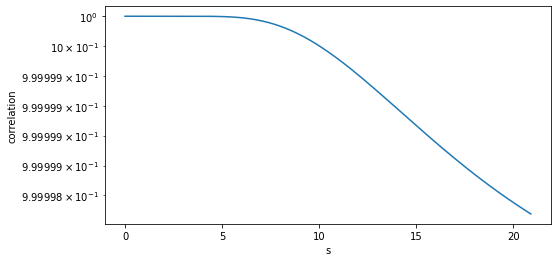

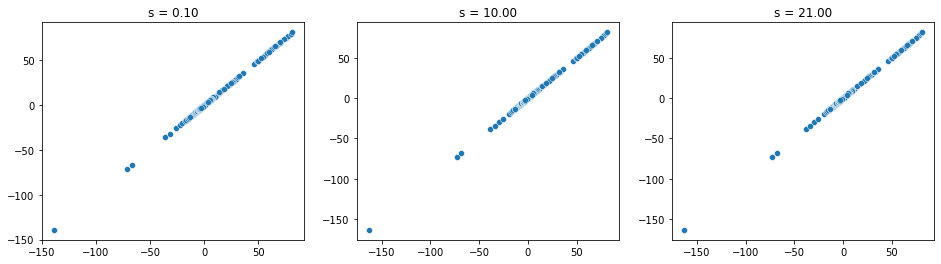

In [31]:
fig,ax = plt.subplots(figsize=(8,4))
sns.lineplot(x='s', y='correlation', data=full_df, ax=ax)
ax.set_yscale('log')

fig,axes = plt.subplots(figsize=(16,4),nrows=1,ncols=3)

Hs = np.real(phi@np.linalg.matrix_power(dmd_eig,0)@b)
H_imsrg = real_imsrg_data[:,0]
sns.scatterplot(x=H_imsrg, y=Hs, ax=axes[0])
axes[0].set_title("s = {:0.2f}".format(1*ds))

Hs = np.real(phi@np.linalg.matrix_power(dmd_eig,99)@b)
H_imsrg = real_imsrg_data[:,99]
sns.scatterplot(x=H_imsrg, y=Hs, ax=axes[1])
axes[1].set_title("s = {:0.2f}".format(100*ds))

Hs = np.real(phi@np.linalg.matrix_power(dmd_eig,209)@b)
H_imsrg = real_imsrg_data[:,209]
sns.scatterplot(x=H_imsrg, y=Hs, ax=axes[2])
axes[2].set_title("s = {:0.2f}".format(210*ds))

In [32]:
# Get the DMD evolved matrix elements
real_imsrg_data = get_ascii_log('flow/O16_chi2b_srg0625_eMax06_hwHO020.flow.log')

ds = 0.025
nobs = 25
X = real_imsrg_data[:, :nobs]
Xp = real_imsrg_data[:, 1:nobs+1]

H0 = real_imsrg_data[:,0]
Hf = real_imsrg_data[:,-1]

phi,dmd_eig,b = dmd(X, Xp, exact=False, 
                            r=nobs, 
                            randomize=True,
                            n_components=min(nobs,25),
                            as_matrix=True)

k_vals = range(0,210)
df_list = []
for k in k_vals:
    s = k*ds
    Hs = phi@np.linalg.matrix_power(dmd_eig,k)@b
    Hs = np.real(Hs)
    Hs_imsrg = real_imsrg_data[:,k]

    corr, _ = stats.pearsonr(Hs, Hs_imsrg) 
    s = k*ds
    
    row = pd.DataFrame([[s, corr]], columns=["s", "correlation"])
    df_list.append(row)

    print("s = {:0.2f}".format(s))
full_df = pd.concat(df_list, ignore_index=True)

Line 01 | Loaded  3.56 MBs from file
Line 02 | Loaded  7.13 MBs from file
Line 03 | Loaded 10.69 MBs from file
Line 04 | Loaded 14.26 MBs from file
Line 05 | Loaded 17.82 MBs from file
Line 06 | Loaded 21.38 MBs from file
Line 07 | Loaded 24.95 MBs from file
Line 08 | Loaded 28.51 MBs from file
Line 09 | Loaded 32.08 MBs from file
Line 10 | Loaded 35.64 MBs from file
Line 11 | Loaded 39.20 MBs from file
Line 12 | Loaded 42.77 MBs from file
Line 13 | Loaded 46.33 MBs from file
Line 14 | Loaded 49.90 MBs from file
Line 15 | Loaded 53.46 MBs from file
Line 16 | Loaded 57.02 MBs from file
Line 17 | Loaded 60.59 MBs from file
Line 18 | Loaded 64.15 MBs from file
Line 19 | Loaded 67.71 MBs from file
Line 20 | Loaded 71.28 MBs from file
Line 21 | Loaded 74.84 MBs from file
Line 22 | Loaded 78.41 MBs from file
Line 23 | Loaded 81.97 MBs from file
Line 24 | Loaded 85.53 MBs from file
Line 25 | Loaded 89.10 MBs from file
Line 26 | Loaded 92.66 MBs from file
Line 27 | Loaded 96.23 MBs from file
L

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


(467133, 25)
(25, 25)
phi,  (467133, 25)
b  (25,)
Hs,  (467133,)
s = 0.00
s = 0.03
s = 0.05
s = 0.08
s = 0.10
s = 0.12
s = 0.15
s = 0.18
s = 0.20
s = 0.23
s = 0.25
s = 0.28
s = 0.30
s = 0.33
s = 0.35
s = 0.38
s = 0.40
s = 0.43
s = 0.45
s = 0.48
s = 0.50
s = 0.53
s = 0.55
s = 0.58
s = 0.60
s = 0.62
s = 0.65
s = 0.68
s = 0.70
s = 0.73
s = 0.75
s = 0.78
s = 0.80
s = 0.83
s = 0.85
s = 0.88
s = 0.90
s = 0.93
s = 0.95
s = 0.98
s = 1.00
s = 1.03
s = 1.05
s = 1.07
s = 1.10
s = 1.12
s = 1.15
s = 1.18
s = 1.20
s = 1.23
s = 1.25
s = 1.28
s = 1.30
s = 1.33
s = 1.35
s = 1.38
s = 1.40
s = 1.43
s = 1.45
s = 1.48
s = 1.50
s = 1.53
s = 1.55
s = 1.58
s = 1.60
s = 1.62
s = 1.65
s = 1.68
s = 1.70
s = 1.73
s = 1.75
s = 1.78
s = 1.80
s = 1.83
s = 1.85
s = 1.88
s = 1.90
s = 1.93
s = 1.95
s = 1.98
s = 2.00
s = 2.02
s = 2.05
s = 2.08
s = 2.10
s = 2.12
s = 2.15
s = 2.18
s = 2.20
s = 2.23
s = 2.25
s = 2.27
s = 2.30
s = 2.33
s = 2.35
s = 2.38
s = 2.40
s = 2.43
s = 2.45
s = 2.48
s = 2.50
s = 2.53
s = 2.55
s = 2.58

-162.01519810838542


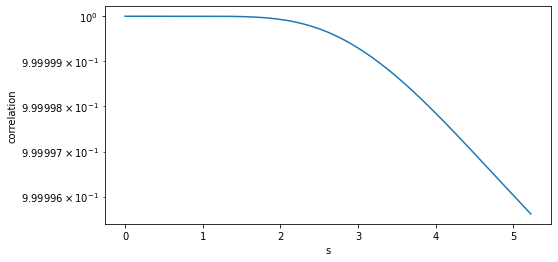

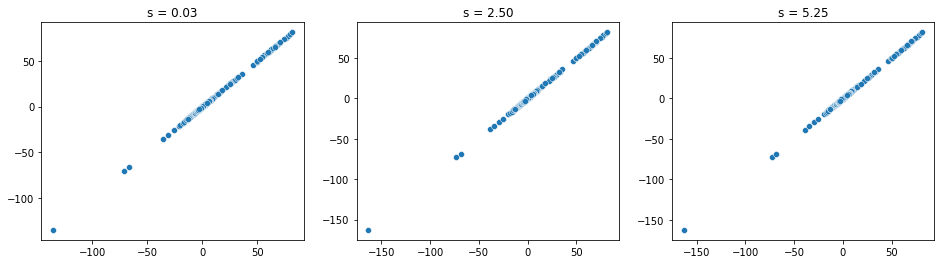

In [33]:
fig,ax = plt.subplots(figsize=(8,4))
sns.lineplot(x='s', y='correlation', data=full_df, ax=ax)
ax.set_yscale('log')

fig,axes = plt.subplots(figsize=(16,4),nrows=1,ncols=3)

Hs = np.real(phi@np.linalg.matrix_power(dmd_eig,0)@b)
H_imsrg = real_imsrg_data[:,0]
sns.scatterplot(x=H_imsrg, y=Hs, ax=axes[0])
axes[0].set_title("s = {:0.2f}".format(1*ds))

Hs = np.real(phi@np.linalg.matrix_power(dmd_eig,99)@b)
H_imsrg = real_imsrg_data[:,99]
sns.scatterplot(x=H_imsrg, y=Hs, ax=axes[1])
axes[1].set_title("s = {:0.2f}".format(100*ds))

Hs = np.real(phi@np.linalg.matrix_power(dmd_eig,209)@b)
H_imsrg = real_imsrg_data[:,209]
sns.scatterplot(x=H_imsrg, y=Hs, ax=axes[2])
axes[2].set_title("s = {:0.2f}".format(210*ds))

Hs = np.real(phi@np.linalg.matrix_power(dmd_eig,840)@b)
print(Hs[0])

In [34]:
# Get the DMD evolved matrix elements
real_imsrg_data = get_ascii_log('flow/Ne20_chi2b_srg0625_eMax06_hwHO020.flow.log')

ds = 0.025
nobs = 25
X = real_imsrg_data[:, :nobs]
Xp = real_imsrg_data[:, 1:nobs+1]

H0 = real_imsrg_data[:,0]
Hf = real_imsrg_data[:,-1]

phi,dmd_eig,b = dmd(X, Xp, exact=False, 
                            r=nobs, 
                            randomize=True,
                            n_components=min(nobs,25),
                            as_matrix=True)

k_vals = range(0,210)
df_list = []
for k in k_vals:
    s = k*ds
    Hs = phi@np.linalg.matrix_power(dmd_eig,k)@b
    Hs = np.real(Hs)
    Hs_imsrg = real_imsrg_data[:,k]

    corr, _ = stats.pearsonr(Hs, Hs_imsrg) 
    s = k*ds
    
    row = pd.DataFrame([[s, corr]], columns=["s", "correlation"])
    df_list.append(row)

    print("s = {:0.2f}".format(s))
full_df = pd.concat(df_list, ignore_index=True)

Line 01 | Loaded  3.56 MBs from file
Line 02 | Loaded  7.13 MBs from file
Line 03 | Loaded 10.69 MBs from file
Line 04 | Loaded 14.26 MBs from file
Line 05 | Loaded 17.82 MBs from file
Line 06 | Loaded 21.38 MBs from file
Line 07 | Loaded 24.95 MBs from file
Line 08 | Loaded 28.51 MBs from file
Line 09 | Loaded 32.08 MBs from file
Line 10 | Loaded 35.64 MBs from file
Line 11 | Loaded 39.20 MBs from file
Line 12 | Loaded 42.77 MBs from file
Line 13 | Loaded 46.33 MBs from file
Line 14 | Loaded 49.90 MBs from file
Line 15 | Loaded 53.46 MBs from file
Line 16 | Loaded 57.02 MBs from file
Line 17 | Loaded 60.59 MBs from file
Line 18 | Loaded 64.15 MBs from file
Line 19 | Loaded 67.71 MBs from file
Line 20 | Loaded 71.28 MBs from file
Line 21 | Loaded 74.84 MBs from file
Line 22 | Loaded 78.41 MBs from file
Line 23 | Loaded 81.97 MBs from file
Line 24 | Loaded 85.53 MBs from file
Line 25 | Loaded 89.10 MBs from file
Line 26 | Loaded 92.66 MBs from file
Line 27 | Loaded 96.23 MBs from file
L

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


(467133, 25)
(25, 25)
phi,  (467133, 25)
b  (25,)
Hs,  (467133,)
s = 0.00
s = 0.03
s = 0.05
s = 0.08
s = 0.10
s = 0.12
s = 0.15
s = 0.18
s = 0.20
s = 0.23
s = 0.25
s = 0.28
s = 0.30
s = 0.33
s = 0.35
s = 0.38
s = 0.40
s = 0.43
s = 0.45
s = 0.48
s = 0.50
s = 0.53
s = 0.55
s = 0.58
s = 0.60
s = 0.62
s = 0.65
s = 0.68
s = 0.70
s = 0.73
s = 0.75
s = 0.78
s = 0.80
s = 0.83
s = 0.85
s = 0.88
s = 0.90
s = 0.93
s = 0.95
s = 0.98
s = 1.00
s = 1.03
s = 1.05
s = 1.07
s = 1.10
s = 1.12
s = 1.15
s = 1.18
s = 1.20
s = 1.23
s = 1.25
s = 1.28
s = 1.30
s = 1.33
s = 1.35
s = 1.38
s = 1.40
s = 1.43
s = 1.45
s = 1.48
s = 1.50
s = 1.53
s = 1.55
s = 1.58
s = 1.60
s = 1.62
s = 1.65
s = 1.68
s = 1.70
s = 1.73
s = 1.75
s = 1.78
s = 1.80
s = 1.83
s = 1.85
s = 1.88
s = 1.90
s = 1.93
s = 1.95
s = 1.98
s = 2.00
s = 2.02
s = 2.05
s = 2.08
s = 2.10
s = 2.12
s = 2.15
s = 2.18
s = 2.20
s = 2.23
s = 2.25
s = 2.27
s = 2.30
s = 2.33
s = 2.35
s = 2.38
s = 2.40
s = 2.43
s = 2.45
s = 2.48
s = 2.50
s = 2.53
s = 2.55
s = 2.58

-197.70587449722586


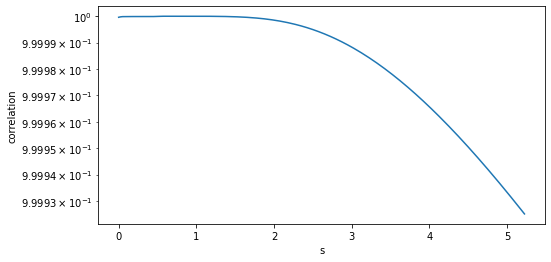

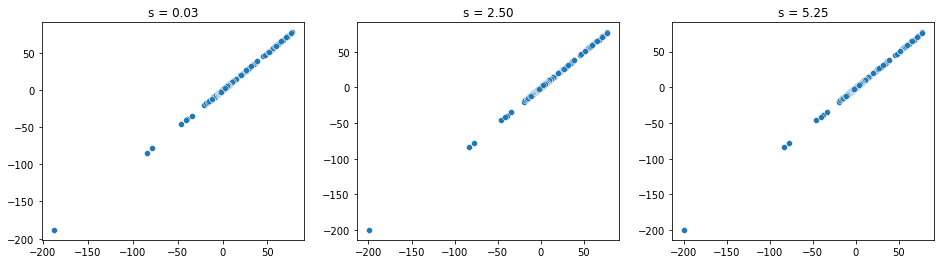

In [35]:
fig,ax = plt.subplots(figsize=(8,4))
sns.lineplot(x='s', y='correlation', data=full_df, ax=ax)
ax.set_yscale('log')

fig,axes = plt.subplots(figsize=(16,4),nrows=1,ncols=3)

Hs = np.real(phi@np.linalg.matrix_power(dmd_eig,0)@b)
H_imsrg = real_imsrg_data[:,0]
sns.scatterplot(x=H_imsrg, y=Hs, ax=axes[0])
axes[0].set_title("s = {:0.2f}".format(1*ds))

Hs = np.real(phi@np.linalg.matrix_power(dmd_eig,99)@b)
H_imsrg = real_imsrg_data[:,99]
sns.scatterplot(x=H_imsrg, y=Hs, ax=axes[1])
axes[1].set_title("s = {:0.2f}".format(100*ds))

Hs = np.real(phi@np.linalg.matrix_power(dmd_eig,209)@b)
H_imsrg = real_imsrg_data[:,209]
sns.scatterplot(x=H_imsrg, y=Hs, ax=axes[2])
axes[2].set_title("s = {:0.2f}".format(210*ds))

Hs = np.real(phi@np.linalg.matrix_power(dmd_eig,840)@b)
print(Hs[0])

One note about $\Delta s = 0.025$. At this scale, the nonlinear solver is outputting several (up to 8) interpolated state vectors per integrator step. The dynamic information provided to the DMD algorithm may not exactly correspond to the solution.

### Short summary of how $\Delta s$ changes emulation

#### 25 observations -- $\Delta s = 0.100$ -- Max observation $s=2.500$
![](https://drive.google.com/uc?export=view&id=1Zbd_hM47mRjjQRiKMyHy2YML7Rp6egqf)


#### 25 observations -- $\Delta s = 0.050$ -- Max observation $s=1.250$
![](https://drive.google.com/uc?export=view&id=1ttoI60Dz_RSVV_B_dYS3RIvCPB6jge3n)


#### 25 observations -- $\Delta s = 0.025$ -- Max observation $s=0.625$
![](https://drive.google.com/uc?export=view&id=10fldSMWCvtQvMJp6NH0jHiybrThZAcZF)

#### 30 observations -- $\Delta s = 0.025$ -- Max observation $s=0.750$
![](https://drive.google.com/uc?export=view&id=1BqtAo8getEZLNgEMHEPWbhFcEl7QuGMe)

The maximum value of $s$ required for DMD-emulated convergence to be consistent with the IMSRG solution is controlled by the $\Delta s$. Within the constraints of the ODE solver, we can shorten the $s$ required for good convergence for fixed number of observations, just by reducing the step width $\Delta s$. In the last two figures, $\Delta s = 0.025$ may be too fine for good convergence with only 25 observations, but adding an extra 5 (at minimal computational cost) improves the convergence and keeps the interpolation range below $s=1.0$.

## Some conclusions and reflections

### DMD as an emulator for IMSRG

> **emulation:** reproduction of the function or action of a different computer, software system, etc. (Oxford Languages)


The dynamic mode decomposition is powerful; the expansion can emulate the solution to a nonlinear system with as many as 400,000 state variables. The DMD expansion seems to be sensitive to timestep width, and performs optimally when the width is constant between observations. We have motivation to design a DMD-driven or DMD-forecasted IMSRG solver, which has the capacity to converge to optimal results with an order of magnitude fewer solver iterations from the integrator.

An important distinction to make is that the DMD algorithm does not emulate the IMSRG flow; the DMD algorithm **emulates the *solution* to the flow *via*** the SUNDIALS nonlinear system solver, or the Boost ODEINT, or whatever differential equation solver was used. In this way, the **DMD algorithm is subject to the limitations of that specific solver**.

### Ideas for DMD-boosted IMSRG

* Sliding window of N observations that forecasts F number of data points ahead
    * Good for checking divergences; cut off wasted iterations
    * Need to decide when to stop flow and emulate result
* Complete DMD-emulated result
    * Input max observations, max emulation range, step width
    * Run the IMSRG for max observations
    * DMD-expand the results up to max emulation range

Since the success of DMD is heavily dependent on $\Delta s$, it will potentially be difficult to decide the flow scale ahead of the computation. When the solver step size is much larger than $\Delta s$, there are wasted observations that don't actually flow the result.

E.g.

s | E(0) \[MeV\]| E(2) [MeV]| E_tot [MeV] | dE/ds | \|\|ydot\|\| |   \|\|eta\|\| | t (sec)  |    #calls
---|---|----|---|----|----|---|---|---
1.360000 |  -199.3496415   |    0.0000000   |  -199.3496415  |     -0.9660433    |    7.6689304   |     1.9665636 |   2.7452061  |        151  149  298
1.380000    |      -199.3703340    |    0.0000000   |  -199.3703340 |      -0.9660433   |     7.6689304   |     1.9665636 |   0.0044248     |     151     149     298
1.400000    |      -199.3904715  |      0.0000000  |   -199.3904715   |    -0.9660433     |   7.6689304  |      1.9665636 |   0.0044489    |      151    149    298
1.420000    |      -199.4100679   |     0.0000000 |    -199.4100679   |    -0.9660433  |      7.6689304   |     1.9665636 |   0.0024559      |    151    149    298
1.440000     |     -199.4291508   |     0.0000000  |   -199.4291508 |      -0.8316277    |    6.9869517    |    1.8226299 |   4.7056968     |     152    153    306
1.460000     |     -199.4477288    |    0.0000000 |    -199.4477288    |   -0.8316277    |    6.9869517    |    1.8226299 |   0.0027499     |     152    153    306
1.480000      |    -199.4658147   |     0.0000000  |   -199.4658147   |    -0.8316277    |    6.9869517  |      1.8226299 |   0.0025840      |    152    153    306
1.500000     |     -199.4834202    |    0.0000000 |    -199.4834202 |      -0.8316277      |  6.9869517    |    1.8226299 |   0.0033400     |     152    153    306
1.520000    |      -199.5005557   |     0.0000000 |    -199.5005557   |    -0.8316277    |    6.9869517    |    1.8226299 |   0.0025110   |       152    153    306
1.540000   |       -199.5172401  |      0.0000000 |    -199.5172401   |    -0.7177259   |     6.3983817 |       1.6912358 |   5.2718101     |     154    157    314
1.560000      |    -199.5334989    |    0.0000000  |   -199.5334989 |      -0.7177259     |   6.3983817  |      1.6912358 |   0.0024981  |        154    157    314
1.580000   |       -199.5493327   |     0.0000000|     -199.5493327  |     -0.7177259    |    6.3983817    |    1.6912358 |   0.0025640   |       154    157    314
1.600000   |       -199.5647520  |      0.0000000 |    -199.5647520   |    -0.7177259    |    6.3983817  |      1.6912358 |   0.0024910  |        154    157    314
1.620000    |      -199.5797667     |   0.0000000   |  -199.5797667   |    -0.7177259    |    6.3983817   |     1.6912358 |   0.0023482   |       154    157    314
1.640000    |      -199.5943858   |     0.0000000  |   -199.5943858  |     -0.7177259    |    6.3983817  |      1.6912358 |   0.0025671    |      154    157    314

There are some regions where the solver takes very small steps, where flow information is lost inside the step width. There are other regions where the solver takes large steps, where the step width is too small and the solver interpolates the output for several data points.

$\mathbf{x}(t) \approx \sum_{k=1}^{r} \boldsymbol{\phi}_{k} \exp \left( \omega_{k} t \right) b_{k} = \sum_{k=1}^{r} \boldsymbol{\phi}_{k} \left( \lambda_{k} \right)^{\left( t / \Delta t \right)} b_{k}$

In [36]:
real_imsrg_data = get_ascii_log("flow/O16_chi2b_srg0625_eMax06_hwHO020.flow.log.bk")

Line 01 | Loaded  3.56 MBs from file
Line 02 | Loaded  7.13 MBs from file
Line 03 | Loaded 10.69 MBs from file
Line 04 | Loaded 14.26 MBs from file
Line 05 | Loaded 17.82 MBs from file
Line 06 | Loaded 21.38 MBs from file
Line 07 | Loaded 24.95 MBs from file
Line 08 | Loaded 28.51 MBs from file
Line 09 | Loaded 32.08 MBs from file
Line 10 | Loaded 35.64 MBs from file
Line 11 | Loaded 39.20 MBs from file
Line 12 | Loaded 42.77 MBs from file
Line 13 | Loaded 46.33 MBs from file
Line 14 | Loaded 49.90 MBs from file
Line 15 | Loaded 53.46 MBs from file
Line 16 | Loaded 57.02 MBs from file
Line 17 | Loaded 60.59 MBs from file
Line 18 | Loaded 64.15 MBs from file
Line 19 | Loaded 67.71 MBs from file
Line 20 | Loaded 71.28 MBs from file
Line 21 | Loaded 74.84 MBs from file
Line 22 | Loaded 78.41 MBs from file
Line 23 | Loaded 81.97 MBs from file
Line 24 | Loaded 85.53 MBs from file
Line 25 | Loaded 89.10 MBs from file
Line 26 | Loaded 92.66 MBs from file
Line 27 | Loaded 96.23 MBs from file
L

In [ ]:
from pydmd import OptDMD

svd_rank = 10
nobs = 30
extrap = 3

real_flow_comp = real_imsrg_data[0,:nobs]

opt_dmd = OptDMD(svd_rank=svd_rank, factorization="svd")
opt_dmd.fit(real_imsrg_data[:,:nobs])

print(dmd_lib.reconstructed_data.shape)
dmd_lib.dmd_time['tend'] *= extrap
# dmd_lib.dmd_time['dt'] *=0.05

E_vals = dmd_lib.reconstructed_data[0,:]
k_vals = np.asarray(range(dmd_lib.reconstructed_data.shape[1]))

fig,ax = plt.subplots(figsize=(16,8))
sns.lineplot(x=k_vals, y=np.real(E_vals),ax=ax,markers=True)
sns.lineplot(x=np.asarray(range(nobs)), y=real_flow_comp,ax=ax)
ax.axhline(real_imsrg_data[:,-1][0], color='red', linestyle='--')
plt.legend(['DMD constructed', 'Real flow'])
ax.set_ylim([-170,-100])

dmd_lib.dmd_time['tend'] /= extrap

/usr/local/lib/python3.7/dist-packages/pydmd/dmdbase.py:351: UserWarning: Input data matrix X has condition number 22380839.375819813. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  cond_number


(467133, 487)
